# Modelagem do dataset transacional

Transformação do dataset transacional em um dataset agrupado com objetivo de analisar as transações dentro de uma janela de tempo, aplicando experimentos para identificar a melhor janela.

## Biblitecas

Bibliotecas utilizadas para o processo

In [1]:
%pip install statstests

In [2]:
import os
import tqdm
import math
import shutil
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from scipy import stats
from tqdm.auto import tqdm
import statsmodels.api as sm
from scipy.stats import entropy
import matplotlib.pyplot as plt
from dataclasses import dataclass
from sklearn.cluster import KMeans
from __future__ import annotations
from warnings import filterwarnings
from statstests.tests import overdisp
import statsmodels.formula.api as smf
from statstests.process import stepwise
from scipy.stats import poisson, nbinom
from sklearn.exceptions import NotFittedError
from sklearn.utils import check_array, check_X_y
from statsmodels.stats.stattools import durbin_watson
from pandas.tseries.holiday import USFederalHolidayCalendar
from statsmodels.nonparametric.smoothers_lowess import lowess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import MinMaxScaler, KBinsDiscretizer
from typing import Dict, List, Set, Tuple, Optional, Any, Union, Iterable
from statsmodels.discrete.discrete_model import NegativeBinomial, Poisson
from statsmodels.stats.diagnostic import acorr_ljungbox, het_breuschpagan
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP,ZeroInflatedPoisson

import warnings
warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", palette="deep", font_scale=1.1)

## Carregamento de dados e ajuste de dados/valores

In [3]:
if 'google.colab' in str(get_ipython()):
  from google.colab import drive
  from google.colab import userdata

  os.makedirs('./datasets', exist_ok=True)
  drive.mount('/content/drive')

  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_train_test.parquet','/content/datasets/')
  shutil.copy('/content/drive/MyDrive/DataScience/Analytics/Estudo Fraude/df_validation.parquet','/content/datasets/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df = pl.concat([pl.read_parquet('./datasets/df_train_test.parquet'), pl.read_parquet('./datasets/df_validation.parquet')])
df = df.filter(pl.col('amount') >= pl.lit(0))
df.head()

shape: (5, 38)
┌─────────┬────────────┬───────────┬─────────┬───┬────────────┬────────────┬───────────┬───────────┐
│ id      ┆ date       ┆ client_id ┆ card_id ┆ … ┆ credit_lim ┆ acct_open_ ┆ year_pin_ ┆ card_on_d │
│ ---     ┆ ---        ┆ ---       ┆ ---     ┆   ┆ it         ┆ date       ┆ last_chan ┆ ark_web   │
│ i64     ┆ datetime[n ┆ i64       ┆ i64     ┆   ┆ ---        ┆ ---        ┆ ged       ┆ ---       │
│         ┆ s]         ┆           ┆         ┆   ┆ f64        ┆ str        ┆ ---       ┆ str       │
│         ┆            ┆           ┆         ┆   ┆            ┆            ┆ i64       ┆           │
╞═════════╪════════════╪═══════════╪═════════╪═══╪════════════╪════════════╪═══════════╪═══════════╡
│ 7475328 ┆ 2010-01-01 ┆ 561       ┆ 4575    ┆ … ┆ 9100.0     ┆ 09/2005    ┆ 2015      ┆ No        │
│         ┆ 00:02:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475329 ┆ 2010-01-01 ┆ 1129      ┆ 102     ┆ … ┆ 14802.0    ┆ 01/2006    ┆ 2008      ┆ No        │
│         ┆ 00:02:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475332 ┆ 2010-01-01 ┆ 848       ┆ 3915    ┆ … ┆ 19113.0    ┆ 07/2009    ┆ 2014      ┆ No        │
│         ┆ 00:06:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475333 ┆ 2010-01-01 ┆ 1807      ┆ 165     ┆ … ┆ 89.0       ┆ 01/2008    ┆ 2015      ┆ No        │
│         ┆ 00:07:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
│ 7475335 ┆ 2010-01-01 ┆ 1684      ┆ 2140    ┆ … ┆ 46.0       ┆ 03/2007    ┆ 2012      ┆ No        │
│         ┆ 00:14:00   ┆           ┆         ┆   ┆            ┆            ┆           ┆           │
└─────────┴────────────┴───────────┴─────────┴───┴────────────┴────────────┴───────────┴───────────┘

In [5]:
df.shape

(8472184, 38)

In [6]:
df = df.with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('online_sales')
).with_columns(
    pl.when(pl.col('merchant_city').str.to_lowercase() == 'online')
    .then(pl.lit('Online'))
    .otherwise(pl.col('merchant_city'))
    .alias('city')
).with_columns(
    pl.when(pl.col('merchant_state').str.len_chars() == 2)
    .then(pl.lit('United States'))
    .otherwise(pl.col('merchant_state'))
    .alias('country')
    .fill_null('Online')
).with_columns(
    pl.when(pl.col('has_chip').str.to_lowercase() == 'yes')
    .then(pl.lit('Yes'))
    .otherwise(pl.lit('No'))
    .alias('card_has_chip')
).drop('merchant_state', 'merchant_city', 'has_chip')

In [7]:
df = df.with_columns(
    pl.when(pl.col('target') == 'Yes').then(1).otherwise(0).alias('target')
)

In [8]:
# df.to_pandas().describe().to_csv('/content/datasets/summarize.csv')

## Scripts de código

Scripts para pre-processar e transformar os dados em função da janela de tempo.

## 1. Pré-processamento de Dados (`process`)

Esta etapa inicial limpa e prepara o DataFrame para as operações de agregação.

- **Conversão Temporal:** A coluna `date` é convertida para o formato `datetime`, permitindo operações baseadas em tempo.
- **Ordenação Cronológica:** Os dados são ordenados pela coluna `date` para garantir a sequência correta dos eventos.
- **Codificação de Variáveis:** Coluna categórica (`use_chip`) foram mapeadas para valores numéricos (`1` para 'Yes'/'Chip Transaction', `0` para 'No'/'Swipe Transaction'/'Online').
- **Tratamento de Nulos:** Valores ausentes são preenchidos com padrões neutros (`zip` com `0`, `errors` com `'No Error'`) para prevenir falhas nos cálculos.

---

## 2. Criação de Features por Agregação Temporal

As features são calculadas para cada intervalo de tempo (`freq`) e armazenadas em um novo DataFrame.

### 2.1 Features Temporais Básicas

Medem o volume e a natureza fundamental das transações.

#### total_transactions
- **Descritivo:** Contagem total de transações na janela de tempo.
- **Lógica de Criação:** Agrupamento por janela de tempo e contagem de IDs de transação.

#### total_amount
- **Descritivo:** Valor monetário total transacionado no período.
- **Lógica de Criação:** Agrupamento por janela de tempo e soma dos valores da coluna `amount`.

#### chip_ratio
- **Descritivo:** Proporção de transações realizadas com chip em relação ao total.
- **Lógica de Criação:** Contagem de transações onde `use_chip == 1` dividida pelo `total_transactions` do período.

### 2.2 Features Comportamentais

Capturam os padrões de atividade e comportamento dos usuários.

#### txn_velocity
- **Descritivo:** Velocidade média das transações, medida em transações por segundo.
- **Lógica de Criação:** `total_transactions` da janela dividido pelo total de segundos da janela.

#### avg_txn_value
- **Descritivo:** Valor monetário médio por transação.
- **Lógica de Criação:** Agrupamento por janela de tempo e cálculo da média da coluna `amount`.

#### geo_dispersion
- **Descritivo:** Medida da dispersão geográfica das transações. Um valor alto indica que as transações estão muito espalhadas.
- **Lógica de Criação:** Para cada janela de tempo, calcula-se a soma do desvio padrão das colunas `latitude` e `longitude`.

#### merchant_entropy
- **Descritivo:** Mede a diversidade (ou imprevisibilidade) dos comércios utilizados. Entropia alta significa alta diversidade.
- **Lógica de Criação:** Calcula-se a contagem de transações por `merchant_id` dentro da janela. Em seguida, a função `entropy` da biblioteca SciPy é aplicada sobre essas contagens para obter um valor único de diversidade para o período.

### 2.3 Features de Risco

Agregam métricas diretamente associadas ao risco inerente das transações.

#### avg_credit_score
- **Descritivo:** Média do score de crédito dos clientes que transacionaram no período.
- **Lógica de Criação:** Agrupamento por janela de tempo e cálculo da média da coluna `credit_score`.

#### error_ratio
- **Descritivo:** Proporção de transações que resultaram em algum tipo de erro.
- **Lógica de Criação:** Contagem de transações onde a coluna `errors` é diferente de `'No Error'`, dividida pelo `total_transactions` do período.

### 2.4 Features Sazonais

Contextualizam a atividade dentro de ciclos temporais conhecidos.

#### hour_of_day, day_of_week
- **Descritivo:** Extrai a hora do dia (0-23) e o dia da semana (0-6) do índice temporal.
- **Lógica de Criação:** Aplicação das propriedades `.index.hour` e `.index.dayofweek` ao DataFrame de features.

#### is_weekend
- **Descritivo:** Variável binária (1/0) que indica se o período ocorre em um fim de semana.
- **Lógica de Criação:** Verifica se `day_of_week` é 5 (Sábado) ou 6 (Domingo).

#### is_holiday
- **Descritivo:** Variável binária (1/0) que indica se o período ocorre em um feriado federal dos EUA.
- **Lógica de Criação:** Utiliza a biblioteca `pandas_market_calendars` para gerar uma lista de feriados e verifica se a data do índice pertence a essa lista.

### 2.5 Features de Mudança

Detectam variações e anomalias em relação ao comportamento recente.

#### txn_volume_change, avg_value_change
- **Descritivo:** Variação percentual do volume de transações e do valor médio em relação ao período anterior.
- **Lógica de Criação:** Aplicação do método `.pct_change()` às colunas `total_transactions` e `avg_txn_value`.

#### velocity_alert
- **Descritivo:** Alerta binário (1/0) que dispara se o volume de transações excede um limiar estatístico dinâmico.
- **Lógica de Criação:** Calcula a média móvel e o desvio padrão móvel de `total_transactions` (janela de 7 dias). O alerta é ativado se o valor atual for maior que `média + 2 * desvio_padrão`.

### 2.6 Features de Rede

Analisam as relações entre as entidades (clientes e cartões).

#### unique_clients, unique_cards
- **Descritivo:** Contagem de clientes e cartões únicos que realizaram transações no período.
- **Lógica de Criação:** Agrupamento por janela de tempo e contagem de valores distintos nas colunas `client_id` e `card_id`.

#### cards_per_client
- **Descritivo:** Razão entre o número de cartões únicos e clientes únicos.
- **Lógica de Criação:** Divisão da feature `unique_cards` por `unique_clients`.

---

## 3. Variável Alvo e Finalização

- **`frauds` (Variável Alvo):**
  - **Descritivo:** A variável que o modelo preditivo irá estimar. Representa a contagem total de transações fraudulentas no período.
  - **Lógica de Criação:** Filtra as transações onde `target == 1`, agrupa por janela de tempo e realiza a contagem.

- **Preenchimento de Valores Nulos:**
  - **Descritivo:** Garante que o DataFrame final não contenha valores ausentes.
  - **Lógica de Criação:** Primeiro, aplica um preenchimento para frente (`method='ffill'`) para propagar a última observação válida. Em seguida, preenche quaisquer valores restantes com `0`.

#### Feature Engineering

##### Base Consolidada

In [9]:
class FraudFeatureEngineer:
    def __init__(self, freq='1H'):
        """
        Inicializa o motor de feature engineering para agregação temporal

        Parâmetros:
        freq (str): Frequência para agregação temporal ('1H', '1D', etc.)
        """
        self.freq = freq
        self.cal = USFederalHolidayCalendar()

    def process(self, df: pd.DataFrame):
        """
        Carrega e pré-processa os dados brutos

        Parâmetros:
        filepath (str): Caminho para o arquivo CSV

        Retorna:
        pd.DataFrame: DataFrame pré-processado
        """

        # Converter coluna de data para datetime
        df['date'] = pd.to_datetime(df['date'])

        # Ordenar por data
        df = df.sort_values('date').reset_index(drop=True)

        # Pré-processar colunas categóricas
        df['use_chip'] = df['use_chip'].map({'Chip Transaction': 1, 'Swipe Transaction': 0, 'Online': 0})
        df['online_sales'] = df['online_sales'].map({'Yes': 1, 'No': 0})
        df['card_has_chip'] = df['card_has_chip'].map({'Yes': 1, 'No': 0})

        # Preencher valores ausentes
        df['zip'] = df['zip'].fillna(0)
        df['errors'] = df['errors'].fillna('No Error')

        return df

    def create_time_index(self, df):
        """
        Cria o índice temporal para agregação

        Parâmetros:
        df (pd.DataFrame): DataFrame com dados brutos

        Retorna:
        pd.DatetimeIndex: Índice temporal para agregação
        """
        return pd.date_range(
            start=df['date'].min().floor('H'),
            end=df['date'].max().ceil('H'),
            freq=self.freq
        )

    def add_temporal_features(self, features_df, df):
        """
        Adiciona features temporais básicas

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Contagem total de transações por período
        features_df['total_transactions'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()

        # Valor total transacionado por período
        features_df['total_amount'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['amount'].sum()

        # Proporção de transações com chip
        chip_count = df[df['use_chip'] == 1].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['chip_ratio'] = chip_count / features_df['total_transactions']

        return features_df

    def add_behavioral_features(self, features_df, df):
        """
        Adiciona features comportamentais agregadas

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Calcular window_size_seconds baseado na frequência configurada
        freq_seconds = pd.Timedelta(self.freq).total_seconds()
        features_df['duration_sec'] = freq_seconds

        # Velocidade de transações (transações por segundo)
        features_df['transactions_per_seconds'] = features_df['total_transactions'] / freq_seconds

        # Valor médio por transação
        features_df['avg_transactions_value'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['amount'].mean()

        # Dispersão geográfica das transações
        def geographic_dispersion(group):
            if len(group) <= 1:
                return 0
            return np.std(group['latitude']) + np.std(group['longitude'])

        geo_dispersion = df.groupby(
            pd.Grouper(key='date', freq=self.freq)).apply(geographic_dispersion)
        features_df['geo_dispersion'] = geo_dispersion

        # Diversidade de merchants (entropia)
        merchant_counts = df.groupby([pd.Grouper(key='date', freq=self.freq),
                                     'merchant_id'])['id'].count()

        def calculate_entropy(group):
            if len(group) <= 1:
                return 0
            return entropy(group.values)

        merchant_entropy = merchant_counts.groupby(level=0).apply(calculate_entropy)
        features_df['merchant_entropy'] = merchant_entropy

        return features_df

    def add_risk_features(self, features_df, df):
        """
        Adiciona features de risco agregadas

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Média de credit score por período
        features_df['avg_credit_score'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['credit_score'].mean()

        # Proporção de transações com erro
        error_count = df[df['errors'] != 'No Error'].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['error_ratio'] = error_count / features_df['total_transactions']

        return features_df

    def add_seasonal_features(self, features_df):
        """
        Adiciona features sazonais e temporais

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        """

        # Componentes temporais
        features_df['hour_of_day'] = features_df.index.hour
        features_df['day_of_week'] = features_df.index.dayofweek
        # features_df['is_weekend'] = features_df['day_of_week'].isin([5, 6]).astype(int)

        features_df['hour_sin'] = np.sin(2 * np.pi * features_df['hour_of_day'] / 24)
        features_df['hour_cos'] = np.cos(2 * np.pi * features_df['hour_of_day'] / 24)

        # Codificação cíclica para dias da semana
        features_df['day_sin'] = np.sin(2 * np.pi * features_df['day_of_week'] / 7)
        features_df['day_cos'] = np.cos(2 * np.pi * features_df['day_of_week'] / 7)

        # Remover as colunas originais que tinham ponderação arbitrária
        features_df.drop(['hour_of_day', 'day_of_week'], axis=1, inplace=True)


        # Feriados
        holidays = self.cal.holidays(
            start=features_df.index.min(),
            end=features_df.index.max()
        )
        features_df['is_holiday'] = features_df.index.normalize().isin(
            [h.date() for h in holidays]
        ).astype(int)

        return features_df

    def add_change_features(self, features_df):
        """
        Adiciona features de mudança comportamental

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        """
        # Mudanças no volume de transações
        features_df['change_volume_transaction'] = features_df['total_transactions'].pct_change()

        # Alertas de velocidade (mais de 2 desvios padrão da média móvel)
        rolling_mean = features_df['total_transactions'].rolling(
            window=24*7, min_periods=1).mean()
        rolling_std = features_df['total_transactions'].rolling(
            window=24*7, min_periods=1).std()
        features_df['velocity_alert'] = (
            (features_df['total_transactions'] - rolling_mean) > (2 * rolling_std)
        ).astype(int)

        return features_df

    def add_network_features(self, features_df, df):
        """
        Adiciona features de rede e relacionamento

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Número de clientes únicos por período
        features_df['unique_clients'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['client_id'].nunique()

        # Número de cartões únicos por período
        features_df['unique_cards'] = df.groupby(
            pd.Grouper(key='date', freq=self.freq))['card_id'].nunique()

        # Razão cartões/clientes (possível indicador de fraude)
        features_df['cards_per_client'] = features_df['unique_cards'] / features_df['unique_clients'].replace(0, 1)

        return features_df

    def add_target_variable(self, features_df, df):
        """
        Adiciona a variável target (contagem de fraudes)

        Parâmetros:
        features_df (pd.DataFrame): DataFrame para armazenar features
        df (pd.DataFrame): DataFrame com dados brutos
        """
        # Contagem de fraudes por período
        fraud_count = df[df['target'] == 1].groupby(
            pd.Grouper(key='date', freq=self.freq))['id'].count()
        features_df['frauds'] = fraud_count
        features_df['frauds'].fillna(0, inplace=True)

        return features_df

    def engineer_features(self, df: pd.DataFrame):
        """
        Executa todo o pipeline de engenharia de features

        Parâmetros:
        df: DataFrame

        Retorna:
        pd.DataFrame: DataFrame com features agregadas
        """
        # Carregar e pré-processar dados
        print("Carregando e pré-processando dados...")
        df = self.process(df)

        # Criar índice temporal
        print("Criando índice temporal...")
        time_index = self.create_time_index(df)
        features_df = pd.DataFrame(index=time_index)

        # Adicionar features
        print("Adicionando features temporais...")
        features_df = self.add_temporal_features(features_df, df)

        print("Adicionando features comportamentais...")
        features_df = self.add_behavioral_features(features_df, df)

        print("Adicionando features de risco...")
        features_df = self.add_risk_features(features_df, df)

        print("Adicionando features sazonais...")
        features_df = self.add_seasonal_features(features_df)

        print("Adicionando features de mudança...")
        features_df = self.add_change_features(features_df)

        print("Adicionando features de rede...")
        features_df = self.add_network_features(features_df, df)

        print("Adicionando variável target...")
        features_df = self.add_target_variable(features_df, df)

        # Preencher valores NaN
        print("Preenchendo valores ausentes...")
        features_df.fillna(method='ffill', inplace=True)
        features_df.fillna(0, inplace=True)

        print("Feature engineering concluído!")
        return features_df

### Modelagem Baseline

O script abaixo modela quatro tipos de modelos de contagem:

* **Poisson**
* **Binomial Negativo**
* **Zero Inflated Poisson**
* **Zero Inflated Binomial Negativo**

In [10]:
# class BaselineCoutingModel:
#     def __init__(self, df: pd.DataFrame, window: str, offset=None):
#         self.df = df
#         self.models = []
#         self.window = window
#         self.offset = offset

#         self.model_name_map = {
#             'Poisson': self._plot_poisson_dist,
#             'Binomial Negativa': self._plot_neg_binomial_dist,
#             'ZIP': self._plot_zip_dist,
#             'ZINB': self._plot_zinb_dist,
#         }

#     # --------- helpers ---------
#     def _offset_log(self):
#         if self.offset is None:
#             return None
#         off = np.asarray(self.offset, dtype=float)

#         if np.any(~np.isfinite(off)) or np.any(off <= 0):
#             raise ValueError("Offset/exposição precisa ser positiva e finita.")

#         return np.log(off)

#     @staticmethod
#     def _get_intercept(params: pd.Series):
#         """Recupera intercepto como 'Intercept' ou 'const' de forma robusta."""
#         if 'Intercept' in params.index:
#             return params['Intercept']
#         if 'const' in params.index:
#             return params['const']
#         # fallback: primeiro coeficiente
#         return params.iloc[0]

#     # --------- treino ---------
#     def train_poisson(self):
#         offset_log = self._offset_log()
#         model = smf.glm('frauds ~ 1', data=self.df,
#                         family=sm.families.Poisson(),
#                         offset=offset_log)
#         return model.fit(disp=False, maxiter=1000)

#     def train_binomial(self):
#         offset_log = self._offset_log()
#         model = sm.NegativeBinomial.from_formula("frauds ~ 1",
#                                                  data=self.df,
#                                                  offset=offset_log)
#         return model.fit(disp=False, maxiter=1000)

#     def train_zip(self):
#         offset_log = self._offset_log()
#         model = sm.ZeroInflatedPoisson.from_formula("frauds ~ 1",
#                                                     data=self.df,
#                                                     offset=offset_log,
#                                                     inflation='logit')
#         return model.fit(method="bfgs", maxiter=1000, disp=False)

#     def train_zimb(self):
#         offset_log = self._offset_log()
#         model = sm.ZeroInflatedNegativeBinomialP.from_formula("frauds ~ 1",
#                                                               data=self.df,
#                                                               offset=offset_log,
#                                                               inflation='logit')
#         return model.fit(method="bfgs", maxiter=2000, disp=False)

#     def train(self):
#         models = {
#             'Poisson': self.train_poisson,
#             'Binomial Negativa': self.train_binomial,
#             'ZIP': self.train_zip,
#             'ZINB': self.train_zimb
#         }
#         for model_name, action in models.items():
#             print(f'Training BASELINE {model_name} with window {self.window}')
#             try:
#                 model = action()
#                 self.models.append(dict(name=model_name, model=model))
#             except Exception as e:
#                 print(f"Error training {model_name}: {str(e)}")
#         print('Baseline Models Trained')

#     def _get_exposures(self):
#       """Retorna None (sem offset), escalar (exposição constante) ou array (exposição por janela)."""
#       off_log = self._offset_log()
#       if off_log is None:
#           return None
#       expv = np.asarray(np.exp(off_log))
#       # escalar se todas iguais
#       if expv.ndim == 0 or (expv.ndim == 1 and np.allclose(expv, expv[0])):
#           return float(np.mean(expv))
#       return expv  # heterogêneo

#     def _mix_pmf_poisson(self, k_vec, rate, exposures):
#         """PMF de Poisson: sem offset -> μ=rate; com offset -> μ=rate*T (constante) ou mixture (T_i)."""
#         if exposures is None:
#             mu = rate
#             return poisson.pmf(k_vec, mu)
#         if np.isscalar(exposures):
#             mu = rate * exposures
#             return poisson.pmf(k_vec, mu)
#         # mixture
#         mu_i = rate * exposures
#         return np.mean([poisson.pmf(k_vec, m) for m in mu_i], axis=0)

#     def _mix_pmf_nbinom(self, k_vec, mu_base, alpha, exposures):
#         """NB2: Var = μ + α μ^2. Converte para (n, p) e faz PMF ou mistura se T_i variar."""
#         if exposures is None:
#             mu = mu_base
#             n = 1.0 / alpha
#             p = n / (n + mu)
#             return nbinom.pmf(k_vec, n=n, p=p)
#         if np.isscalar(exposures):
#             mu = mu_base * exposures
#             n = 1.0 / alpha
#             p = n / (n + mu)
#             return nbinom.pmf(k_vec, n=n, p=p)
#         # mixture
#         n = 1.0 / alpha
#         mu_i = mu_base * exposures
#         pmfs = []
#         for m in mu_i:
#             p = n / (n + m)
#             pmfs.append(nbinom.pmf(k_vec, n=n, p=p))
#         return np.mean(pmfs, axis=0)

#     def get_report(self) -> pd.DataFrame:
#         metrics = []
#         for model in self.models:
#             model_name = model.get('name')
#             model_trained = model.get('model')

#             # métricas base
#             metric = dict(
#                 window=self.window,
#                 model_name=model_name,
#                 LLF=getattr(model_trained, 'llf', np.nan),
#                 BIC=getattr(model_trained, 'bic', np.nan),
#                 AIC=getattr(model_trained, 'aic', np.nan),
#                 Converged=getattr(model_trained, 'converged', True)
#             )

#             # Pseudo-R2 se disponível
#             if hasattr(model_trained, 'prsquared'):
#                 metric['PseudoR2'] = model_trained.prsquared
#             elif hasattr(model_trained, 'pseudo_rsquared'):
#                 metric['PseudoR2'] = model_trained.pseudo_rsquared()
#             else:
#                 metric['PseudoR2'] = np.nan

#             # resíduos (se existirem)
#             if hasattr(model_trained, 'resid_pearson'):
#                 resid = model_trained.resid_pearson
#                 metric['RMSE_Pearson'] = float(np.sqrt(np.mean(np.square(resid))))
#                 metric['Outliers'] = int(np.sum(np.abs(resid) > 2))
#             else:
#                 metric['RMSE_Pearson'] = np.nan
#                 metric['Outliers'] = np.nan

#             metrics.append(metric)
#         return pd.DataFrame(metrics)

#     # --------- plots teóricos ---------
#     def plot_theoretical_distributions(self, target_col: str = 'frauds', fig_size=(12, 8)):
#       if not self.models:
#           print("Nenhum modelo foi treinado. Execute o método .train() primeiro.")
#           return

#       y = self.df[target_col]
#       max_fraudes = int(y.max())
#       bins = np.arange(0, max_fraudes + 2)
#       total_obs = len(y)

#       plt.style.use('seaborn-v0_8-whitegrid')
#       plt.figure(figsize=fig_size)
#       ax = sns.histplot(y, bins=bins, stat='count', discrete=True,
#                         color='skyblue', alpha=0.6, label='Observado')

#       plot_map = self.model_name_map
#       # NEW: obter exposições a partir do offset (None, escalar ou vetor)
#       exposures = self._get_exposures()

#       for model_info in self.models:
#           model_name = model_info['name']
#           model_trained = model_info['model']
#           if model_name in plot_map:
#               plot_map[model_name](ax, model_trained, bins, total_obs, exposures)

#       ax.set_title('Distribuição de Fraudes: Observada vs. Teórica', fontsize=16)
#       ax.set_xlabel('Fraudes', fontsize=12)
#       ax.set_ylabel('Frequência', fontsize=12)
#       ax.legend(fontsize=12)
#       ax.set_xlim(left=-0.5, right=max_fraudes + 0.5)
#       plt.tight_layout()
#       plt.show()

#     def _plot_poisson_dist(self, ax, model, bins, total_obs, exposures=None):
#         intercept = self._get_intercept(model.params)
#         rate = np.exp(intercept)  # taxa por unidade (com offset) ou μ por janela (sem offset)
#         pmf = self._mix_pmf_poisson(bins[:-1], rate, exposures)
#         ax.plot(bins[:-1], pmf * total_obs, 'o-', color='red',
#                 label=(f'Poisson (λ={ (rate * exposures):.2f})' if np.isscalar(exposures) else
#                       f'Poisson (rate={rate:.4g}/unit)'), linewidth=2, markersize=4)

#     def _plot_neg_binomial_dist(self, ax, model, bins, total_obs, exposures=None):
#       intercept = self._get_intercept(model.params)
#       mu_base = np.exp(intercept)  # taxa por unidade (com offset) ou μ por janela (sem offset)
#       alpha = model.params.get('alpha', getattr(model, 'scale', None))
#       if alpha is None:
#           return
#       pmf = self._mix_pmf_nbinom(bins[:-1], mu_base, alpha, exposures)
#       # legenda amigável
#       if exposures is None:
#           mu_lbl = mu_base
#       elif np.isscalar(exposures):
#           mu_lbl = mu_base * exposures
#       else:
#           mu_lbl = mu_base * np.mean(exposures)
#       ax.plot(bins[:-1], pmf * total_obs, 'o-', color='green',
#               label=f'Binomial Negativa (μ≈{mu_lbl:.2f}, α={alpha:.2f})',
#               linewidth=2, markersize=4)

#     def _plot_zip_dist(self, ax, model, bins, total_obs, exposures=None):
#         intercept = self._get_intercept(model.params)
#         rate = np.exp(intercept)
#         pi = 1 / (1 + np.exp(-model.params.get('inflate_const')))
#         base_pmf = self._mix_pmf_poisson(bins[:-1], rate, exposures)
#         pmf = (1 - pi) * base_pmf
#         # ajustar o zero inflado
#         # para o ponto k=0, precisamos do pmf(0); calculamos separado:
#         if exposures is None:
#             mu0 = rate
#             p0 = poisson.pmf(0, mu0)
#         elif np.isscalar(exposures):
#             mu0 = rate * exposures
#             p0 = poisson.pmf(0, mu0)
#         else:
#             p0 = np.mean([poisson.pmf(0, rate * t) for t in exposures])
#         pmf[0] = pi + (1 - pi) * p0

#         # legenda
#         if exposures is None:
#             lam_lbl = rate
#         elif np.isscalar(exposures):
#             lam_lbl = rate * exposures
#         else:
#             lam_lbl = rate * np.mean(exposures)

#         ax.plot(bins[:-1], pmf * total_obs, 'o-', color='purple',
#                 label=f'ZIP (λ≈{lam_lbl:.2f}, π={pi:.2f})', linewidth=2, markersize=4)

#     def _plot_zinb_dist(self, ax, model, bins, total_obs, exposures=None):
#       intercept = self._get_intercept(model.params)
#       mu_base = np.exp(intercept)
#       alpha = model.params['alpha']
#       pi = 1 / (1 + np.exp(-model.params.get('inflate_const')))
#       base_pmf = self._mix_pmf_nbinom(bins[:-1], mu_base, alpha, exposures)
#       pmf = (1 - pi) * base_pmf

#       # p0 para NB
#       if exposures is None:
#           n = 1.0 / alpha
#           p = n / (n + mu_base)
#           p0 = nbinom.pmf(0, n=n, p=p)
#           mu_lbl = mu_base
#       elif np.isscalar(exposures):
#           mu = mu_base * exposures
#           n = 1.0 / alpha
#           p = n / (n + mu)
#           p0 = nbinom.pmf(0, n=n, p=p)
#           mu_lbl = mu
#       else:
#           n = 1.0 / alpha
#           p0 = np.mean([nbinom.pmf(0, n=n, p=n/(n + mu_base*t)) for t in exposures])
#           mu_lbl = mu_base * np.mean(exposures)

#       pmf[0] = pi + (1 - pi) * p0

#       ax.plot(bins[:-1], pmf * total_obs, 'o-', color='darkblue',
#               label=f'ZINB (μ≈{mu_lbl:.2f}, α={alpha:.2f}, π={pi:.2f})',
#               linewidth=2, markersize=4)


In [11]:
"""
Baseline count models for fraud count prediction.

This module implements a simple baseline using several single-parameter count models
– Poisson, negative binomial, zero‑inflated Poisson (ZIP) and zero‑inflated
negative binomial (ZINB) – and reports a suite of diagnostic metrics for each
fitted model.  The goal is to not only estimate the rate of fraud events but
also to quantify how well each model matches the data via information criteria
and residual diagnostics.  The implementation draws on established
recommendations from the count‑data literature: the log‑likelihood, Akaike
information criterion (AIC) and Bayesian information criterion (BIC) are
standard tools for model comparison【176901360197419†L80-L84】.  Pearson residuals
are used to compute a dispersion statistic, which reflects whether the
Poisson assumption of equal mean and variance is violated【425780944042139†L224-L231】.
McFadden's pseudo‑R² (1 – LL(model)/LL(null)) is reported for interpretive
purposes but should be viewed cautiously because it does not have the same
interpretation as the R² in linear regression【194489796710744†L232-L238】.  Models are
ranked according to a user‑supplied criterion ("LLF", "AIC" or "BIC"); in
practice lower values of AIC or BIC indicate a better balance between fit and
parsimony, while higher log‑likelihood values are preferable【951167946000021†L81-L87】.

The public interface consists of the ``BaselineCountingModel`` class, which
accepts a pandas DataFrame containing a ``frauds`` column (the count outcome)
and optionally an exposure (offset) vector.  After training the models via
``train()``, calling ``get_report()`` returns a DataFrame summarising the
diagnostics and flags the best model according to the selected criterion.
"""

@dataclass
class ModelResult:
    """Simple container holding a model name and fitted result object."""

    name: str
    model: Any


class BaselineCountingModel:
    """Fit baseline count models and report comparative metrics.

    Parameters
    ----------
    df : pandas.DataFrame
        Data frame with a column named ``frauds`` containing the observed
        counts.  Additional covariates are ignored in these baseline models.
    window : str
        Label identifying the temporal window being modelled (for reporting).
    offset : optional array-like
        Exposure (person‑time) for each observation.  When provided, the
        intercept is interpreted as a rate per unit of exposure; when omitted
        the intercept corresponds to a mean count per observation.

    Notes
    -----
    Only an intercept term is fitted in each of the four models; no covariates
    are included.  The zero‑inflated models use a logit link for the inflation
    component.
    """

    def __init__(self, df: pd.DataFrame, window: str, offset: Optional[np.ndarray] = None) -> None:
        self.df = df
        self.models: List[ModelResult] = []
        self.window = window
        self.offset = offset

        # Map model names to plotting functions for theoretical PMF plots.
        self.model_name_map = {
            'Poisson': self._plot_poisson_dist,
            'Binomial Negativa': self._plot_neg_binomial_dist,
            'ZIP': self._plot_zip_dist,
            'ZINB': self._plot_zinb_dist,
        }

    # -------------------------------------------------------------------------
    # Helper methods
    # -------------------------------------------------------------------------
    def _offset_log(self) -> Optional[np.ndarray]:
        """Return the log of the exposure vector, validating its values.

        Returns ``None`` if no offset was provided.  Raises a ``ValueError``
        when any exposure is non‑positive or non‑finite.
        """
        if self.offset is None:
            return None
        off = np.asarray(self.offset, dtype=float)
        if np.any(~np.isfinite(off)) or np.any(off <= 0):
            raise ValueError("Offset/exposição precisa ser positiva e finita.")
        return np.log(off)

    @staticmethod
    def _get_intercept(params: pd.Series) -> float:
        """Extract the intercept term from a model's parameter vector.

        Statsmodels labels the intercept as 'Intercept' or 'const'.  If
        neither is found, the first coefficient is returned as a fallback.
        """
        if 'Intercept' in params.index:
            return params['Intercept']
        if 'const' in params.index:
            return params['const']
        return float(params.iloc[0])

    # -------------------------------------------------------------------------
    # Model fitting methods
    # -------------------------------------------------------------------------
    def train_poisson(self):
        offset_log = self._offset_log()
        model = smf.glm('frauds ~ 1', data=self.df,
                        family=sm.families.Poisson(),
                        offset=offset_log)
        return model.fit(disp=False, maxiter=1000)

    def train_binomial(self):
        offset_log = self._offset_log()
        model = sm.NegativeBinomial.from_formula("frauds ~ 1",
                                                 data=self.df,
                                                 offset=offset_log)
        return model.fit(disp=False, maxiter=1000)

    def train_zip(self):
        offset_log = self._offset_log()
        model = sm.ZeroInflatedPoisson.from_formula("frauds ~ 1",
                                                    data=self.df,
                                                    offset=offset_log,
                                                    inflation='logit')
        return model.fit(method="bfgs", maxiter=1000, disp=False)

    def train_zimb(self):
        offset_log = self._offset_log()
        model = sm.ZeroInflatedNegativeBinomialP.from_formula("frauds ~ 1",
                                                              data=self.df,
                                                              offset=offset_log,
                                                              inflation='logit')
        return model.fit(method="bfgs", maxiter=2000, disp=False)

    def train(self) -> None:
        """Fit each of the four baseline count models and store the results."""
        models = {
            'Poisson': self.train_poisson,
            'Binomial Negativa': self.train_binomial,
            'ZIP': self.train_zip,
            'ZINB': self.train_zimb
        }
        for model_name, action in models.items():
            try:
                result = action()
                self.models.append(ModelResult(name=model_name, model=result))
            except Exception as e:
                # Preserve the placeholder even if fitting fails so that the
                # report includes a row with NaN metrics.
                failed = ModelResult(name=model_name, model=e)
                self.models.append(failed)

    # -------------------------------------------------------------------------
    # Exposure and mixture PMF helpers for plotting
    # -------------------------------------------------------------------------
    def _get_exposures(self) -> Optional[np.ndarray]:
        """Return exposures for mixture PMF calculation.

        If no offset was provided, returns ``None``.  If all exposures are
        identical, returns a scalar equal to the mean exposure.  Otherwise
        returns an array of exposures per observation.
        """
        off_log = self._offset_log()
        if off_log is None:
            return None
        expv = np.asarray(np.exp(off_log))
        if expv.ndim == 0 or (expv.ndim == 1 and np.allclose(expv, expv[0])):
            return float(np.mean(expv))
        return expv

    def _mix_pmf_poisson(self, k_vec: np.ndarray, rate: float, exposures: Optional[np.ndarray]):
        """Mixture of Poisson PMFs when exposures vary across observations."""
        if exposures is None:
            mu = rate
            return poisson.pmf(k_vec, mu)
        if np.isscalar(exposures):
            mu = rate * exposures
            return poisson.pmf(k_vec, mu)
        mu_i = rate * exposures
        return np.mean([poisson.pmf(k_vec, m) for m in mu_i], axis=0)

    def _mix_pmf_nbinom(self, k_vec: np.ndarray, mu_base: float, alpha: float, exposures: Optional[np.ndarray]):
        """Mixture of negative binomial PMFs when exposures vary across observations."""
        if exposures is None:
            mu = mu_base
            n = 1.0 / alpha
            p = n / (n + mu)
            return nbinom.pmf(k_vec, n=n, p=p)
        if np.isscalar(exposures):
            mu = mu_base * exposures
            n = 1.0 / alpha
            p = n / (n + mu)
            return nbinom.pmf(k_vec, n=n, p=p)
        n = 1.0 / alpha
        mu_i = mu_base * exposures
        pmfs = []
        for m in mu_i:
            p = n / (n + m)
            pmfs.append(nbinom.pmf(k_vec, n=n, p=p))
        return np.mean(pmfs, axis=0)

    # -------------------------------------------------------------------------
    # Reporting
    # -------------------------------------------------------------------------
    def get_report(self, criterion: str = 'BIC') -> pd.DataFrame:
        """Return a DataFrame summarising diagnostics for each fitted model.

        In addition to ranking by the selected information criterion (LLF, AIC or
        BIC), this method now accounts for convergence and overdispersion when
        determining the ``Best`` model.  Models that did not converge or whose
        Pearson‐residual dispersion (φ) falls outside the range [0.5, 4] are
        deprioritised in the ranking.  This range is a pragmatic choice; values
        near one suggest acceptable dispersion for Poisson‐like count models,
        while extremely high or low values signal overdispersion or
        underdispersion【425780944042139†L294-L307】.  If all models fall outside
        this band, the ranking reverts to the selected information criterion.

        Parameters
        ----------
        criterion : {'LLF', 'AIC', 'BIC'}, optional
            Statistic used to rank models.  'LLF' ranks by log‑likelihood (higher
            is better), whereas 'AIC' and 'BIC' rank by those information
            criteria (lower is better).  Default is 'BIC'.

        Returns
        -------
        pandas.DataFrame
            Table with one row per model and columns for log‑likelihood,
            information criteria, convergence status, residual diagnostics and
            pseudo‑R².  A boolean ``Best`` column flags the top‑ranked model.
        """
        if criterion not in {'LLF', 'AIC', 'BIC'}:
            raise ValueError("criterion must be one of 'LLF', 'AIC' or 'BIC'")

        metrics: List[Dict[str, Any]] = []

        for result in self.models:
            model_name = result.name
            model_obj = result.model

            # Initialize metric dictionary with basic information
            metric: Dict[str, Any] = dict(
                window=self.window,
                model_name=model_name,
                LLF=np.nan,
                BIC=np.nan,
                AIC=np.nan,
                Converged=np.nan,
            )

            # If model_obj is an Exception from a failed fit, leave metrics as NaN
            if isinstance(model_obj, Exception):
                metrics.append(metric)
                continue

            # Extract log‑likelihood and information criteria
            metric['LLF'] = getattr(model_obj, 'llf', np.nan)
            metric['BIC'] = getattr(model_obj, 'bic', np.nan)
            metric['AIC'] = getattr(model_obj, 'aic', np.nan)
            metric['Converged'] = getattr(model_obj, 'converged', getattr(model_obj, 'mle_retvals', {}).get('converged', np.nan))

            # Compute Pearson residuals or fallback to manual calculation
            try:
                if hasattr(model_obj, 'resid_pearson') and np.asarray(model_obj.resid_pearson).size:
                    resid = np.asarray(model_obj.resid_pearson)
                else:
                    endog = getattr(model_obj.model, 'endog', None)
                    mu = np.asarray(model_obj.predict())
                    if hasattr(model_obj, 'mu') and model_obj.mu is not None:
                        var = np.asarray(model_obj.mu)
                    elif hasattr(model_obj.model, 'var_weights') and model_obj.model.var_weights is not None:
                        var = np.asarray(model_obj.model.var_weights)
                    else:
                        var = np.maximum(mu, 1e-8)
                    resid = (np.asarray(endog) - mu) / np.sqrt(var)
            except Exception:
                resid = np.array([])

            # Handle missing residuals
            if resid.size == 0 or not np.any(np.isfinite(resid)):
                metric.update(
                    RMSE_Pearson=np.nan,
                    Outliers=np.nan,
                    Pct_resid_gt_2=np.nan,
                    Pct_resid_gt_3=np.nan,
                    Dispersion=np.nan,
                    df_resid=np.nan,
                    PseudoR2=np.nan,
                )
                metrics.append(metric)
                continue

            # Degrees of freedom
            df_resid = getattr(model_obj, 'df_resid', None)
            if df_resid is None:
                nobs = getattr(model_obj, 'nobs', getattr(getattr(model_obj, 'model', None), 'nobs', np.nan))
                params = getattr(model_obj, 'df_modelwc', getattr(model_obj, 'df_model', np.nan))
                try:
                    df_resid = float(nobs) - float(params)
                except Exception:
                    df_resid = np.nan

            resid_finite = resid[np.isfinite(resid)]
            rmse_resid = float(np.sqrt(np.mean(resid_finite ** 2))) if resid_finite.size else np.nan
            outliers = int(np.sum(np.abs(resid_finite) > 2)) if resid_finite.size else np.nan
            pct_gt_2 = float(100.0 * np.mean(np.abs(resid_finite) > 2)) if resid_finite.size else np.nan
            pct_gt_3 = float(100.0 * np.mean(np.abs(resid_finite) > 3)) if resid_finite.size else np.nan
            if df_resid is None or not np.isfinite(df_resid) or df_resid == 0:
                dispersion = np.nan
            else:
                dispersion = float((resid_finite ** 2).sum() / df_resid)
            pseudo_r2 = np.nan
            if hasattr(model_obj, 'prsquared'):
                pseudo_r2 = float(model_obj.prsquared)
            else:
                try:
                    pseudo_r2 = float(model_obj.pseudo_rsquared())
                except Exception:
                    llnull = getattr(model_obj, 'llnull', getattr(model_obj, 'llf_null', np.nan))
                    if np.isfinite(llnull) and llnull != 0:
                        try:
                            pseudo_r2 = float(1.0 - (model_obj.llf / llnull))
                        except Exception:
                            pseudo_r2 = np.nan

            metric.update(
                RMSE_Pearson=rmse_resid,
                Outliers=outliers,
                Pct_resid_gt_2=pct_gt_2,
                Pct_resid_gt_3=pct_gt_3,
                Dispersion=dispersion,
                df_resid=df_resid,
                PseudoR2=pseudo_r2,
            )
            metrics.append(metric)

        df = pd.DataFrame(metrics)

        # Ranking logic: prefer converged models with dispersion within [0.5, 4]
        # If multiple models satisfy these conditions, order by the chosen
        # criterion.  Otherwise, fall back to ordering all models purely by the
        # criterion.
        df['ranking_value'] = np.where(
            (df['Converged'] == True) &
            (df['Dispersion'].between(0.5, 4, inclusive='both')),
            1,
            0
        )
        # Models flagged with 1 satisfy convergence & reasonable dispersion
        if df['ranking_value'].sum() > 0:
            # Within the preferred subset, rank by criterion
            preferred = df[df['ranking_value'] == 1].copy()
            non_preferred = df[df['ranking_value'] == 0].copy()
            if criterion == 'LLF':
                preferred_sort = preferred.sort_values(by=criterion, ascending=False)
                non_pref_sort = non_preferred.sort_values(by=criterion, ascending=False)
            else:
                preferred_sort = preferred.sort_values(by=criterion, ascending=True)
                non_pref_sort = non_preferred.sort_values(by=criterion, ascending=True)
            df_sorted = pd.concat([preferred_sort, non_pref_sort], ignore_index=True)
            df_sorted['RankApplied'] = True
        else:
            # Fall back to pure criterion ranking
            if criterion == 'LLF':
                df_sorted = df.sort_values(by=criterion, ascending=False).reset_index(drop=True)
            else:
                df_sorted = df.sort_values(by=criterion, ascending=True).reset_index(drop=True)
            df_sorted['RankApplied'] = False

        df_sorted['Best'] = False
        if not df_sorted.empty:
            df_sorted.loc[0, 'Best'] = True
        df_sorted = df_sorted.drop(columns=['ranking_value'])
        return df_sorted

    # -------------------------------------------------------------------------
    # Theoretical distribution plotting methods (unchanged except for docstrings)
    # -------------------------------------------------------------------------
    def plot_theoretical_distributions(self, target_col: str = 'frauds', fig_size=(12, 8)) -> None:
        """Plot observed counts against the theoretical distributions of the fitted models."""
        if not self.models:
            raise RuntimeError("Nenhum modelo foi treinado. Execute o método .train() primeiro.")

        y = self.df[target_col]
        max_frauds = int(y.max())
        bins = np.arange(0, max_frauds + 2)
        total_obs = len(y)

        plt.style.use('seaborn-v0_8-whitegrid')
        plt.figure(figsize=fig_size)
        ax = sns.histplot(y, bins=bins, stat='count', discrete=True,
                          color='skyblue', alpha=0.6, label='Observado')
        exposures = self._get_exposures()
        for res in self.models:
            name = res.name
            model_obj = res.model
            if name in self.model_name_map and not isinstance(model_obj, Exception):
                self.model_name_map[name](ax, model_obj, bins, total_obs, exposures)
        ax.set_title('Distribuição de Fraudes: Observada vs. Teórica', fontsize=16)
        ax.set_xlabel('Fraudes', fontsize=12)
        ax.set_ylabel('Frequência', fontsize=12)
        ax.legend(fontsize=12)
        ax.set_xlim(left=-0.5, right=max_frauds + 0.5)
        plt.tight_layout()
        plt.show()

    def _plot_poisson_dist(self, ax, model_obj, bins, total_obs, exposures=None) -> None:
        intercept = self._get_intercept(model_obj.params)
        rate = np.exp(intercept)
        pmf = self._mix_pmf_poisson(bins[:-1], rate, exposures)
        # For constant exposures, rate*exposures yields the mean count per window
        label = (f'Poisson (λ={ (rate * exposures):.2f})' if np.isscalar(exposures)
                 else f'Poisson (rate={rate:.4g}/unit)')
        ax.plot(bins[:-1], pmf * total_obs, 'o-', color='red',
                label=label, linewidth=2, markersize=4)

    def _plot_neg_binomial_dist(self, ax, model_obj, bins, total_obs, exposures=None) -> None:
        intercept = self._get_intercept(model_obj.params)
        mu_base = np.exp(intercept)
        # The 'alpha' parameter appears either in params or as the dispersion/scale
        alpha = model_obj.params.get('alpha', getattr(model_obj, 'scale', None))
        if alpha is None:
            return
        pmf = self._mix_pmf_nbinom(bins[:-1], mu_base, alpha, exposures)
        if exposures is None:
            mu_lbl = mu_base
        elif np.isscalar(exposures):
            mu_lbl = mu_base * exposures
        else:
            mu_lbl = mu_base * np.mean(exposures)
        ax.plot(bins[:-1], pmf * total_obs, 'o-', color='green',
                label=f'Binomial Negativa (μ≈{mu_lbl:.2f}, α={alpha:.2f})',
                linewidth=2, markersize=4)

    def _plot_zip_dist(self, ax, model_obj, bins, total_obs, exposures=None) -> None:
        intercept = self._get_intercept(model_obj.params)
        rate = np.exp(intercept)
        pi = 1 / (1 + np.exp(-model_obj.params.get('inflate_const')))
        base_pmf = self._mix_pmf_poisson(bins[:-1], rate, exposures)
        pmf = (1 - pi) * base_pmf
        # Adjust the zero probability for zero inflation
        if exposures is None:
            mu0 = rate
            p0 = poisson.pmf(0, mu0)
        elif np.isscalar(exposures):
            mu0 = rate * exposures
            p0 = poisson.pmf(0, mu0)
        else:
            p0 = np.mean([poisson.pmf(0, rate * t) for t in exposures])
        pmf[0] = pi + (1 - pi) * p0
        if exposures is None:
            lam_lbl = rate
        elif np.isscalar(exposures):
            lam_lbl = rate * exposures
        else:
            lam_lbl = rate * np.mean(exposures)
        ax.plot(bins[:-1], pmf * total_obs, 'o-', color='purple',
                label=f'ZIP (λ≈{lam_lbl:.2f}, π={pi:.2f})', linewidth=2, markersize=4)

    def _plot_zinb_dist(self, ax, model_obj, bins, total_obs, exposures=None) -> None:
        intercept = self._get_intercept(model_obj.params)
        mu_base = np.exp(intercept)
        alpha = model_obj.params['alpha']
        pi = 1 / (1 + np.exp(-model_obj.params.get('inflate_const')))
        base_pmf = self._mix_pmf_nbinom(bins[:-1], mu_base, alpha, exposures)
        pmf = (1 - pi) * base_pmf
        if exposures is None:
            n = 1.0 / alpha
            p = n / (n + mu_base)
            p0 = nbinom.pmf(0, n=n, p=p)
            mu_lbl = mu_base
        elif np.isscalar(exposures):
            mu = mu_base * exposures
            n = 1.0 / alpha
            p = n / (n + mu)
            p0 = nbinom.pmf(0, n=n, p=p)
            mu_lbl = mu
        else:
            n = 1.0 / alpha
            p0 = np.mean([nbinom.pmf(0, n=n, p=n/(n + mu_base*t)) for t in exposures])
            mu_lbl = mu_base * np.mean(exposures)
        pmf[0] = pi + (1 - pi) * p0
        ax.plot(bins[:-1], pmf * total_obs, 'o-', color='darkblue',
                label=f'ZINB (μ≈{mu_lbl:.2f}, α={alpha:.2f}, π={pi:.2f})',
                linewidth=2, markersize=4)

### Testes estatisticos para comparação de modelos

#### Teste para comparar modelos com base no LLF

In [12]:
# def lrtest(modelos):
#     modelo_1 = modelos[0]
#     llk_1 = modelo_1.llnull
#     llk_2 = modelo_1.llf

#     if len(modelos)>1:
#         llk_1 = modelo_1.llf
#         llk_2 = modelos[1].llf
#     LR_statistic = -2*(llk_1-llk_2)
#     p_val = stats.chi2.sf(LR_statistic, 1) # 1 grau de liberdade

#     print("Likelihood Ratio Test:")
#     print(f"-2.(LL0-LLm): {round(LR_statistic, 2)}")
#     print(f"p-value: {p_val:.3f}")
#     print("")
#     print("==================Result======================== \n")
#     if p_val <= 0.05:
#         print("H1: Different models, favoring the one with the highest Log-Likelihood")
#     else:
#         print("H0: Models with log-likelihoods that are not statistically different at 95% confidence level")

#### Teste de Voung para validação de inflação de zeros

In [13]:
def vuong_test(m1, m2):

    from scipy.stats import norm

    if m1.__class__.__name__ == "GLMResultsWrapper":

        glm_family = m1.model.family

        X = pd.DataFrame(data=m1.model.exog, columns=m1.model.exog_names)
        y = pd.Series(m1.model.endog, name=m1.model.endog_names)

        if glm_family.__class__.__name__ == "Poisson":
            m1 = Poisson(endog=y, exog=X).fit()

        if glm_family.__class__.__name__ == "NegativeBinomial":
            m1 = NegativeBinomial(endog=y, exog=X, loglike_method='nb2').fit()

    supported_models = [ZeroInflatedPoisson,ZeroInflatedNegativeBinomialP,Poisson,NegativeBinomial]

    if type(m1.model) not in supported_models:
        raise ValueError(f"Model type not supported for first parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    if type(m2.model) not in supported_models:
        raise ValueError(f"Model type not supported for second parameter. List of supported models: (ZeroInflatedPoisson, ZeroInflatedNegativeBinomialP, Poisson, NegativeBinomial) from statsmodels discrete collection.")

    # Extração das variáveis dependentes dos modelos
    m1_y = m1.model.endog
    m2_y = m2.model.endog

    m1_n = len(m1_y)
    m2_n = len(m2_y)

    if m1_n == 0 or m2_n == 0:
        raise ValueError("Could not extract dependent variables from models.")

    if m1_n != m2_n:
        raise ValueError("Models appear to have different numbers of observations.\n"
                         f"Model 1 has {m1_n} observations.\n"
                         f"Model 2 has {m2_n} observations.")

    if np.any(m1_y != m2_y):
        raise ValueError("Models appear to have different values on dependent variables.")

    m1_linpred = pd.DataFrame(m1.predict(which="prob"))
    m2_linpred = pd.DataFrame(m2.predict(which="prob"))

    m1_probs = np.repeat(np.nan, m1_n)
    m2_probs = np.repeat(np.nan, m2_n)

    which_col_m1 = [list(m1_linpred.columns).index(x) if x in list(m1_linpred.columns) else None for x in m1_y]
    which_col_m2 = [list(m2_linpred.columns).index(x) if x in list(m2_linpred.columns) else None for x in m2_y]

    for i, v in enumerate(m1_probs):
        m1_probs[i] = m1_linpred.iloc[i, which_col_m1[i]]

    for i, v in enumerate(m2_probs):
        m2_probs[i] = m2_linpred.iloc[i, which_col_m2[i]]

    lm1p = np.log(m1_probs)
    lm2p = np.log(m2_probs)

    m = lm1p - lm2p

    v = np.sum(m) / (np.std(m) * np.sqrt(len(m)))

    pval = 1 - norm.cdf(v) if v > 0 else norm.cdf(v)

    print("Vuong Non-Nested Hypothesis Test-Statistic (Raw):")
    print(f"Vuong z-statistic: {round(v, 3)}")
    print(f"p-value: {pval:.3f}")
    print("")
    print("==================Result======================== \n")
    if pval <= 0.05:
        print("H1: Indicates inflation of zeros at 95% confidence level")
    else:
        print("H0: Indicates no inflation of zeros at 95% confidence level")

#### Teste de auto-correlação

In [14]:
def validar_autocorrelacao_ljung_box(residuos, n_lags=20):
    ljung_box_results = acorr_ljungbox(residuos, lags=[n_lags], return_df=True)

    print("\n--- Resultados do Teste de Ljung-Box ---")
    print(ljung_box_results)

    # --- VALIDAÇÃO AUTOMÁTICA DAS HIPÓTESES ---
    alpha = 0.05
    p_valor = ljung_box_results['lb_pvalue'].iloc[0]

    print(f"\n--- Validação da Hipótese (Nível de Significância α = {alpha}) ---")
    print("H₀ (Hipótese Nula): Os resíduos são independentes e não correlacionados (ruído branco).")
    print("Hₐ (Hipótese Alternativa): Os resíduos não são independentes; existe autocorrelação.")

    if p_valor < alpha:
        print(f"\nResultado: O p-valor ({p_valor:.4f}) é MENOR que {alpha}.")
        print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
        print("Conclusão: O teste indica a presença de AUTOCORRELAÇÃO nos resíduos.")
    else:
        print(f"\nResultado: O p-valor ({p_valor:.4f}) é MAIOR ou IGUAL a {alpha}.")
        print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
        print("Conclusão: O teste NÃO indica a presença de autocorrelação nos resíduos.")


#### Teste de Cameron & Trivedi para dispersão de um modelo de contagem

In [15]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.genmod.generalized_linear_model import GLM
from statsmodels.genmod import families

def diagnosticar_dispersao_ct(modelo_ajustado, y_observado, alpha=0.05, show_message=True):
    """
    Realiza um teste de diagnóstico de Cameron & Trivedi para a especificação da dispersão
    em um modelo de contagem e imprime a interpretação do resultado.

    Para modelos de Poisson/ZIP, o teste serve para detectar a presença de sobredispersão.
    Para modelos Binomial Negativo/ZINB, serve para validar se a sobredispersão
    foi adequadamente capturada.

    Referência:
    Cameron, A. C., & Trivedi, P. K. (2013). Regression analysis of count data.

    Args:
        modelo_ajustado: Objeto de modelo ajustado da biblioteca statsmodels.
        y_observado: Valores reais da variável dependente.
        alpha (float): Nível de significância para o teste de hipótese. Padrão é 0.05.

    Returns:
        dict: Um dicionário com a estatística-t e o p-valor do teste.
    """
    try:
        mu = modelo_ajustado.predict()
        y = np.asarray(y_observado)

        y_aux = (y - mu)**2 - mu

        X_aux = (mu**2).reshape(-1, 1)
        X_aux_com_constante = sm.add_constant(X_aux, prepend=False)

        modelo_auxiliar = sm.OLS(y_aux, X_aux_com_constante).fit()

        t_stat = modelo_auxiliar.tvalues[0]
        p_valor = modelo_auxiliar.pvalues[0]

        if show_message:
          print("--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---")
          print(f"P-valor do teste: {p_valor:.4f}")


          if p_valor < alpha:
              print(f"Resultado (α = {alpha}): Hipótese nula rejeitada.")
              print("Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).")
          else:
              print(f"Resultado (α = {alpha}): Falha em rejeitar a hipótese nula.")
              print("Conclusão: O pressuposto de dispersão do modelo é considerado adequado.")
          print("-------------------------------------------------------------")

        return {'estatistica_t': t_stat, 'p_valor': p_valor}

    except Exception as e:
        print(f"Ocorreu um erro ao executar o teste: {e}")
        return {'estatistica_t': np.nan, 'p_valor': np.nan}

#### Ordenar Modelos por Métricas

In [16]:
def build_count_models_report(
    models: Iterable[Union[Any, Tuple[str, Any], Dict[str, Any]]],
    window: Optional[str] = None,
    criterion: str = 'BIC',
    dispersion_band: Tuple[float, float] = (0.5, 4.0),
    prefer_converged: bool = True,
) -> pd.DataFrame:
    """
    Gera o relatório comparativo de modelos de contagem.

    Parâmetros
    ----------
    models:
        Iterável contendo:
        - objetos `results` do statsmodels; ou
        - tuplas (name, results); ou
        - dicts com chaves {'name': ..., 'model': results}; ou
        - objetos com atributos .name e .model (ex.: dataclass ModelResult).
    window:
        Rótulo opcional (ex.: janela temporal) para aparecer na coluna 'window'.
    criterion: {'LLF','AIC','BIC'}
        Métrica de ranqueamento principal (LLF maior é melhor; AIC/BIC menores).
    dispersion_band:
        Faixa aceitável para a dispersão de Pearson φ (inclusiva). Usada para
        priorizar modelos com resíduos “razoáveis”.
    prefer_converged:
        Se True, dá preferência a modelos convergentes e com φ no intervalo.

    Retorno
    -------
    DataFrame com uma linha por modelo e colunas:
      ['window','model_name','LLF','BIC','AIC','Converged','RMSE_Pearson',
       'Outliers','Pct_resid_gt_2','Pct_resid_gt_3','Dispersion','df_resid',
       'PseudoR2','Best']
    """
    def _unpack(item) -> Tuple[str, Any]:
        if isinstance(item, tuple) and len(item) == 2:
            return item[0], item[1]
        if isinstance(item, dict):
            name = item.get('name') or item.get('model_name') or item.get('title') or 'model'
            res = (item.get('model') or item.get('result') or
                   item.get('res') or item.get('fit') or item.get('fitted'))
            return name, res
        # dataclass-like (tem .name e .model) ou o próprio results
        name = getattr(item, 'name', item.__class__.__name__)
        res = getattr(item, 'model', item)
        return name, res

    if criterion not in {'LLF', 'AIC', 'BIC'}:
        raise ValueError("criterion must be one of 'LLF', 'AIC' or 'BIC'")

    metrics: List[Dict[str, Any]] = []

    for it in models:
        name, res = _unpack(it)
        m = dict(window=window, model_name=name,
                 LLF=np.nan, BIC=np.nan, AIC=np.nan, Converged=np.nan)

        # falha de ajuste?
        if isinstance(res, Exception):
            metrics.append(m)
            continue

        # métricas base
        m['LLF'] = getattr(res, 'llf', np.nan)
        m['BIC'] = getattr(res, 'bic', np.nan)
        m['AIC'] = getattr(res, 'aic', np.nan)
        m['Converged'] = getattr(res, 'converged',
                          getattr(res, 'mle_retvals', {}).get('converged', np.nan))

        # resíduos de Pearson (com fallback)
        try:
            if hasattr(res, 'resid_pearson') and np.asarray(res.resid_pearson).size:
                resid = np.asarray(res.resid_pearson)
            else:
                endog = getattr(res.model, 'endog', None)
                mu = np.asarray(res.predict())
                if hasattr(res, 'mu') and res.mu is not None:
                    var = np.asarray(res.mu)  # Poisson-like
                elif hasattr(res.model, 'var_weights') and res.model.var_weights is not None:
                    var = np.asarray(res.model.var_weights)  # NB-like
                else:
                    var = np.maximum(mu, 1e-8)  # fallback Poisson
                resid = (np.asarray(endog) - mu) / np.sqrt(var)
        except Exception:
            resid = np.array([])

        if resid.size == 0 or not np.any(np.isfinite(resid)):
            m.update(RMSE_Pearson=np.nan, Outliers=np.nan, Pct_resid_gt_2=np.nan,
                     Pct_resid_gt_3=np.nan, Dispersion=np.nan, df_resid=np.nan,
                     PseudoR2=np.nan)
            metrics.append(m)
            continue

        # df_resid
        df_resid = getattr(res, 'df_resid', None)
        if df_resid is None:
            nobs = getattr(res, 'nobs', getattr(getattr(res, 'model', None), 'nobs', np.nan))
            params = getattr(res, 'df_modelwc', getattr(res, 'df_model', np.nan))
            try:
                df_resid = float(nobs) - float(params)
            except Exception:
                df_resid = np.nan

        resid_f = resid[np.isfinite(resid)]
        rmse = float(np.sqrt(np.mean(resid_f**2))) if resid_f.size else np.nan
        outliers = int(np.sum(np.abs(resid_f) > 2)) if resid_f.size else np.nan
        pct2 = float(100.0 * np.mean(np.abs(resid_f) > 2)) if resid_f.size else np.nan
        pct3 = float(100.0 * np.mean(np.abs(resid_f) > 3)) if resid_f.size else np.nan

        if df_resid is None or not np.isfinite(df_resid) or df_resid == 0:
            disp = np.nan
        else:
            disp = float((resid_f**2).sum() / df_resid)

        # Pseudo-R² (McFadden) com fallbacks
        pseudo = np.nan
        if hasattr(res, 'prsquared'):
            pseudo = float(res.prsquared)
        else:
            try:
                pseudo = float(res.pseudo_rsquared())
            except Exception:
                llnull = getattr(res, 'llnull', getattr(res, 'llf_null', np.nan))
                if np.isfinite(llnull) and llnull != 0:
                    try:
                        pseudo = float(1.0 - (res.llf / llnull))
                    except Exception:
                        pseudo = np.nan

        m.update(RMSE_Pearson=rmse, Outliers=outliers, Pct_resid_gt_2=pct2,
                 Pct_resid_gt_3=pct3, Dispersion=disp, df_resid=df_resid,
                 PseudoR2=pseudo)
        metrics.append(m)

    df = pd.DataFrame(metrics)

    # preferência: convergência + φ dentro do intervalo
    low, high = dispersion_band
    preferred = np.ones(len(df), dtype=bool)
    if prefer_converged:
        preferred &= (df['Converged'] == True)
    preferred &= df['Dispersion'].between(low, high, inclusive='both')
    df['__preferred__'] = preferred.astype(int)

    # ordenação final
    if criterion == 'LLF':
        # preferidos primeiro (desc), depois LLF desc
        df_sorted = df.sort_values(['__preferred__', 'LLF'],
                                   ascending=[False, False]).reset_index(drop=True)
    else:
        # preferidos primeiro (desc), depois AIC/BIC asc
        df_sorted = df.sort_values(['__preferred__', criterion],
                                   ascending=[False, True]).reset_index(drop=True)

    df_sorted['Best'] = False
    if not df_sorted.empty:
        df_sorted.loc[0, 'Best'] = True

    return df_sorted#.drop(columns='__preferred__')

### Gráficos Auxiliares

In [17]:
def _fitted_mean(model):
    """
    Retorna a média prevista (μ) na escala do resultado.
    Funciona para GLM e para modelos zero-inflados/discrete do statsmodels.
    """
    # 1) Tente pedir explicitamente a média (ZIP/ZINB/Poisson/NB discrete)
    try:
        mu = np.asarray(model.predict(which='mean'))
        if np.all(np.isfinite(mu)) and np.any(mu > 0):
            return mu
    except Exception:
        pass

    # 2) GLM: fittedvalues já é a média
    if hasattr(model, "fittedvalues"):
        mu = np.asarray(model.fittedvalues)
        # Se vier o preditor linear por engano (valores negativos),
        # tente reverter pela ligação log + offset armazenado:
        if np.any(mu < 0) and hasattr(model, "model"):
            off = getattr(model.model, "offset", None)
            if off is not None:
                mu = np.exp(mu + off)
            else:
                mu = np.exp(mu)
        return mu

    raise ValueError("Não foi possível obter a média prevista (μ) para este objeto de modelo.")

#### Plot de dispersão dos dados com base no valore aprendido X residuos padronizados

In [18]:
# def overdisp_plot(model, model_type_name, title = None):
#   pearson_residuals = model.resid_pearson
#   fitted_values = model.fittedvalues

#   sns.scatterplot(x=fitted_values, y=pearson_residuals, alpha=0.6)
#   plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
#   plt.xlabel("Valores Preditos (Contínuos)")
#   plt.ylabel("Resíduos de Pearson Padronizados")

#   if not title:
#     plt.title(f"Resíduos de Pearson Padronizados vs. Valores Preditos - Modelo: {model_type_name}")
#   else:
#     plt.title(title.format(model_type_name))

#   plt.grid(True, linestyle='--', alpha=0.7)

In [19]:
def overdisp_plot(model, model_type_name, title=None):
    pearson_residuals = np.asarray(model.resid_pearson)
    mu = _fitted_mean(model)

    sns.scatterplot(x=mu, y=pearson_residuals, alpha=0.6, s=12, edgecolor=None)
    plt.axhline(y=0, color='r', linestyle='--', linewidth=1.5)
    plt.xlabel("Média prevista μ (escala do resultado)")
    plt.ylabel("Resíduos de Pearson")
    plt.title(title or f"Resíduos de Pearson vs μ — {model_type_name}")
    plt.grid(True, linestyle='--', alpha=0.6)

In [20]:
def overdisp_plot_enhanced(model, model_type_name, title=None, frac=0.2):
    """
    Scatter de resíduos de Pearson vs μ, com LOESS da média e envelope ±2σ(μ).

    Parâmetros:
      frac: fração da janela do LOWESS (0.1–0.3 costuma funcionar bem).
    """
    r = np.asarray(model.resid_pearson).astype(float)
    mu = _fitted_mean(model).astype(float)

    # Ordena por μ para desenhar linhas/envelopes sem "costuras"
    o = np.argsort(mu)
    mu_o, r_o = mu[o], r[o]

    # LOWESS da média dos resíduos (esperado ~0 se não há viés sistemático)
    trend = lowess(r_o, mu_o, frac=frac, return_sorted=False)

    # Estimação não paramétrica da variância condicional: E[r^2 | μ]
    r2_smooth = lowess(r_o**2, mu_o, frac=frac, return_sorted=False)
    sigma_mu = np.sqrt(np.clip(r2_smooth, 1e-9, None))
    upper = 2.0 * sigma_mu
    lower = -2.0 * sigma_mu

    # Plot
    sns.scatterplot(x=mu, y=r, alpha=0.4, s=12, edgecolor=None)
    # linhas de referência
    plt.axhline(0, ls="--", lw=1.2, color="r")
    plt.axhline(2, ls="--", lw=0.8, color="gray")
    plt.axhline(-2, ls="--", lw=0.8, color="gray")

    # LOESS da média
    plt.plot(mu_o, trend, lw=2)

    # Envelope ±2σ(μ)
    plt.fill_between(mu_o, lower, upper, alpha=0.18)

    plt.xlabel("Média prevista μ (com offset)")
    plt.ylabel("Resíduos de Pearson")
    plt.title(title or f"Resíduos de Pearson vs μ — {model_type_name}")
    plt.grid(True, ls="--", alpha=0.6)
    plt.tight_layout()

#### Plot dos modelos com base no llf

In [21]:
def compare_models(models_llf: dict):
  df_llf = pd.DataFrame(models_llf).sort_values(by='loglik', ascending=True)
  fig, ax = plt.subplots(figsize=(15,10))

  c = ['indigo', 'darkgoldenrod']

  ax1 = ax.barh(df_llf.modelo,df_llf.loglik, color = c)
  ax.bar_label(ax1, label_type='center', color='white', fontsize=30)
  ax.set_ylabel("Modelo Proposto", fontsize=20)
  ax.set_xlabel("LogLik", fontsize=20)
  ax.tick_params(axis='y', labelsize=20)
  ax.tick_params(axis='x', labelsize=20)
  plt.show()

#### Plot de auto-correlação

In [22]:
def plot_acf_pacf(residuos, n_lags=20):
  fig, axes = plt.subplots(1, 2, figsize=(15, 5))

  plot_acf(residuos, lags=n_lags, ax=axes[0], title=f'ACF dos Resíduos')
  axes[0].grid(True)

  plot_pacf(residuos, lags=n_lags, ax=axes[1], title=f'PACF dos Resíduos')
  axes[1].grid(True)

  plt.tight_layout()
  plt.show()

### Algoritmo Stepwise para modelos de inflação de zeros

#### SimpleStepwiseZeroInflated

In [23]:
# class StepwiseZeroInflated(BaseEstimator, TransformerMixin):
#     def __init__(self,
#                  alpha=0.05,
#                  cov_type='nonrobust',
#                  inflation='logit',
#                  method='bfgs',
#                  model_type='ZIP',
#                  selection_criterion='AIC',
#                  max_iter=50,
#                  tolerance=1e-8,
#                  convergence_patience=5,
#                  min_improvement=1e-3,
#                  numerical_stability_check=True,
#                  require_convergence=True,
#                  convergence_strictness='medium',
#                  max_fit_iterations=2000,
#                  shuffle_features=False,
#                  shuffle_random_state=None,
#                  verbose=True):
#         """
#         Parâmetros:
#         -----------
#         alpha : float, default=0.05
#             Nível de significância para testes estatísticos

#         inflation : {'logit', 'probit'}, default='logit'
#             Tipo de inflação de zeros

#         cov_type : {'nonrobust', 'robust'}, default='nonrobust'
#             Tipo de covariância para ajuste do modelo

#         method : {'bfgs', 'newton'}, default='bfgs'
#             Método de otimização para ajuste do modelo

#         model_type : {'ZIP', 'ZINB'}, default='ZIP'
#             Tipo do modelo Zero-Inflated

#         selection_criterion : {'AIC', 'BIC', 'LLF'}, default='AIC'
#             Critério para seleção de modelos

#         max_iter : int, default=50
#             Número máximo de iterações stepwise

#         tolerance : float, default=1e-6
#             Tolerância para critérios de parada

#         convergence_patience : int, default=3
#             Número de iterações sem melhoria antes de parar

#         min_improvement : float, default=1e-3
#             Melhoria mínima necessária no critério

#         numerical_stability_check : bool, default=True
#             Se deve validar estabilidade numérica

#         require_convergence : bool, default=True
#             Se deve exigir convergência rigorosa dos modelos.
#             - True: Apenas modelos convergidos são aceitos
#             - False: Modelos podem ser aceitos mesmo sem convergir

#         convergence_strictness : {'low', 'medium', 'high'}, default='medium'
#             Nível de rigor na validação de convergência:
#             - 'low': Verifica apenas convergência básica do otimizador
#             - 'medium': Adiciona validação de estabilidade numérica
#             - 'high': Validação rigorosa com múltiplos critérios

#         max_fit_iterations : int, default=2000
#             Número máximo de iterações para ajuste de cada modelo

#         shuffle_features : bool, default=False
#             Se deve embaralhar as features antes de iniciar o stepwise

#         shuffle_random_state : int, default=None
#             Semente para embaralhamento das features

#         verbose : bool, default=True
#             Se deve exibir informações durante o processamento
#         """
#         # Validação de parâmetros
#         valid_models = ['ZIP', 'ZINB']
#         if model_type not in valid_models:
#             raise ValueError(f"model_type deve ser um de {valid_models}")

#         valid_criteria = ['AIC', 'BIC', 'LLF']
#         if selection_criterion not in valid_criteria:
#             raise ValueError(f"selection_criterion deve ser um de {valid_criteria}")

#         valid_strictness = ['low', 'medium', 'high']
#         if convergence_strictness not in valid_strictness:
#             raise ValueError(f"convergence_strictness deve ser um de {valid_strictness}")

#         # Armazenar parâmetros
#         self.alpha = alpha
#         self.inflation = inflation
#         self.cov_type = cov_type
#         self.method = method
#         self.model_type = model_type
#         self.selection_criterion = selection_criterion
#         self.max_iter = max_iter
#         self.tolerance = tolerance
#         self.convergence_patience = convergence_patience
#         self.min_improvement = min_improvement
#         self.numerical_stability_check = numerical_stability_check
#         self.require_convergence = require_convergence
#         self.convergence_strictness = convergence_strictness
#         self.max_fit_iterations = max_fit_iterations
#         self.verbose = verbose
#         self.shuffle_features = shuffle_features
#         self.shuffle_random_state = shuffle_random_state

#         # Configurar função de critério
#         self._setup_criterion_function()

#         # Inicializar contadores de convergência
#         self._convergence_stats = {
#             'total_fits': 0,
#             'converged_fits': 0,
#             'failed_convergence': 0,
#             'numerical_issues': 0
#         }

#         self._iteration_models_history = []

#     def _save_iteration_final_model(self, exog_features: List[str], inf_features: List[str],
#                                    iteration: int, improvement: float|None = None, result = None, has_offset=False) -> None:
#         """
#         Salva informações do modelo final de cada iteração stepwise.

#         Parameters:
#         -----------
#         result : statsmodels result
#             Objeto resultado do modelo final da iteração
#         exog_features : List[str]
#             Features finais do componente exógeno
#         inf_features : List[str]
#             Features finais do componente inflacionado
#         iteration : int
#             Número da iteração stepwise
#         improvement : float, optional
#             Melhoria obtida nesta iteração
#         """
#         try:
#             # Calcular Pseudo R²
#             null_llf = getattr(result, 'llnull', None) if result else None
#             model_llf = result.llf if result else None

#             if null_llf is not None:
#                 pseudo_r2 = 1 - (model_llf / null_llf)
#             else:
#                 pseudo_r2 = None

#             iteration_model_info = {
#                 'iteration': iteration,
#                 'improvement': improvement,
#                 'exog_features': exog_features.copy() if exog_features else [],
#                 'inf_features': inf_features.copy() if inf_features else [],
#                 'n_exog_features': len(exog_features) if exog_features else 0,
#                 'n_inf_features': len(inf_features) if inf_features else 0,
#                 'total_features': (len(exog_features) if exog_features else 0) + (len(inf_features) if inf_features else 0),
#                 'has_offset': has_offset,
#                 'metrics': {
#                     'llf': float(model_llf) if model_llf else None,
#                     'aic': float(result.aic) if result else None,
#                     'bic': float(result.bic) if result else None,
#                     'pseudo_r2': float(pseudo_r2) if pseudo_r2 is not None else None
#                 },
#                 'n_params': len(result.params) if result else None,
#                 'converged': result.converged if result else False,
#                 'timestamp': None
#             }

#             self._iteration_models_history.append(iteration_model_info)

#         except Exception as e:
#             print(f"   ⚠ Error saving iteration model info: {str(e)[:50]}...")

#     def build_custom_model_from_features(self, X, y, exog_features=None, inf_features=None, offset=None):
#         """
#         Constrói um modelo customizado baseado em features específicas.
#         Útil para reconstruir modelos baseados no histórico de iterações.

#         Parameters:
#         -----------
#         X : pd.DataFrame
#             Dados de entrada
#         y : array-like
#             Variável target
#         exog_features : list, optional
#             Lista de features para o componente exógeno
#         inf_features : list, optional
#             Lista de features para o componente inflacionado

#         Returns:
#         --------
#         result : statsmodels result ou None
#             Modelo ajustado ou None se falhar
#         """
#         if exog_features is None:
#             exog_features = []
#         if inf_features is None:
#             inf_features = []

#         if not exog_features and not inf_features:
#             # Modelo baseline
#             return self._fit_baseline_model(X, y, offset)

#         return self._fit_model(X, y, exog_features, inf_features, offset)

#     def get_iteration_models_history(self):
#         """
#         Retorna histórico dos modelos finais de cada iteração stepwise.

#         Returns:
#         --------
#         list : Lista de dicionários com informações de cada modelo final de iteração
#             Cada entrada contém:
#             - iteration: Iteração stepwise
#             - action: Ação realizada ('added_feature', 'removed_feature', 'no_change', 'initial_model')
#             - improvement: Melhoria obtida nesta iteração
#             - exog_features: Lista de features do componente exógeno
#             - inf_features: Lista de features do componente inflacionado
#             - metrics: Dict com LLF, AIC, BIC, Pseudo R²
#             - n_params: Número de parâmetros
#         """
#         if not hasattr(self, '_iteration_models_history'):
#             return []

#         return self._iteration_models_history.copy()


#     def _shuffle_feature_order(self, feature_names: List[str]) -> List[str]:
#         """
#         Embaralha a ordem das features para reduzir viés na seleção stepwise.

#         Parameters:
#         -----------
#         feature_names : List[str]
#             Lista com nomes das features originais

#         Returns:
#         --------
#         List[str] : Lista com features embaralhadas
#         """
#         if not self.shuffle_features:
#             return feature_names

#         # Configurar gerador de números aleatórios
#         if self.shuffle_random_state is not None:
#             if isinstance(self.shuffle_random_state, int):
#                 np.random.seed(self.shuffle_random_state)
#             else:
#                 # Assumir que é uma instância de RandomState
#                 np.random.set_state(self.shuffle_random_state.get_state())

#         # Criar cópia e embaralhar
#         shuffled_features = feature_names.copy()
#         np.random.shuffle(shuffled_features)

#         if self.verbose and self.shuffle_features:
#             print(f"Features embaralhadas (seed: {self.shuffle_random_state})")
#             original_order = ', '.join(feature_names[:3]) + ('...' if len(feature_names) > 3 else '')
#             shuffled_order = ', '.join(shuffled_features[:3]) + ('...' if len(shuffled_features) > 3 else '')
#             print(f"  Original: {original_order}")
#             print(f"  Shuffled: {shuffled_order}")

#         return shuffled_features


#     def _setup_criterion_function(self):
#         """Configura função de extração do critério."""
#         if self.selection_criterion == 'AIC':
#             self._get_criterion = lambda result: result.aic
#         elif self.selection_criterion == 'BIC':
#             self._get_criterion = lambda result: result.bic
#         elif self.selection_criterion == 'LLF':
#             self._get_criterion = lambda result: -result.llf

#     def _fit_model(self, X: pd.DataFrame, y: np.ndarray,
#                    exog_features: List[str], inf_features: List[str], offset=None) -> Optional[object]:
#         """
#         Ajusta modelo Zero-Inflated com validação rigorosa de convergência.

#         Returns:
#         --------
#         result : fitted model ou None se falhar validação de convergência
#         """
#         try:
#             # Atualizar estatísticas
#             self._convergence_stats['total_fits'] += 1

#             # Preparar matrizes de design
#             X_exog = self._prepare_design_matrix(X, exog_features)
#             X_inf = self._prepare_design_matrix(X, inf_features)

#             # Selecionar classe do modelo
#             if self.model_type == 'ZIP':
#                 ModelClass = sm.ZeroInflatedPoisson
#             else:  # ZINB
#                 ModelClass = sm.ZeroInflatedNegativeBinomialP

#             use_offset = offset is not None

#             # Ajustar modelo com configurações de convergência
#             model = ModelClass(y, X_exog, exog_infl=X_inf, inflation=self.inflation, offset=offset if use_offset else None)

#             _params_fit = dict(
#                 maxiter=self.max_fit_iterations,
#                 method=self.method,
#                 cov_type=self.cov_type,
#                 disp=False,
#                 full_output=True,
#             )

#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 result = model.fit(**_params_fit)

#             # Validar convergência baseado no nível de rigor configurado
#             convergence_valid = self._validate_convergence_by_strictness(result)

#             if not convergence_valid:
#                 if self.require_convergence:
#                     # Se convergência é obrigatória, rejeitar modelo
#                     self._convergence_stats['failed_convergence'] += 1
#                     if self.verbose:
#                         print(f"   Model rejected: convergence requirements not met")
#                     return None
#                 else:
#                     # Se convergência não é obrigatória, apenas avisar
#                     if self.verbose:
#                         print(f"   Warning: model did not meet convergence requirements but accepted")
#             else:
#                 self._convergence_stats['converged_fits'] += 1

#             return result

#         except Exception as e:
#             self._convergence_stats['numerical_issues'] += 1
#             if self.verbose:
#                 print(f"Error fitting model: {str(e)[:50]}...")
#             return None

#     def _prepare_design_matrix(self, X: pd.DataFrame, features: List[str]) -> pd.DataFrame:
#         """Prepara matriz de design com constante."""
#         if features:
#             matrix = X[features].copy()
#         else:
#             matrix = pd.DataFrame(index=X.index)

#         # Adicionar constante
#         matrix = sm.add_constant(matrix, has_constant='add')
#         return matrix

#     def _validate_model_convergence(self, result) -> bool:
#         """
#         Validação rigorosa de convergência do modelo.

#         Verifica múltiplos aspectos:
#         - Status de convergência do otimizador
#         - Qualidade dos parâmetros estimados
#         - Valores ajustados válidos
#         - Matriz de informação invertível
#         """
#         try:
#             # 1. Verificar status de convergência
#             # Primeira verificação: propriedade 'converged' direta no resultado
#             if hasattr(result, 'converged'):
#                 if not result.converged:
#                     if self.verbose:
#                         print("   Model did not converge (result.converged)")
#                     return False

#             # Segunda verificação: propriedade 'converged' em mle_retvals
#             if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
#                 if not result.mle_retvals.converged:
#                     if self.verbose:
#                         print("   Optimizer did not converge (mle_retvals.converged)")
#                     return False

#             # 2. Verificar se parâmetros são finitos
#             if not np.all(np.isfinite(result.params)):
#                 if self.verbose:
#                     print("   Parameters not finite")
#                 return False

#             # 3. Verificar valores ajustados
#             fitted_values = result.fittedvalues
#             if not np.all(np.isfinite(fitted_values)):
#                 if self.verbose:
#                     print("   Fitted values not finite")
#                 return False

#             # Permitir valores pequenos mas positivos (relaxar a condição)
#             if np.any(fitted_values < -1e-10):  # Tolerância pequena para negativos
#                 if self.verbose:
#                     print("   Fitted values too negative")
#                 return False

#             # 4. Verificar log-likelihood finita
#             if not np.isfinite(result.llf):
#                 if self.verbose:
#                     print("   Log-likelihood not finite")
#                 return False

#             # 5. Verificar matriz de covariância
#             try:
#                 cov_params = result.cov_params()
#                 if not np.all(np.isfinite(cov_params)) or np.any(np.diag(cov_params) <= 0):
#                     if self.verbose:
#                         print("   Covariance matrix invalid")
#                     return False
#             except:
#                 if self.verbose:
#                     print("   Error calculating covariance matrix")
#                 return False

#             # 6. Verificar se modelo não é degenerado
#             if len(result.params) == 0:
#                 if self.verbose:
#                     print("   Degenerate model")
#                 return False

#             if self.verbose:
#                 print("   Convergence validated")
#             return True

#         except Exception as e:
#             if self.verbose:
#                 print(f"   Validation error: {str(e)[:30]}")
#             return False

#     def _validate_numerical_stability(self, result) -> bool:
#         """
#         Valida estabilidade numérica do modelo.

#         Verifica:
#         - Condicionamento da matriz Hessiana
#         - Magnitude dos gradientes
#         - Estabilidade dos parâmetros
#         """
#         try:
#             # 1. Verificar condicionamento da Hessiana
#             try:
#                 hessian = result.hessian
#                 if hessian is not None:
#                     cond_number = np.linalg.cond(hessian)
#                     if cond_number > 1e12:  # Matriz mal condicionada
#                         if self.verbose:
#                             print(f"   ⚠ Hessiana mal condicionada (cond={cond_number:.1e})")
#                         return False
#             except:
#                 pass  # Hessiana pode não estar disponível

#             # 2. Verificar magnitude dos erros padrão
#             try:
#                 std_errors = result.bse
#                 if np.any(std_errors > 1e6):  # Erros padrão muito grandes
#                     if self.verbose:
#                         print("   ⚠ Erros padrão muito grandes")
#                     return False
#             except:
#                 pass

#             # 3. Verificar se parâmetros são razoáveis
#             params = result.params
#             if np.any(np.abs(params) > 100):  # Parâmetros muito extremos
#                 if self.verbose:
#                     print("   ⚠ Parâmetros extremos detectados")
#                 return False

#             if self.verbose:
#                 print("   Numerical stability OK")
#             return True

#         except Exception:
#             # Em caso de erro, assumir que é estável
#             return True

#     def _validate_feature_significance(self, result, exog_features: List[str],
#                                      inf_features: List[str]) -> bool:
#         """Valida significância estatística das features."""
#         try:
#             p_values = result.pvalues

#             # Verificar features exógenas (pular constante)
#             for i, feature in enumerate(exog_features):
#                 p_val = p_values.iloc[i + 1]  # +1 para pular constante
#                 if pd.isna(p_val) or p_val >= self.alpha:
#                     if self.verbose:
#                         print(f"   {feature} not significant (p={p_val:.4f})")
#                     return False

#             # Verificar features inflacionadas (pular constante inflacionada)
#             n_exog_params = len(exog_features) + 1  # +1 para constante
#             for i, feature in enumerate(inf_features):
#                 p_val = p_values.iloc[n_exog_params + i + 1]  # +1 para constante inf
#                 if pd.isna(p_val) or p_val >= self.alpha:
#                     if self.verbose:
#                         print(f"   {feature} (inf) not significant (p={p_val:.4f})")
#                     return False

#             return True

#         except Exception as e:
#             if self.verbose:
#                 print(f"   Significance validation error: {str(e)[:30]}")
#             return False

#     def _test_feature_addition(self, X: pd.DataFrame, y: np.ndarray,
#                              feature: str, current_exog: List[str],
#                              current_inf: List[str], offset=None) -> Optional[Dict]:
#         """
#         Testa adição de uma feature nos componentes exógeno e/ou inflacionado.

#         Returns:
#         --------
#         best_result : dict ou None
#             Dicionário com melhor configuração ou None se nenhuma for válida
#         """
#         best_criterion = float('inf')
#         best_config = None

#         # Testar cenários: exógeno, inflacionado, ambos
#         scenarios = [
#             ('exog', current_exog + [feature], current_inf),
#             ('inf', current_exog, current_inf + [feature])
#         ]

#         # Adicionar cenário "ambos" se já há features em ambos os componentes
#         if current_exog and current_inf:
#             scenarios.append(('both', current_exog + [feature], current_inf + [feature]))

#         for scenario_name, test_exog, test_inf in scenarios:
#             if self.verbose:
#                 print(f"      Testing {feature} as {scenario_name}...")

#             # Ajustar modelo
#             result = self._fit_model(X, y, test_exog, test_inf, offset)
#             if result is None:
#                 continue

#             # Validar significância
#             if not self._validate_feature_significance(result, test_exog, test_inf):
#                 continue

#             # Obter critério
#             criterion = self._get_criterion(result)

#             if criterion < best_criterion:
#                 best_criterion = criterion
#                 best_config = {
#                     'scenario': scenario_name,
#                     'exog': test_exog,
#                     'inf': test_inf,
#                     'criterion': criterion,
#                     'result': result
#                 }

#         return best_config if best_config else None

#     def _backward_elimination(self, X: pd.DataFrame, y: np.ndarray,
#                             current_exog: List[str], current_inf: List[str],
#                             current_criterion: float, offset=None) -> Tuple[List[str], List[str], bool]:
#         """
#         Executa eliminação backward das features menos importantes.

#         Returns:
#         --------
#         new_exog, new_inf, removed_any : tuple
#             Novas listas de features e flag indicando se algo foi removido
#         """
#         all_features = current_exog + current_inf
#         if len(all_features) <= 1:
#             return current_exog, current_inf, False

#         best_removal = None
#         best_criterion = current_criterion

#         # Testar remoção de cada feature
#         for feature in all_features:
#             test_exog = [f for f in current_exog if f != feature]
#             test_inf = [f for f in current_inf if f != feature]

#             if self.verbose:
#                 print(f"      Testing removal of {feature}...")

#             result = self._fit_model(X, y, test_exog, test_inf, offset)
#             if result is None:
#                 continue

#             # Validar significância das features restantes
#             if not self._validate_feature_significance(result, test_exog, test_inf):
#                 continue

#             criterion = self._get_criterion(result)

#             # Se melhorou ou manteve similar, considerar remoção
#             if criterion <= best_criterion + self.tolerance:
#                 if best_removal is None or criterion < best_removal['criterion']:
#                     best_removal = {
#                         'feature': feature,
#                         'exog': test_exog,
#                         'inf': test_inf,
#                         'criterion': criterion
#                     }

#         if best_removal:
#             if self.verbose:
#                 improvement = current_criterion - best_removal['criterion']
#                 print(f"      Removed {best_removal['feature']} (improvement: {improvement:.4f})")
#             return best_removal['exog'], best_removal['inf'], True

#         return current_exog, current_inf, False

#     def _calculate_baseline_criterion(self, y: np.ndarray, offset=None) -> float:
#         """Calcula critério do modelo só com constantes."""
#         try:
#             # Modelo baseline (só constantes)
#             X_const = pd.DataFrame({'const': np.ones(len(y))})

#             if self.model_type == 'ZIP':
#                 ModelClass = sm.ZeroInflatedPoisson
#             else:
#                 ModelClass = sm.ZeroInflatedNegativeBinomialP

#             model = ModelClass(y, X_const, exog_infl=X_const, offset=offset if offset is not None else None)

#             _fit_parameters = dict(maxiter=1000, disp=False)

#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 result = model.fit(**_fit_parameters)

#             return self._get_criterion(result)

#         except Exception:
#             # Fallback conservador
#             return len(y) * 10 if self.selection_criterion in ['AIC', 'BIC'] else len(y) * 5

#     def _check_early_stopping(self, criterion_history: List[float]) -> bool:
#         """
#         Verifica critérios de early stopping baseados em múltiplos fatores.

#         Returns:
#         --------
#         should_stop : bool
#             True se deve parar o algoritmo
#         """
#         if len(criterion_history) < self.convergence_patience + 1:
#             return False

#         # Verificar se não houve melhoria significativa
#         recent_history = criterion_history[-self.convergence_patience-1:]
#         best_recent = min(recent_history[:-1])  # Melhor dos anteriores
#         current = recent_history[-1]  # Atual

#         # Se não melhorou mais que o mínimo nas últimas iterações
#         if current - best_recent > -self.min_improvement:
#             if self.verbose:
#                 print(f"   → Early stopping: sem melhoria > {self.min_improvement:.4f} "
#                       f"por {self.convergence_patience} iterações")
#             return True

#         # Verificar convergência do critério
#         if len(criterion_history) >= 2:
#             change = abs(criterion_history[-1] - criterion_history[-2])
#             if change < self.tolerance:
#                 if self.verbose:
#                     print(f"   → Early stopping: mudança < {self.tolerance:.6f}")
#                 return True

#         return False

#     def fit(self, X, y, offset=None):
#         """
#         Ajusta o modelo stepwise aos dados.

#         Executa seleção stepwise forward/backward com validação rigorosa
#         de convergência em cada iteração.
#         """
#         # Preservar nomes originais das features ANTES da validação
#         if hasattr(X, 'columns'):
#             original_feature_names = list(X.columns)
#             is_dataframe = True
#         else:
#             original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]
#             is_dataframe = False

#         # Validação dos dados (mantendo X como DataFrame se possível)
#         if is_dataframe:
#             # Para DataFrames, validar sem converter para numpy
#             if not isinstance(X, pd.DataFrame):
#                 X = pd.DataFrame(X, columns=original_feature_names)

#             # Validação manual para DataFrames
#             if X.isnull().any().any():
#                 raise ValueError("X contém valores NaN")
#             if X.shape[0] == 0:
#                 raise ValueError("X não pode estar vazio")
#             if len(y) != X.shape[0]:
#                 raise ValueError("X e y devem ter o mesmo número de amostras")

#             y = np.asarray(y)
#         else:
#             # Para arrays numpy, usar check_X_y normalmente
#             X, y = check_X_y(X, y, accept_sparse=False)
#             X = pd.DataFrame(X, columns=original_feature_names)

#         if np.any(y < 0):
#             raise ValueError("y deve conter apenas valores não-negativos")
#         if not np.all(np.equal(np.mod(y, 1), 0)):
#             warnings.warn("y contém valores não-inteiros que serão convertidos")
#             y = y.astype(int)

#         # Armazenar informações preservando nomes originais
#         self.n_features_in_ = X.shape[1]
#         self.feature_names_in_ = np.array(original_feature_names)

#         if self.verbose:
#             print(f"\nStepwise Zero-Inflated Selection ({self.model_type})")
#             print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
#             print(f"Feature names: {original_feature_names[:5]}{'...' if len(original_feature_names) > 5 else ''}")
#             print(f"Criterion: {self.selection_criterion}, Alpha: {self.alpha}")
#             print(f"Numerical validation: {self.numerical_stability_check}")
#             print(f"Convergence required: {self.require_convergence}")
#             print(f"Convergence strictness: {self.convergence_strictness}")
#             print(f"Max fit iterations: {self.max_fit_iterations}")
#             print("-" * 50)

#         # Inicialização
#         selected_exog = []
#         selected_inf = []
#         available_features = list(X.columns)
#         excluded_features = []
#         criterion_history = []

#         # Embaralhar features se necessário
#         available_features = self._shuffle_feature_order(available_features)

#         # Calcular critério baseline
#         baseline_criterion = self._calculate_baseline_criterion(y, offset)
#         best_criterion = baseline_criterion
#         criterion_history.append(baseline_criterion)

#         if self.verbose:
#             print(f"Baseline criterion: {baseline_criterion:.4f}")

#         # Loop principal stepwise com barra de progresso
#         with tqdm(total=self.max_iter,
#                   desc="Stepwise Selection",
#                   bar_format='{desc}: {percentage:3.0f}%|{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]{postfix}',
#                   disable=self.verbose) as pbar_main:

#             for iteration in range(self.max_iter):
#                 if self.verbose:
#                     print(f"Iteration {iteration + 1}/{self.max_iter}")

#                 improved = False

#                 # Identificar features candidatas
#                 candidates = [f for f in available_features
#                              if f not in selected_exog and f not in selected_inf
#                              and f not in excluded_features]

#                 if not candidates:
#                     if self.verbose:
#                         print("No remaining candidates")
#                     pbar_main.set_description("Complete")
#                     break

#                 # Testar adição de cada feature candidata com barra de progresso
#                 best_addition = None

#                 # Configurar barra secundária para features
#                 with tqdm(total=len(candidates),
#                           desc=f"  Testing features",
#                           leave=False,
#                           disable=self.verbose) as pbar_features:

#                     for feature in candidates:
#                         if self.verbose:
#                             print(f"  Testing: {feature}")

#                         # Atualizar descrição da barra secundária
#                         pbar_features.set_description(f"  Testing: {feature[:15]}")

#                         result = self._test_feature_addition(X, y, feature, selected_exog, selected_inf, offset)

#                         if result and result['criterion'] < best_criterion:
#                             if best_addition is None or result['criterion'] < best_addition['criterion']:
#                                 best_addition = result
#                                 pbar_features.set_postfix({"status": "accepted"})
#                         else:
#                             excluded_features.append(feature)
#                             if self.verbose:
#                                 print(f"    Rejected: {feature}")
#                             pbar_features.set_postfix({"status": "rejected"})

#                         pbar_features.update(1)

#                 # Aplicar melhor adição se houver
#                 if best_addition:
#                     improvement = best_criterion - best_addition['criterion']
#                     selected_exog = best_addition['exog']
#                     selected_inf = best_addition['inf']
#                     best_criterion = best_addition['criterion']
#                     improved = True

#                     if self.verbose:
#                         feature_added = [f for f in (selected_exog + selected_inf)
#                                        if f not in (criterion_history and
#                                                   getattr(self, '_last_exog', []) +
#                                                   getattr(self, '_last_inf', []))]
#                         if feature_added:
#                             print(f"  Added: {feature_added[0]} ({best_addition['scenario']}) - improvement: {improvement:.4f}")

#                     self._last_exog = selected_exog.copy()
#                     self._last_inf = selected_inf.copy()

#                 # Backward elimination
#                 if improved:
#                     if self.verbose:
#                         print(f"  Backward elimination")

#                     selected_exog, selected_inf, removed_any = self._backward_elimination(
#                         X, y, selected_exog, selected_inf, best_criterion, offset
#                     )

#                     if removed_any:
#                         # Recalcular critério após remoção
#                         result = self._fit_model(X, y, selected_exog, selected_inf, offset)
#                         if result:
#                             best_criterion = self._get_criterion(result)

#                 # Atualizar histórico
#                 criterion_history.append(best_criterion)

#                 # Atualizar barra de progresso principal
#                 total_selected = len(selected_exog) + len(selected_inf)
#                 pbar_main.set_postfix({
#                     'features': total_selected,
#                     'criterion': f"{best_criterion:.2f}",
#                     'improved': improved
#                 })

#                 if self.verbose:
#                     print(f"  Selected: {total_selected}, Criterion: {best_criterion:.4f}")
#                     if len(criterion_history) > 1:
#                         change = criterion_history[-2] - criterion_history[-1]
#                         print(f"  Change: {change:+.4f}")

#                 # Salvar modelo final da iteração
#                 if total_selected > 0:
#                     final_result = self._fit_model(X, y, selected_exog, selected_inf, offset)
#                     self._save_iteration_final_model(
#                         exog_features=selected_exog,
#                         inf_features=selected_inf,
#                         iteration=iteration + 1,
#                         improvement=best_criterion,
#                         result=final_result
#                     )

#                 # Verificar critérios de parada
#                 if not improved:
#                     if self.verbose:
#                         print("No improvement - stopping")
#                     pbar_main.set_description("No improvement")
#                     break

#                 if self._check_early_stopping(criterion_history):
#                     pbar_main.set_description("Converged")
#                     break

#                 pbar_main.update(1)

#         # Armazenar resultados finais
#         self.columns_exog_ = selected_exog
#         self.columns_inf_ = selected_inf
#         self.excluded_ = excluded_features
#         self.criterion_history_ = criterion_history

#         # Ajustar modelo final
#         if selected_exog or selected_inf:
#             self.final_model_ = self._fit_model(X, y, selected_exog, selected_inf, offset)
#         else:
#             # Se nenhuma feature foi selecionada, usar modelo baseline
#             if self.verbose:
#                 print("No features selected - using baseline model")
#             self.final_model_ = self._fit_baseline_model(X, y, offset)

#         if self.verbose:
#             print(f"\nFinal Results:")
#             print(f"Exogenous features: {selected_exog}")
#             print(f"Inflation features: {selected_inf}")
#             print(f"Excluded features: {len(excluded_features)}")
#             print(f"Final criterion: {best_criterion:.4f}")
#             print(f"Total improvement: {baseline_criterion - best_criterion:.4f}")
#             print(f"Iterations: {len(criterion_history) - 1}")
#             print(f"Model type: {'Baseline' if not (selected_exog or selected_inf) else 'With features'}")

#             # Relatório de convergência
#             conv_report = self.get_convergence_report()
#             print(f"\nConvergence Report:")
#             print(f"Models fitted: {conv_report['total_fits']}")
#             print(f"Converged: {conv_report['converged_fits']} ({conv_report['convergence_rate']*100:.1f}%)")
#             print(f"Failed convergence: {conv_report['failed_convergence']} ({conv_report['failure_rate']*100:.1f}%)")
#             print(f"Numerical issues: {conv_report['numerical_issues']} ({conv_report['numerical_issues_rate']*100:.1f}%)")

#             if conv_report['convergence_rate'] < 0.8 and self.require_convergence:
#                 print(f"Warning: Low convergence rate may indicate data or model issues")
#             elif conv_report['convergence_rate'] >= 0.9:
#                 print(f"Excellent convergence rate - models are reliable")

#         return self

#     def _fit_baseline_model(self, X: pd.DataFrame, y: np.ndarray, offset=None):
#         """Ajusta modelo baseline (só constantes) para quando nenhuma feature é selecionada."""
#         try:
#             X_const = pd.DataFrame({'const': np.ones(len(y))})

#             if self.model_type == 'ZIP':
#                 ModelClass = sm.ZeroInflatedPoisson
#             else:
#                 ModelClass = sm.ZeroInflatedNegativeBinomialP

#             model = ModelClass(y, X_const, exog_infl=X_const, offset=offset if offset is not None else None)

#             with warnings.catch_warnings():
#                 warnings.simplefilter("ignore")
#                 result = model.fit(maxiter=1000, disp=False)

#             return result
#         except Exception:
#             return None

#     def transform(self, X):
#         """Transforma dados mantendo apenas features selecionadas."""
#         if not hasattr(self, 'columns_exog_'):
#             raise NotFittedError("Modelo não foi ajustado ainda")

#         # Preservar formato original
#         original_is_dataframe = isinstance(X, pd.DataFrame)

#         if original_is_dataframe:
#             # Se é DataFrame, preservar nomes originais
#             original_feature_names = list(X.columns)
#             if original_feature_names != list(self.feature_names_in_):
#                 # Verificar se os nomes correspondem
#                 if len(original_feature_names) != len(self.feature_names_in_):
#                     raise ValueError(f"X tem {len(original_feature_names)} features, esperava {len(self.feature_names_in_)}")
#         else:
#             # Se não é DataFrame, usar check_array e criar DataFrame com nomes preservados
#             X = check_array(X, accept_sparse=False)
#             if X.shape[1] != self.n_features_in_:
#                 raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
#             X = pd.DataFrame(X, columns=self.feature_names_in_)

#         return {
#             'exog': X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0)),
#             'inf': X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))
#         }

#     def fit_transform(self, X, y):
#         """Ajusta e transforma em uma operação."""
#         return self.fit(X, y).transform(X)

#     def score(self, X, y):
#         """Retorna score baseado no critério de seleção (negativo para compatibilidade sklearn)."""
#         if not hasattr(self, 'final_model_') or self.final_model_ is None:
#             raise NotFittedError("Modelo não foi ajustado ou falhou")

#         return -self._get_criterion(self.final_model_)

#     def predict(self, X):
#         """Prediz usando o modelo ajustado."""
#         if not hasattr(self, 'final_model_') or self.final_model_ is None:
#             raise NotFittedError("Modelo não foi ajustado ou falhou")

#         # Preservar formato original e converter adequadamente
#         if isinstance(X, pd.DataFrame):
#             # Se é DataFrame, verificar se os nomes das features correspondem
#             if list(X.columns) != list(self.feature_names_in_):
#                 if len(X.columns) != len(self.feature_names_in_):
#                     raise ValueError(f"X tem {len(X.columns)} features, esperava {len(self.feature_names_in_)}")
#                 # Se número correto mas nomes diferentes, usar mapeamento posicional
#                 X = pd.DataFrame(X.values, columns=self.feature_names_in_)
#         else:
#             # Se é array numpy, converter para DataFrame com nomes corretos
#             X = check_array(X, accept_sparse=False)
#             if X.shape[1] != self.n_features_in_:
#                 raise ValueError(f"X tem {X.shape[1]} features, esperava {self.n_features_in_}")
#             X = pd.DataFrame(X, columns=self.feature_names_in_)

#         # Se modelo baseline (sem features selecionadas)
#         if not (hasattr(self, 'columns_exog_') and hasattr(self, 'columns_inf_')):
#             # Usar apenas constantes
#             n_samples = X.shape[0]
#             X_const = pd.DataFrame({'const': np.ones(n_samples)})
#             return self.final_model_.predict(exog=X_const, exog_infl=X_const)

#         # Se não há features selecionadas, usar modelo baseline
#         if not self.columns_exog_ and not self.columns_inf_:
#             n_samples = X.shape[0]
#             X_const = pd.DataFrame({'const': np.ones(n_samples)})
#             return self.final_model_.predict(exog=X_const, exog_infl=X_const)

#         # Modelo normal com features selecionadas
#         X_transformed = self.transform(X)

#         # Criar DataFrames com nomes preservados para as features selecionadas
#         if self.columns_exog_:
#             X_exog = pd.DataFrame(X_transformed['exog'], columns=self.columns_exog_)
#         else:
#             X_exog = pd.DataFrame(np.empty((X.shape[0], 0)))

#         if self.columns_inf_:
#             X_inf = pd.DataFrame(X_transformed['inf'], columns=self.columns_inf_)
#         else:
#             X_inf = pd.DataFrame(np.empty((X.shape[0], 0)))

#         # Adicionar constantes
#         X_exog = sm.add_constant(X_exog, has_constant='add')
#         X_inf = sm.add_constant(X_inf, has_constant='add')

#         return self.final_model_.predict(exog=X_exog, exog_infl=X_inf)

#     def get_params(self, deep=True):
#         """Parâmetros do estimador."""
#         return {
#             'alpha': self.alpha,
#             'model_type': self.model_type,
#             'selection_criterion': self.selection_criterion,
#             'max_iter': self.max_iter,
#             'tolerance': self.tolerance,
#             'convergence_patience': self.convergence_patience,
#             'min_improvement': self.min_improvement,
#             'numerical_stability_check': self.numerical_stability_check,
#             'require_convergence': self.require_convergence,
#             'convergence_strictness': self.convergence_strictness,
#             'max_fit_iterations': self.max_fit_iterations,
#             'verbose': self.verbose
#         }

#     def set_params(self, **params):
#         """Define parâmetros do estimador."""
#         for key, value in params.items():
#             if hasattr(self, key):
#                 setattr(self, key, value)
#             else:
#                 raise ValueError(f"Parâmetro inválido: {key}")

#         if 'selection_criterion' in params:
#             self._setup_criterion_function()

#         return self

#     def get_convergence_report(self):
#         """
#         Retorna relatório detalhado sobre convergência dos modelos ajustados.

#         Returns:
#         --------
#         dict : Estatísticas de convergência
#         """
#         stats = self._convergence_stats.copy()

#         if stats['total_fits'] > 0:
#             stats['convergence_rate'] = stats['converged_fits'] / stats['total_fits']
#             stats['failure_rate'] = stats['failed_convergence'] / stats['total_fits']
#             stats['numerical_issues_rate'] = stats['numerical_issues'] / stats['total_fits']
#         else:
#             stats['convergence_rate'] = 0.0
#             stats['failure_rate'] = 0.0
#             stats['numerical_issues_rate'] = 0.0

#         stats['settings'] = {
#             'require_convergence': self.require_convergence,
#             'convergence_strictness': self.convergence_strictness,
#             'max_fit_iterations': self.max_fit_iterations,
#             'numerical_stability_check': self.numerical_stability_check
#         }

#         return stats

#     def _validate_convergence_by_strictness(self, result) -> bool:
#         """
#         Valida convergência baseado no nível de rigor configurado.

#         Returns:
#         --------
#         bool : True se o modelo atende aos critérios de convergência
#         """
#         if self.convergence_strictness == 'low':
#             return self._validate_basic_convergence(result)
#         elif self.convergence_strictness == 'medium':
#             return (self._validate_basic_convergence(result) and
#                    self._validate_numerical_stability(result))
#         else:  # 'high'
#             return (self._validate_basic_convergence(result) and
#                    self._validate_numerical_stability(result) and
#                    self._validate_advanced_convergence(result))

#     def _validate_basic_convergence(self, result) -> bool:
#         """
#         Validação básica de convergência - apenas verifica se o otimizador convergiu.

#         Returns:
#         --------
#         bool : True se convergência básica foi atingida
#         """
#         try:
#             # 1. Verificar status de convergência do otimizador
#             # Primeira verificação: propriedade 'converged' direta no resultado
#             if hasattr(result, 'converged'):
#                 if not result.converged:
#                     if self.verbose:
#                         print("   Model did not converge (result.converged)")
#                     return False

#             # Segunda verificação: propriedade 'converged' em mle_retvals
#             if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'converged'):
#                 if not result.mle_retvals.converged:
#                     if self.verbose:
#                         print("   Optimizer did not converge (mle_retvals.converged)")
#                     return False

#             # 2. Verificar se parâmetros são finitos
#             if not np.all(np.isfinite(result.params)):
#                 if self.verbose:
#                     print("   Parameters not finite")
#                 return False

#             # 3. Verificar log-likelihood finita
#             if not np.isfinite(result.llf):
#                 if self.verbose:
#                     print("   Log-likelihood not finite")
#                 return False

#             if self.verbose and self.convergence_strictness == 'low':
#                 print("   Basic convergence validated")
#             return True

#         except Exception as e:
#             if self.verbose:
#                 print(f"   Basic convergence validation error: {str(e)[:30]}")
#             return False

#     def _validate_advanced_convergence(self, result) -> bool:
#         """
#         Validação avançada de convergência com critérios rigorosos.

#         Returns:
#         --------
#         bool : True se critérios avançados de convergência são atendidos
#         """
#         try:
#             # 1. Verificar qualidade da convergência através do gradiente
#             if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'gopt'):
#                 gradient_norm = np.linalg.norm(result.mle_retvals.gopt)
#                 if gradient_norm > 1e-3:  # Gradiente ainda alto
#                     if self.verbose:
#                         print(f"   High gradient norm: {gradient_norm:.2e}")
#                     return False

#             # 2. Verificar estabilidade das predições
#             try:
#                 fitted_values = result.fittedvalues
#                 if np.any(fitted_values < 0) or np.any(fitted_values > 1e6):
#                     if self.verbose:
#                         print("   Unrealistic fitted values")
#                     return False

#                 # Verificar variabilidade das predições
#                 if np.std(fitted_values) == 0:  # Predições constantes
#                     if self.verbose:
#                         print("   Constant fitted values")
#                     return False

#             except Exception:
#                 return False

#             # 3. Verificar intervalos de confiança dos parâmetros
#             try:
#                 conf_int = result.conf_int()
#                 param_ranges = conf_int.iloc[:, 1] - conf_int.iloc[:, 0]

#                 # Se intervalos muito largos, convergência pode ser questionável
#                 if np.any(param_ranges > 20):  # IC muito largo
#                     if self.verbose:
#                         print("   Very wide confidence intervals")
#                     return False

#             except Exception:
#                 pass  # IC pode não estar disponível

#             # 4. Verificar número de iterações usadas
#             if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'iterations'):
#                 iterations_used = result.mle_retvals.iterations
#                 # Se usou quase todas as iterações, pode não ter convergido bem
#                 if iterations_used >= 0.95 * self.max_fit_iterations:
#                     if self.verbose:
#                         print(f"   Used {iterations_used}/{self.max_fit_iterations} iterations")
#                     return False

#             if self.verbose:
#                 print("   Advanced convergence validated")
#             return True

#         except Exception as e:
#             if self.verbose:
#                 print(f"   Advanced convergence validation error: {str(e)[:30]}")
#             return False

In [66]:
class StepwiseZeroInflated(BaseEstimator, TransformerMixin):
    """
    Seleção stepwise (forward/backward) para ZIP/ZINB com suporte a grupos de features
    (p.ex., [sin, cos] de uma variável circular) que devem entrar/sair juntos.
    Compatível com a API da versão anterior (transform retorna {'exog':..., 'inf':...}).
    """

    def __init__(self,
                 alpha: float = 0.05,
                 cov_type: str = 'nonrobust',
                 inflation: str = 'logit',
                 method: str = 'bfgs',
                 model_type: str = 'ZIP',
                 selection_criterion: str = 'AIC',
                 max_iter: int = 50,
                 tolerance: float = 1e-8,
                 convergence_patience: int = 5,
                 min_improvement: float = 1e-3,
                 numerical_stability_check: bool = True,
                 require_convergence: bool = True,
                 convergence_strictness: str = 'medium',
                 max_fit_iterations: int = 2000,
                 shuffle_features: bool = False,
                 shuffle_random_state: Optional[int] = None,
                 feature_groups: Optional[List[List[str]]] = None,
                 verbose: bool = True):
        """
        Parâmetros principais:
        - feature_groups: lista de listas com features que devem ser tratadas como unidade.
          Ex.: [['mes_sin','mes_cos'], ['hora_sin','hora_cos']]
        """
        # Validações
        valid_models = ['ZIP', 'ZINB']
        if model_type not in valid_models:
            raise ValueError(f"model_type deve ser um de {valid_models}")

        valid_criteria = ['AIC', 'BIC', 'LLF']
        if selection_criterion not in valid_criteria:
            raise ValueError(f"selection_criterion deve ser um de {valid_criteria}")

        valid_strictness = ['low', 'medium', 'high']
        if convergence_strictness not in valid_strictness:
            raise ValueError(f"convergence_strictness deve ser um de {valid_strictness}")

        # Armazenamento
        self.alpha = alpha
        self.inflation = inflation
        self.cov_type = cov_type
        self.method = method
        self.model_type = model_type
        self.selection_criterion = selection_criterion
        self.max_iter = max_iter
        self.tolerance = tolerance
        self.convergence_patience = convergence_patience
        self.min_improvement = min_improvement
        self.numerical_stability_check = numerical_stability_check
        self.require_convergence = require_convergence
        self.convergence_strictness = convergence_strictness
        self.max_fit_iterations = max_fit_iterations
        self.verbose = verbose
        self.shuffle_features = shuffle_features
        self.shuffle_random_state = shuffle_random_state
        self.feature_groups = feature_groups

        # Critério
        self._setup_criterion_function()

        # Estatísticas de convergência
        self._convergence_stats = {
            'total_fits': 0,
            'converged_fits': 0,
            'failed_convergence': 0,
            'numerical_issues': 0
        }

        # Histórico compatível
        self._iteration_models_history: List[Dict] = []
        self.excluded_: List[str] = []

    # ---------------------- UTILITÁRIOS DE CRITÉRIO ----------------------
    def _setup_criterion_function(self):
        if self.selection_criterion == 'AIC':
            self._get_criterion = lambda result: float(result.aic)
        elif self.selection_criterion == 'BIC':
            self._get_criterion = lambda result: float(result.bic)
        elif self.selection_criterion == 'LLF':
            # Minimizar => usar -LLF
            self._get_criterion = lambda result: -float(result.llf)

    # ---------------------- AJUSTE DE MODELO ----------------------
    def _prepare_design_matrix(self, X: pd.DataFrame, features: List[str]) -> pd.DataFrame:
        """Prepara matriz de design e adiciona constante."""
        if features:
            matrix = X[features].copy()
        else:
            matrix = pd.DataFrame(index=X.index)
        matrix = sm.add_constant(matrix, has_constant='add')
        return matrix

    def _fit_model(self,
                   X: pd.DataFrame,
                   y: np.ndarray,
                   exog_features: List[str],
                   inf_features: List[str],
                   offset=None) -> Optional[object]:
        """Ajusta um ZIP/ZINB e valida convergência conforme a estrita configuração."""
        try:
            self._convergence_stats['total_fits'] += 1

            X_exog = self._prepare_design_matrix(X, exog_features)
            X_inf = self._prepare_design_matrix(X, inf_features)

            ModelClass = sm.ZeroInflatedPoisson if self.model_type == 'ZIP' else sm.ZeroInflatedNegativeBinomialP

            use_offset = offset is not None
            model = ModelClass(endog=y,
                               exog=X_exog,
                               exog_infl=X_inf,
                               inflation=self.inflation,
                               offset=offset if use_offset else None)

            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=self.max_fit_iterations,
                                   method=self.method,
                                   cov_type=self.cov_type,
                                   disp=False,
                                   full_output=True)

            convergence_valid = self._validate_convergence_by_strictness(result)
            if not convergence_valid:
                if self.require_convergence:
                    self._convergence_stats['failed_convergence'] += 1
                    return None
                # Aceita o modelo, mas não contabiliza como convergido
            else:
                self._convergence_stats['converged_fits'] += 1

            return result

        except Exception as e:
            self._convergence_stats['numerical_issues'] += 1
            if self.verbose:
                print(f"    Error fitting model: {str(e)[:80]}...")
            return None

    # ---------------------- VALIDAÇÕES DE CONVERGÊNCIA ----------------------
    def _validate_convergence_by_strictness(self, result) -> bool:
        if self.convergence_strictness == 'low':
            return self._validate_basic_convergence(result)
        elif self.convergence_strictness == 'medium':
            return self._validate_basic_convergence(result) and self._validate_numerical_stability(result)
        else:  # 'high'
            return (self._validate_basic_convergence(result) and
                    self._validate_numerical_stability(result) and
                    self._validate_advanced_convergence(result))

    def _validate_basic_convergence(self, result) -> bool:
        try:
            if not getattr(result, 'converged', False):
                if self.verbose:
                    print("   Model did not converge (result.converged=False)")
                return False
            if hasattr(result, 'mle_retvals') and not getattr(result.mle_retvals, 'converged', True):
                if self.verbose:
                    print("   Optimizer did not converge (mle_retvals.converged=False)")
                return False
            if not np.all(np.isfinite(result.params)):
                if self.verbose:
                    print("   Parameters not finite")
                return False
            if not np.isfinite(result.llf):
                if self.verbose:
                    print("   Log-likelihood not finite")
                return False
            return True
        except Exception as e:
            if self.verbose:
                print(f"   Basic convergence validation error: {str(e)[:60]}")
            return False

    def _validate_numerical_stability(self, result) -> bool:
        try:
            if np.any(np.abs(result.params) > 100):
                if self.verbose:
                    print("   ⚠ Parameter magnitude too large")
                return False
            if hasattr(result, 'bse') and np.any(result.bse > 1e6):
                if self.verbose:
                    print("   ⚠ Standard errors too large")
                return False
            return True
        except Exception:
            return True

    def _validate_advanced_convergence(self, result) -> bool:
        try:
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'gopt'):
                if np.linalg.norm(result.mle_retvals.gopt) > 1e-3:
                    if self.verbose:
                        print("   High gradient norm")
                    return False
            fv = np.asarray(result.fittedvalues)
            if np.std(fv) == 0:
                if self.verbose:
                    print("   Constant fitted values")
                return False
            if hasattr(result, 'mle_retvals') and hasattr(result.mle_retvals, 'iterations'):
                if result.mle_retvals.iterations >= 0.95 * self.max_fit_iterations:
                    if self.verbose:
                        print("   Too many iterations used")
                    return False
            return True
        except Exception as e:
            if self.verbose:
                print(f"   Advanced convergence validation error: {str(e)[:60]}")
            return False

    # ---------------------- SIGNIFICÂNCIA (por NOME) ----------------------
    def _validate_feature_significance(self,
                                       result,
                                       exog_features: List[str],
                                       inf_features: List[str]) -> bool:
        """
        Checa p-values por NOME de parâmetro:
          - exógeno: 'feature'
          - inflado: 'inflate_feature'
        Ignora 'const', 'inflate_const' e 'alpha' (ZINB).
        """
        try:
            pvals = result.pvalues
            names = list(pvals.index)
            present = set(names)
            skip = {'const', 'inflate_const', 'alpha'}

            def has_valid(name: str) -> bool:
                return (name in present) and np.isfinite(pvals.loc[name])

            # Exógeno
            for f in exog_features:
                nm = f
                if nm in skip or not has_valid(nm):
                    if self.verbose:
                        print(f"    Missing/invalid p-value for '{nm}' (exog)")
                    return False
                if pvals.loc[nm] >= self.alpha:
                    if self.verbose:
                        print(f"    {nm} (exog) not significant (p={pvals.loc[nm]:.4f})")
                    return False

            # Inflado
            for f in inf_features:
                nm = f'inflate_{f}'
                if nm in skip or not has_valid(nm):
                    if self.verbose:
                        print(f"    Missing/invalid p-value for '{nm}' (infl)")
                    return False
                if pvals.loc[nm] >= self.alpha:
                    if self.verbose:
                        print(f"    {nm} (infl) not significant (p={pvals.loc[nm]:.4f})")
                    return False

            return True

        except Exception as e:
            if self.verbose:
                print(f"    Significance validation error: {str(e)[:80]}")
            return False

    # ---------------------- UNIDADES (grupos ou individuais) ----------------------
    def _get_selected_units(self,
                            exog_features: List[str],
                            inf_features: List[str]) -> List[List[str]]:
        """Lista de unidades atualmente no modelo (grupos + individuais)."""
        selected_units: List[List[str]] = []
        accounted_for = set()

        if self.feature_groups:
            for group in self.feature_groups:
                if any((f in exog_features) or (f in inf_features) for f in group):
                    selected_units.append(group[:])
                    accounted_for.update(group)

        for f in exog_features + inf_features:
            if f not in accounted_for:
                selected_units.append([f])
                accounted_for.add(f)

        return selected_units

    def _test_unit_addition(self,
                            X: pd.DataFrame,
                            y: np.ndarray,
                            unit: List[str],
                            current_exog: List[str],
                            current_inf: List[str],
                            offset=None) -> Optional[Dict]:
        """Testa adicionar uma unidade (grupo/individual) em exog, em inf, ou em ambos (opcional)."""
        best_criterion = float('inf')
        best_config = None
        unit_name = f"[{', '.join(unit)}]" if len(unit) > 1 else unit[0]

        scenarios = [
            ('exog', current_exog + unit, current_inf),
            ('inf', current_exog, current_inf + unit),
        ]
        # Cenário 'both' apenas quando já existem features em ambos os lados (evita instabilidades iniciais)
        if current_exog and current_inf:
            scenarios.append(('both', current_exog + unit, current_inf + unit))

        for scenario_name, test_exog, test_inf in scenarios:
            if self.verbose:
                print(f"        Testing {unit_name} as {scenario_name}...")

            result = self._fit_model(X, y, test_exog, test_inf, offset)
            if result is None:
                continue

            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            criterion = self._get_criterion(result)
            if criterion < best_criterion:
                best_criterion = criterion
                best_config = {
                    'unit': unit[:],
                    'scenario': scenario_name,
                    'exog': test_exog[:],
                    'inf': test_inf[:],
                    'criterion': float(criterion),
                    'result': result
                }

        return best_config

    def _backward_elimination(self,
                              X: pd.DataFrame,
                              y: np.ndarray,
                              current_exog: List[str],
                              current_inf: List[str],
                              current_criterion: float,
                              offset=None) -> Tuple[List[str], List[str], bool, float]:
        """Eliminação backward de UNIDADES inteiras."""
        selected_units = self._get_selected_units(current_exog, current_inf)
        if len(selected_units) <= 1:
            return current_exog, current_inf, False, current_criterion

        best_removal = None
        best_criterion_after = current_criterion

        for unit in selected_units:
            unit_name = f"[{', '.join(unit)}]" if len(unit) > 1 else unit[0]
            if self.verbose:
                print(f"      Testing removal of unit {unit_name}...")

            test_exog = [f for f in current_exog if f not in unit]
            test_inf = [f for f in current_inf if f not in unit]

            result = self._fit_model(X, y, test_exog, test_inf, offset)
            if result is None:
                continue

            if not self._validate_feature_significance(result, test_exog, test_inf):
                continue

            criterion = self._get_criterion(result)
            if criterion < best_criterion_after - self.tolerance:
                best_criterion_after = float(criterion)
                best_removal = {
                    'unit': unit[:],
                    'exog': test_exog[:],
                    'inf': test_inf[:],
                    'criterion': float(criterion)
                }

        if best_removal:
            improvement = current_criterion - best_removal['criterion']
            if self.verbose:
                rm_name = f"[{', '.join(best_removal['unit'])}]" if len(best_removal['unit']) > 1 else best_removal['unit'][0]
                print(f"      Removed unit {rm_name} (improvement: {improvement:.4f})")
            return best_removal['exog'], best_removal['inf'], True, best_removal['criterion']

        return current_exog, current_inf, False, current_criterion

    # ---------------------- BASELINE / EARLY STOP ----------------------
    def _calculate_baseline_criterion(self, y: np.ndarray, offset=None) -> float:
        """Modelo apenas com constantes; fallback finito para estabilidade."""
        try:
            X_const = pd.DataFrame({'const': np.ones(len(y))})
            ModelClass = sm.ZeroInflatedPoisson if self.model_type == 'ZIP' else sm.ZeroInflatedNegativeBinomialP
            model = ModelClass(y, X_const, exog_infl=X_const, inflation=self.inflation,
                               offset=offset if offset is not None else None)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)
            return float(self._get_criterion(result))
        except Exception:
            # Fallbacks iguais ao comportamento seguro do original
            return float(len(y) * 10) if self.selection_criterion in ('AIC', 'BIC') else float(len(y) * 5)

    def _check_early_stopping(self, criterion_history: List[float]) -> bool:
        if len(criterion_history) < self.convergence_patience + 1:
            return False
        recent = criterion_history[-self.convergence_patience-1:]
        best_recent = min(recent[:-1])
        current = recent[-1]
        if current - best_recent > -self.min_improvement:
            if self.verbose:
                print(f"   → Early stopping: sem melhoria > {self.min_improvement:.4f} "
                      f"por {self.convergence_patience} iterações")
            return True
        # Também pode parar se mudança < tolerância
        if len(criterion_history) >= 2:
            if abs(criterion_history[-1] - criterion_history[-2]) < self.tolerance:
                if self.verbose:
                    print(f"   → Early stopping: mudança < {self.tolerance:.6f}")
                return True
        return False

    # ---------------------- HISTÓRICO POR ITERAÇÃO ----------------------
    def _save_iteration_final_model(self,
                                    exog_features: List[str],
                                    inf_features: List[str],
                                    iteration: int,
                                    improvement: Optional[float] = None,
                                    result=None,
                                    has_offset: bool = False) -> None:
        """Compat: salva snapshot do modelo ao fim da iteração."""
        try:
            null_llf = getattr(result, 'llnull', None) if result is not None else None
            model_llf = result.llf if result is not None else None
            pseudo_r2 = None
            if (null_llf is not None) and (model_llf is not None):
                pseudo_r2 = 1 - (model_llf / null_llf)

            info = {
                'iteration': iteration,
                'improvement': improvement,
                'exog_features': exog_features.copy() if exog_features else [],
                'inf_features': inf_features.copy() if inf_features else [],
                'n_exog_features': len(exog_features) if exog_features else 0,
                'n_inf_features': len(inf_features) if inf_features else 0,
                'total_features': (len(exog_features) if exog_features else 0) + (len(inf_features) if inf_features else 0),
                'has_offset': has_offset,
                'metrics': {
                    'llf': float(model_llf) if model_llf is not None else None,
                    'aic': float(result.aic) if result is not None else None,
                    'bic': float(result.bic) if result is not None else None,
                    'pseudo_r2': float(pseudo_r2) if pseudo_r2 is not None else None
                },
                'n_params': int(len(result.params)) if result is not None else None,
                'converged': bool(result.converged) if result is not None else False
            }
            self._iteration_models_history.append(info)
        except Exception as e:
            if self.verbose:
                print(f"   ⚠ Error saving iteration model info: {str(e)[:80]}")

    def get_iteration_models_history(self) -> List[Dict]:
        return self._iteration_models_history.copy()

    # ---------------------- FIT PRINCIPAL ----------------------
    def fit(self, X, y, offset=None):
        """Ajusta o modelo stepwise com unidades (grupos/individuais)."""
        # Preserva nomes originais
        if hasattr(X, 'columns'):
            original_feature_names = list(X.columns)
            is_dataframe = True
        else:
            original_feature_names = [f'feature_{i}' for i in range(X.shape[1])]
            is_dataframe = False

        # Validação de dados
        if is_dataframe:
            if not isinstance(X, pd.DataFrame):
                X = pd.DataFrame(X, columns=original_feature_names)
            if X.isnull().any().any():
                raise ValueError("X contém valores NaN")
            if X.shape[0] == 0:
                raise ValueError("X não pode estar vazio")
            y = np.asarray(y)
        else:
            X, y = check_X_y(X, y, accept_sparse=False)
            X = pd.DataFrame(X, columns=original_feature_names)

        if np.any(y < 0):
            raise ValueError("y deve conter apenas valores não-negativos")
        if not np.all(np.equal(np.mod(y, 1), 0)):
            warnings.warn("y contém valores não-inteiros que serão convertidos")
            y = y.astype(int)

        # Metadados compatíveis
        self.n_features_in_ = X.shape[1]
        self.feature_names_in_ = np.array(original_feature_names)

        if self.verbose:
            print(f"\n--- Starting Stepwise Zero-Inflated Selection ({self.model_type}) ---")
            print(f"Features: {X.shape[1]}, Samples: {X.shape[0]}")
            print(f"Criterion: {self.selection_criterion}, Alpha: {self.alpha}")
            print(f"Convergence strictness: {self.convergence_strictness}")
            print(f"Max fit iterations: {self.max_fit_iterations}")
            print("-" * 50)

        # 1) Unidades de seleção
        selection_units: List[List[str]] = []
        if self.feature_groups:
            grouped_features = {f for g in self.feature_groups for f in g}
            selection_units.extend([g[:] for g in self.feature_groups])
        else:
            grouped_features = set()
        # Individuais (não pertencentes a grupos)
        selection_units.extend([[f] for f in original_feature_names if f not in grouped_features])

        # Embaralhar unidades se necessário
        available_units = selection_units[:]
        if self.shuffle_features:
            rng = np.random.RandomState(self.shuffle_random_state)
            rng.shuffle(available_units)

        selected_exog: List[str] = []
        selected_inf: List[str] = []

        baseline_criterion = self._calculate_baseline_criterion(y, offset)
        best_criterion = baseline_criterion
        criterion_history = [best_criterion]

        if self.verbose:
            print(f"Baseline criterion ({self.selection_criterion}): {best_criterion:.4f}")

        # 2) Loop principal
        for iteration in range(self.max_iter):
            if self.verbose:
                print(f"\n--- Iteration {iteration + 1}/{self.max_iter} ---")

            improved = False
            current_selected = set(selected_exog + selected_inf)
            candidate_units = [u for u in available_units if not any(f in current_selected for f in u)]

            if not candidate_units:
                if self.verbose:
                    print("No remaining candidate units.")
                break

            best_addition = None
            for unit in tqdm(candidate_units,
                             desc="Forward testing",
                             leave=False,
                             disable=not self.verbose):
                unit_name = f"[{', '.join(unit)}]" if len(unit) > 1 else unit[0]
                if self.verbose:
                    tqdm.write(f"  Testing {unit_name}")

                result = self._test_unit_addition(X, y, unit, selected_exog, selected_inf, offset)

                if result and (result['criterion'] < best_criterion - self.tolerance):
                    if (best_addition is None) or (result['criterion'] < best_addition['criterion']):
                        best_addition = result

            # Aplicar melhor adição
            if best_addition:
                improvement = best_criterion - best_addition['criterion']
                selected_exog = best_addition['exog'][:]
                selected_inf = best_addition['inf'][:]
                best_criterion = float(best_addition['criterion'])
                improved = True

                unit_added_name = f"[{', '.join(best_addition['unit'])}]" if len(best_addition['unit']) > 1 else best_addition['unit'][0]
                if self.verbose:
                    print(f"  ✓ Forward selection: Added unit {unit_added_name} ({best_addition['scenario']})")
                    print(f"    New criterion: {best_criterion:.4f} (Improvement: {improvement:.4f})")

                # Backward elimination
                if self.verbose:
                    print("  Backward elimination")
                selected_exog, selected_inf, removed, best_criterion = self._backward_elimination(
                    X, y, selected_exog, selected_inf, best_criterion, offset
                )

            # Salvar snapshot da iteração (opcional)
            final_result_iter = None
            if (len(selected_exog) + len(selected_inf)) > 0:
                final_result_iter = self._fit_model(X, y, selected_exog, selected_inf, offset)
            self._save_iteration_final_model(
                exog_features=selected_exog,
                inf_features=selected_inf,
                iteration=iteration + 1,
                improvement=best_criterion,
                result=final_result_iter,
                has_offset=(offset is not None)
            )

            criterion_history.append(best_criterion)

            if not improved:
                if self.verbose:
                    print("\nNo further improvement found. Stopping.")
                break

            if self._check_early_stopping(criterion_history):
                break

        # 3) Resultados finais
        self.columns_exog_ = selected_exog
        self.columns_inf_ = selected_inf
        self.criterion_history_ = criterion_history

        # Ajuste do modelo final
        if self.columns_exog_ or self.columns_inf_:
            self.final_model_ = self._fit_model(X, y, self.columns_exog_, self.columns_inf_, offset)
        else:
            if self.verbose:
                print("No features selected - using baseline model")
            self.final_model_ = self._fit_baseline_model(X, y, offset)

        if self.verbose:
            print("\n--- Stepwise Selection Finished ---")
            print(f"Final Exogenous Features: {self.columns_exog_}")
            print(f"Final Inflation Features: {self.columns_inf_}")
            print(f"Final {self.selection_criterion}: {criterion_history[-1]:.4f}")

            conv_report = self.get_convergence_report()
            print("\nConvergence Report:")
            print(f"  Models fitted: {conv_report['total_fits']}")
            print(f"  Converged: {conv_report['converged_fits']} ({conv_report['convergence_rate']*100:.1f}%)")
            print(f"  Failed convergence: {conv_report['failed_convergence']} ({conv_report['failure_rate']*100:.1f}%)")
            print(f"  Numerical issues: {conv_report['numerical_issues']} ({conv_report['numerical_issues_rate']*100:.1f}%)")

        return self

    # ---------------------- BASELINE "PURO" ----------------------
    def _fit_baseline_model(self, X: pd.DataFrame, y: np.ndarray, offset=None):
        """Modelo baseline com apenas constantes (compat)."""
        try:
            X_const = pd.DataFrame({'const': np.ones(len(y))})
            ModelClass = sm.ZeroInflatedPoisson if self.model_type == 'ZIP' else sm.ZeroInflatedNegativeBinomialP
            model = ModelClass(y, X_const, exog_infl=X_const,
                               inflation=self.inflation,
                               offset=offset if offset is not None else None)
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                result = model.fit(maxiter=1000, disp=False)
            return result
        except Exception:
            return None

    # ---------------------- API COMPATÍVEL ----------------------
    def transform(self, X):
        """Retorna dicionário com blocos 'exog' e 'inf' (compatível com versão anterior)."""
        if not hasattr(self, 'columns_exog_'):
            raise NotFittedError("Modelo não foi ajustado ainda.")

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        else:
            # Realinhar nomes, se necessário
            if list(X.columns) != list(self.feature_names_in_):
                if X.shape[1] != len(self.feature_names_in_):
                    raise ValueError(f"X tem {X.shape[1]} features, esperava {len(self.feature_names_in_)}")
                X = pd.DataFrame(X.values, columns=self.feature_names_in_)

        exog = X[self.columns_exog_].values if self.columns_exog_ else np.empty((X.shape[0], 0))
        infl = X[self.columns_inf_].values if self.columns_inf_ else np.empty((X.shape[0], 0))
        return {'exog': exog, 'inf': infl}

    def fit_transform(self, X, y, offset=None):
        """Ajusta e transforma numa passada (compat)."""
        return self.fit(X, y, offset=offset).transform(X)

    def predict(self, X):
        """Predições com o modelo final."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo final não está disponível ou não foi ajustado.")

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        else:
            # Realinhar nomes
            if list(X.columns) != list(self.feature_names_in_):
                if X.shape[1] != len(self.feature_names_in_):
                    raise ValueError(f"X tem {X.shape[1]} features, esperava {len(self.feature_names_in_)}")
                X = pd.DataFrame(X.values, columns=self.feature_names_in_)

        # Se não há features selecionadas, usar constantes
        if not (getattr(self, 'columns_exog_', None) or getattr(self, 'columns_inf_', None)):
            n = X.shape[0]
            X_const = pd.DataFrame({'const': np.ones(n)})
            return self.final_model_.predict(exog=X_const, exog_infl=X_const)

        X_exog = self._prepare_design_matrix(X, self.columns_exog_)
        X_inf = self._prepare_design_matrix(X, self.columns_inf_)
        return self.final_model_.predict(exog=X_exog, exog_infl=X_inf)

    def score(self, X, y):
        """Score baseado no critério (negativo, para compatibilidade sklearn)."""
        if not hasattr(self, 'final_model_') or self.final_model_ is None:
            raise NotFittedError("Modelo não foi ajustado ou falhou")
        return -self._get_criterion(self.final_model_)

    def get_params(self, deep: bool = True) -> Dict:
        return {
            'alpha': self.alpha,
            'cov_type': self.cov_type,
            'inflation': self.inflation,
            'method': self.method,
            'model_type': self.model_type,
            'selection_criterion': self.selection_criterion,
            'max_iter': self.max_iter,
            'tolerance': self.tolerance,
            'convergence_patience': self.convergence_patience,
            'min_improvement': self.min_improvement,
            'numerical_stability_check': self.numerical_stability_check,
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'shuffle_features': self.shuffle_features,
            'shuffle_random_state': self.shuffle_random_state,
            'feature_groups': self.feature_groups,
            'verbose': self.verbose
        }

    def set_params(self, **params):
        for k, v in params.items():
            if hasattr(self, k):
                setattr(self, k, v)
            else:
                raise ValueError(f"Parâmetro inválido: {k}")
        if 'selection_criterion' in params:
            self._setup_criterion_function()
        return self

    def get_convergence_report(self) -> Dict:
        """Relatório de convergência (compat)."""
        stats = self._convergence_stats.copy()
        total = max(stats['total_fits'], 1)
        stats['convergence_rate'] = stats['converged_fits'] / total
        stats['failure_rate'] = stats['failed_convergence'] / total
        stats['numerical_issues_rate'] = stats['numerical_issues'] / total
        stats['settings'] = {
            'require_convergence': self.require_convergence,
            'convergence_strictness': self.convergence_strictness,
            'max_fit_iterations': self.max_fit_iterations,
            'numerical_stability_check': self.numerical_stability_check
        }
        return stats

    # ---------------------- OPCIONAIS (reconstrução) ----------------------
    def build_custom_model_from_features(self, X, y,
                                         exog_features: Optional[List[str]] = None,
                                         inf_features: Optional[List[str]] = None,
                                         offset=None):
        """Ajusta um modelo customizado com listas específicas de features."""
        exog_features = exog_features or []
        inf_features = inf_features or []
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X, columns=self.feature_names_in_)
        return self._fit_model(X, np.asarray(y), exog_features, inf_features, offset)


#### RandomFeatureSelector

In [25]:
class RandomFeatureSelector(BaseEstimator):
    def __init__(self, estimator: StepwiseZeroInflated, n_estimators=10, max_features=0.8, feature_groups=None, random_state=None):
        """
        Inicializador do seletor de features.

        Args:
            estimator (StepwiseZeroInflated): O estimador a ser usado em cada subconjunto.
            n_estimators (int): O número de subconjuntos aleatórios a serem gerados.
            max_features (float): A proporção de "unidades de seleção" a serem escolhidas.
            feature_groups (list of lists, optional): Lista de grupos de features que devem ser tratadas como uma única unidade.
                                                     Ex: [['dia_sin', 'dia_cos'], ['mes_sin', 'mes_cos']]. Defaults to None.
            random_state (int, optional): Semente para reprodutibilidade. Defaults to None.
        """
        self.estimator = estimator
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.feature_groups = feature_groups
        self.random_state = random_state
        self.models_ = []

    def fit(self, X, y, offset=None):
        rng = np.random.RandomState(self.random_state)
        feature_names = list(X.columns)

        # --- Lógica principal modificada ---
        # 🧠 Passo 1: Criar as "unidades de seleção"
        selection_units = []
        grouped_features = set()

        if self.feature_groups:
            for group in self.feature_groups:
                # Adiciona o grupo como uma unidade
                selection_units.append(group)
                # Mantém o controle das features que já estão em um grupo
                for feature in group:
                    grouped_features.add(feature)

        # Adiciona as features restantes como unidades individuais
        for feature in feature_names:
            if feature not in grouped_features:
                selection_units.append([feature]) # Cada feature individual é um "grupo" de 1

        n_units = len(selection_units)
        # --- Fim da lógica modificada ---

        self.models_ = []
        self.feature_subsets_ = []

        for i in range(self.n_estimators):
            # ✨ Passo 2: Amostrar as unidades, não as features individuais
            n_selected_units = int(np.ceil(self.max_features * n_units))
            unit_indices = rng.choice(n_units, n_selected_units, replace=False)

            # Passo 3: Desdobrar as unidades selecionadas em uma lista de features
            selected_features = []
            for idx in unit_indices:
                selected_features.extend(selection_units[idx])

            X_subset = X[selected_features]

            # Treina o modelo como antes
            model = clone(self.estimator)
            model.fit(X_subset, y, offset)

            self.models_.append(model)
            # Armazena os nomes das features para melhor interpretabilidade
            self.feature_subsets_.append(selected_features)

        return self

    @property
    def models(self):
        return self.models_

    # Métodos predict e predict_proba permanecem como antes
    def predict(self, X):
        pass

    def predict_proba(self, X):
        pass

## Janela de dados

Nessa seção vamos testar diferentes janelas de tempo afim de avaliar a melhor janela, com base em um modelo dummy, tomando como base apenas a varaivel alvo e o intercepto para cada modelo proposto.

### Análise visual das janelas de tempo

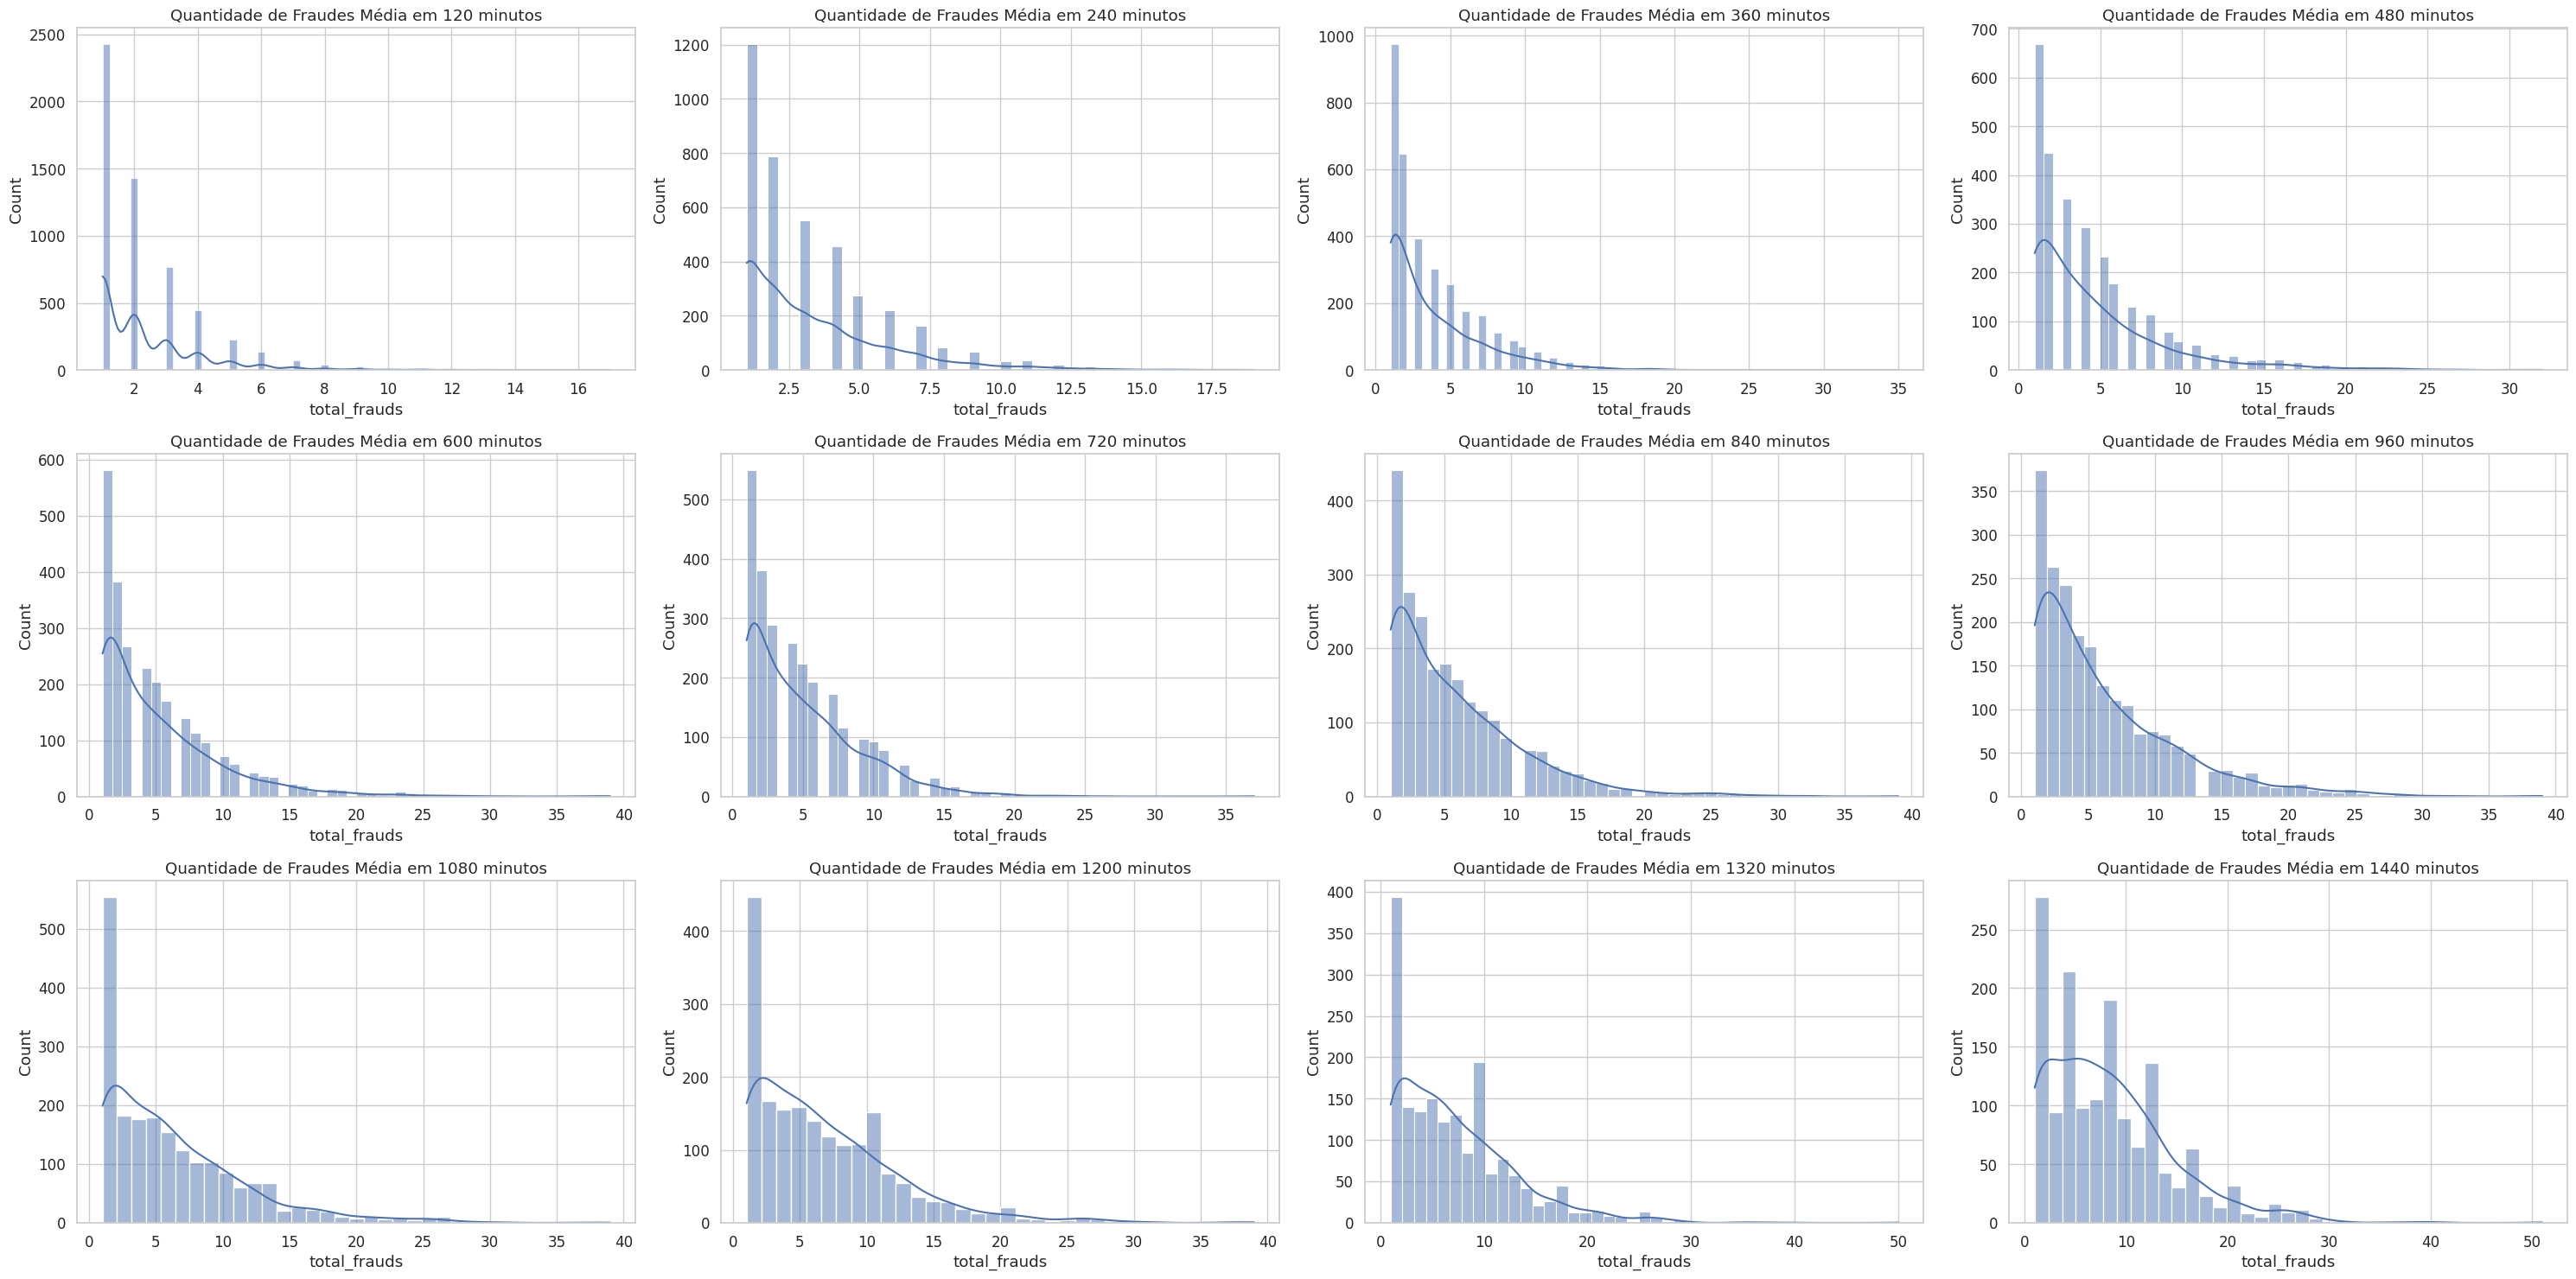

In [26]:
minutes = [120, 240, 360, 480, 600, 720, 840, 960, 1080, 1200, 1320, 1440]
df_time = df.to_pandas()

# Define número de colunas
cols = 4
# Calcula número de linhas necessárias
rows = math.ceil(len(minutes) / cols)

plt.figure(figsize=(30, 5 * rows))

for i, minute in enumerate(minutes):
    plt.subplot(rows, cols, i + 1)
    plt.title(f'Quantidade de Fraudes Média em {minute} minutos')

    df_minutes = pd.DataFrame()
    df_minutes['slide_date'] = df_time['date'].dt.floor(f'{minute}T')
    df_minutes['target'] = df_time['target']

    df_minutes = df_minutes.groupby(by='slide_date').agg({'target': 'sum'}).reset_index()
    df_minutes.columns = ['slide_date', 'total_frauds']

    sns.histplot(df_minutes.query('total_frauds > 0')['total_frauds'], kde=True)

plt.tight_layout()
plt.show()

### Validação com modelos dummies

In [27]:
%%time

builders = []

for minute in tqdm(minutes, desc='Validando periodos'):

  feature_engineering = FraudFeatureEngineer(freq=f'{minute}T')
  df_train = feature_engineering.engineer_features(df.to_pandas())

  builder = BaselineCountingModel(df_train, f'{minute}m', offset=df_train['duration_sec'])
  builder.train()
  builders.append(builder)

Validando periodos:   0%|          | 0/12 [00:00<?, ?it/s]

Carregando e pré-processando dados...
Criando índice temporal...
Adicionando features temporais...
Adicionando features comportamentais...
Adicionando features de risco...
Adicionando features sazonais...
Adicionando features de mudança...
Adicionando features de rede...
Adicionando variável target...
Preenchendo valores ausentes...
Feature engineering concluído!
Carregando e pré-processando dados...
Criando índice temporal...
Adicionando features temporais...
Adicionando features comportamentais...
Adicionando features de risco...
Adicionando features sazonais...
Adicionando features de mudança...
Adicionando features de rede...
Adicionando variável target...
Preenchendo valores ausentes...
Feature engineering concluído!
Carregando e pré-processando dados...
Criando índice temporal...
Adicionando features temporais...
Adicionando features comportamentais...
Adicionando features de risco...
Adicionando features sazonais...
Adicionando features de mudança...
Adicionando features de rede

In [28]:
df_report = pd.concat(list(map(lambda x: x.get_report(criterion='BIC'), builders)))
df_report.query('Best == True')

window         model_name           LLF            BIC           AIC  \
0   120m            Poisson -36279.864649 -401620.478195  72561.729298   
0   240m  Binomial Negativa -18326.590286   36673.136556  36657.180572   
0   360m               ZINB -15182.174553   30393.066756  30370.349106   
0   480m               ZINB -12889.274118   25806.402909  25784.548236   
0   600m  Binomial Negativa -11720.489715   23459.102878  23444.979429   
0   720m               ZINB -11214.848314   22456.335046  22435.696629   
0   840m               ZINB  -9924.798410   19875.772854  19855.596819   
0   960m               ZINB  -9331.161136   18688.097504  18668.322272   
0  1080m               ZINB  -8841.880661   17709.183553  17689.761322   
0  1200m               ZINB  -8272.790206   16570.686492  16551.580413   
0  1320m               ZINB  -7814.074430   15652.968870  15634.148860   
0  1440m  Binomial Negativa  -7375.230552   14766.834033  14754.461104   

   Converged  RMSE_Pearson  Outliers  Pct_resid_gt_2  Pct_resid_gt_3  \
0       True      1.820367    3183.0        7.386350        7.386350   
0       True      0.857834     934.0        4.334710        2.028125   
0       True      0.981048     782.0        5.443787        3.076923   
0       True      0.997509     496.0        4.603676        2.292556   
0       True      0.839985     356.0        4.130410        1.717137   
0       True      0.975135     443.0        6.167340        1.698455   
0       True      0.991349     332.0        5.392236        2.452493   
0       True      0.978741     307.0        5.698905        2.209022   
0       True      0.980844     227.0        4.740029        2.380455   
0       True      0.980266     200.0        4.640371        1.716937   
0       True      0.981212     179.0        4.568657        1.761103   
0       True      0.720857      91.0        2.533408        0.389755   

   Dispersion  df_resid      PseudoR2  RankApplied  Best  
0    3.313813   43092.0  6.661338e-16         True  True  
0    0.735913   21546.0  6.186252e-11         True  True  
0    0.962523   14364.0  5.873857e-12         True  True  
0    0.995117   10773.0 -1.644014e-10         True  True  
0    0.705657    8618.0  4.128919e-11         True  True  
0    0.951021    7182.0 -4.458656e-12         True  True  
0    0.982932    6156.0  2.528544e-11         True  True  
0    0.958111    5386.0 -6.192002e-11         True  True  
0    0.962255    4788.0  5.597012e-11         True  True  
0    0.961144    4309.0  7.743095e-11         True  True  
0    0.963022    3917.0  5.248613e-11         True  True  
0    0.519780    3591.0  1.166518e-10         True  True

In [29]:
df_best_report = df_report.query('Best == True').groupby(by='model_name').agg(window_count=('window', 'count'), bic=('BIC', 'min')).reset_index().sort_values('window_count', ascending=False).reset_index(drop=True)
df_best_report

model_name  window_count            bic
0               ZINB             8   15652.968870
1  Binomial Negativa             3   14766.834033
2            Poisson             1 -401620.478195

In [30]:
df_best_report_index = df_report[(df_report['Best'] == True) & (df_report['model_name'] == df_best_report.loc[0, 'model_name'])].sort_values('BIC', ascending=True).reset_index(drop=True)
df_best_report_index

window model_name           LLF           BIC           AIC  Converged  \
0  1320m       ZINB  -7814.074430  15652.968870  15634.148860       True   
1  1200m       ZINB  -8272.790206  16570.686492  16551.580413       True   
2  1080m       ZINB  -8841.880661  17709.183553  17689.761322       True   
3   960m       ZINB  -9331.161136  18688.097504  18668.322272       True   
4   840m       ZINB  -9924.798410  19875.772854  19855.596819       True   
5   720m       ZINB -11214.848314  22456.335046  22435.696629       True   
6   480m       ZINB -12889.274118  25806.402909  25784.548236       True   
7   360m       ZINB -15182.174553  30393.066756  30370.349106       True   

   RMSE_Pearson  Outliers  Pct_resid_gt_2  Pct_resid_gt_3  Dispersion  \
0      0.981212     179.0        4.568657        1.761103    0.963022   
1      0.980266     200.0        4.640371        1.716937    0.961144   
2      0.980844     227.0        4.740029        2.380455    0.962255   
3      0.978741     307.0        5.698905        2.209022    0.958111   
4      0.991349     332.0        5.392236        2.452493    0.982932   
5      0.975135     443.0        6.167340        1.698455    0.951021   
6      0.997509     496.0        4.603676        2.292556    0.995117   
7      0.981048     782.0        5.443787        3.076923    0.962523   

   df_resid      PseudoR2  RankApplied  Best  
0    3917.0  5.248613e-11         True  True  
1    4309.0  7.743095e-11         True  True  
2    4788.0  5.597012e-11         True  True  
3    5386.0 -6.192002e-11         True  True  
4    6156.0  2.528544e-11         True  True  
5    7182.0 -4.458656e-12         True  True  
6   10773.0 -1.644014e-10         True  True  
7   14364.0  5.873857e-12         True  True

### Seleção da melhor janela de tempo

In [31]:
selected_builder = list(filter(lambda x: x.window == df_best_report_index.loc[0, 'window'], builders))[0]
selected_builder.get_report(criterion='BIC')

window         model_name           LLF           BIC           AIC  \
0  1320m               ZINB  -7814.074430  15652.968870  15634.148860   
1  1320m  Binomial Negativa  -8032.226120  16080.998914  16068.452241   
2  1320m                ZIP  -9466.387063  18949.320800  18936.774126   
3  1320m            Poisson -17019.180282  -4594.214654  34040.360564   

   Converged  RMSE_Pearson  Outliers  Pct_resid_gt_2  Pct_resid_gt_3  \
0       True      0.981212       179        4.568657        1.761103   
1       True      0.765593        94        2.399183        0.765697   
2       True      1.307860       350        8.933129        3.751914   
3       True      2.923676       809       20.648290       15.416029   

   Dispersion  df_resid      PseudoR2  RankApplied   Best  
0    0.963022    3917.0  5.248613e-11         True   True  
1    0.586282    3917.0  4.338485e-11         True  False  
2    1.710934    3917.0  7.399314e-11         True  False  
3    8.550062    3917.0  3.663736e-15         True  False

#### Visualização da distribuição observada dos eventos X modelo dummy

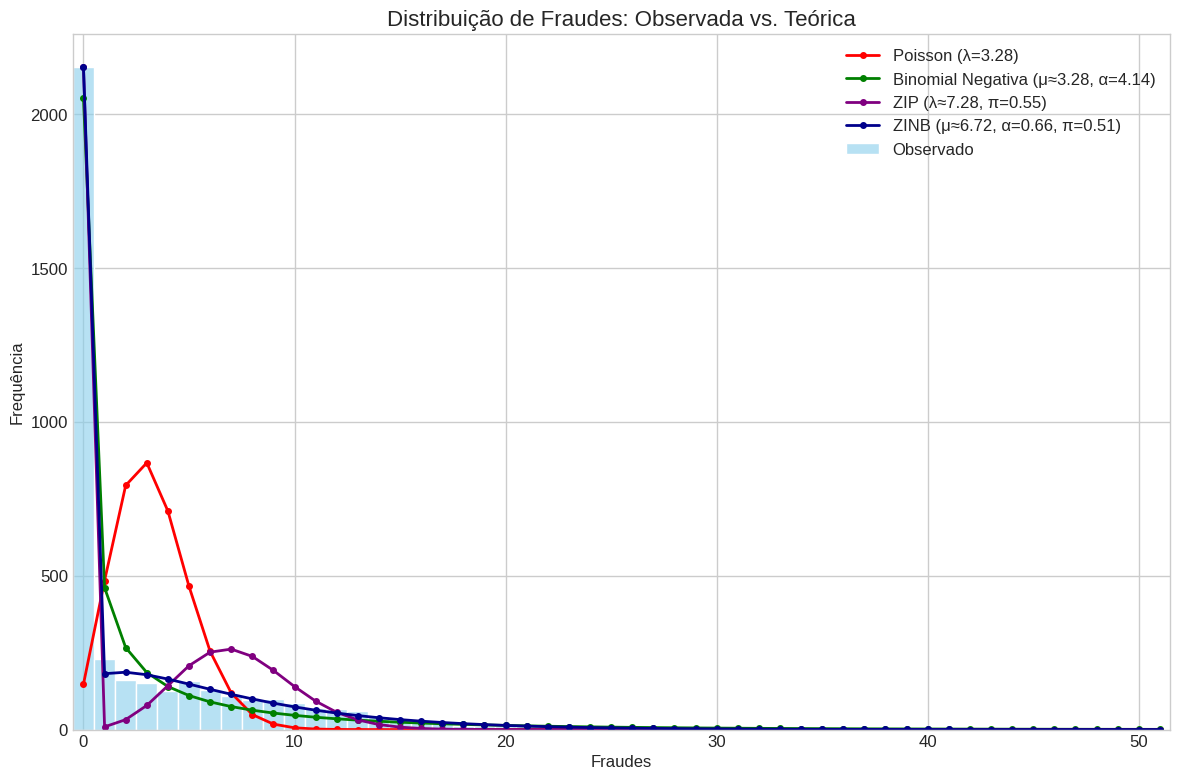

In [32]:
selected_builder.plot_theoretical_distributions()

In [33]:
selected_builder.df.head()

total_transactions  total_amount  chip_ratio  \
2010-01-01 00:00:00                2074      92904.03         0.0   
2010-01-01 22:00:00                1776      92892.85         0.0   
2010-01-02 20:00:00                1963      94943.47         0.0   
2010-01-03 18:00:00                1940      92607.88         0.0   
2010-01-04 16:00:00                1846      92506.13         0.0   

                     duration_sec  transactions_per_seconds  \
2010-01-01 00:00:00       79200.0                  0.026187   
2010-01-01 22:00:00       79200.0                  0.022424   
2010-01-02 20:00:00       79200.0                  0.024785   
2010-01-03 18:00:00       79200.0                  0.024495   
2010-01-04 16:00:00       79200.0                  0.023308   

                     avg_transactions_value  geo_dispersion  merchant_entropy  \
2010-01-01 00:00:00               44.794614       21.218228          5.347912   
2010-01-01 22:00:00               52.304533       20.926476          5.446203   
2010-01-02 20:00:00               48.366516       21.587203          5.430923   
2010-01-03 18:00:00               47.736021       21.610378          5.396481   
2010-01-04 16:00:00               50.111663       20.453615          5.427792   

                     avg_credit_score  error_ratio  ...      hour_cos  \
2010-01-01 00:00:00        714.264224     0.014465  ...  1.000000e+00   
2010-01-01 22:00:00        712.390203     0.016329  ...  8.660254e-01   
2010-01-02 20:00:00        716.460520     0.012736  ...  5.000000e-01   
2010-01-03 18:00:00        714.252577     0.016495  ... -1.836970e-16   
2010-01-04 16:00:00        710.826652     0.010834  ... -5.000000e-01   

                      day_sin   day_cos  is_holiday  \
2010-01-01 00:00:00 -0.433884 -0.900969           1   
2010-01-01 22:00:00 -0.433884 -0.900969           1   
2010-01-02 20:00:00 -0.974928 -0.222521           0   
2010-01-03 18:00:00 -0.781831  0.623490           0   
2010-01-04 16:00:00  0.000000  1.000000           0   

                     change_volume_transaction  velocity_alert  \
2010-01-01 00:00:00                   0.000000               0   
2010-01-01 22:00:00                  -0.143684               0   
2010-01-02 20:00:00                   0.105293               0   
2010-01-03 18:00:00                  -0.011717               0   
2010-01-04 16:00:00                  -0.048454               0   

                     unique_clients  unique_cards  cards_per_client  frauds  
2010-01-01 00:00:00             859          1227          1.428405     0.0  
2010-01-01 22:00:00             825          1121          1.358788     1.0  
2010-01-02 20:00:00             853          1189          1.393904     0.0  
2010-01-03 18:00:00             873          1205          1.380298     1.0  
2010-01-04 16:00:00             842          1168          1.387173     3.0  

[5 rows x 21 columns]

In [34]:
selected_builder.df.describe()

total_transactions   total_amount   chip_ratio  duration_sec  \
count         3918.000000    3918.000000  3918.000000        3918.0   
mean          2162.374681  109295.993520     0.346549       79200.0   
std            184.067293    8242.702358     0.352558           0.0   
min             80.000000    6641.420000     0.000000       79200.0   
25%           2034.250000  103871.902500     0.000000       79200.0   
50%           2162.000000  109096.760000     0.000000       79200.0   
75%           2295.750000  114692.650000     0.705070       79200.0   
max           2616.000000  136957.770000     0.734658       79200.0   

       transactions_per_seconds  avg_transactions_value  geo_dispersion  \
count               3918.000000             3918.000000     3918.000000   
mean                   0.027303               50.688209       21.348138   
std                    0.002324                3.121235        0.300847   
min                    0.001010               40.017571       20.377970   
25%                    0.025685               48.437788       21.150057   
50%                    0.027298               50.300103       21.337290   
75%                    0.028987               52.798466       21.547944   
max                    0.033030               83.017750       22.571104   

       merchant_entropy  avg_credit_score  error_ratio  ...      hour_cos  \
count       3918.000000       3918.000000  3918.000000  ...  3.918000e+03   
mean           5.515102        714.107944     0.015993  ...  2.552323e-04   
std            0.070386          1.389136     0.002788  ...  7.071970e-01   
min            3.991962        708.837862     0.006323  ... -1.000000e+00   
25%            5.470431        713.170399     0.014074  ... -5.000000e-01   
50%            5.510964        714.131208     0.015873  ... -6.123234e-17   
75%            5.558044        715.033008     0.017803  ...  7.745191e-01   
max            5.741147        718.976524     0.027778  ...  1.000000e+00   

           day_sin      day_cos   is_holiday  change_volume_transaction  \
count  3918.000000  3918.000000  3918.000000                3918.000000   
mean     -0.000111    -0.000025     0.028076                   0.009845   
std       0.707344     0.707051     0.165210                   0.447971   
min      -0.974928    -0.900969     0.000000                  -0.958333   
25%      -0.781831    -0.900969     0.000000                  -0.036720   
50%       0.000000    -0.222521     0.000000                  -0.003616   
75%       0.781831     0.623490     0.000000                   0.038934   
max       0.974928     1.000000     1.000000                  27.412500   

       velocity_alert  unique_clients  unique_cards  cards_per_client  \
count     3918.000000     3918.000000   3918.000000       3918.000000   
mean         0.006126      941.621491   1409.708014          1.495187   
std          0.078036       44.058284    104.462481          0.048589   
min          0.000000       74.000000     78.000000          1.054054   
25%          0.000000      917.000000   1344.000000          1.465129   
50%          0.000000      947.000000   1419.000000          1.498418   
75%          0.000000      972.000000   1482.000000          1.529588   
max          1.000000     1027.000000   1642.000000          1.615540   

            frauds  
count  3918.000000  
mean      3.277693  
std       5.293815  
min       0.000000  
25%       0.000000  
50%       0.000000  
75%       5.000000  
max      51.000000  

[8 rows x 21 columns]

#### Correlação dos dados no dataframe da janela selecionada

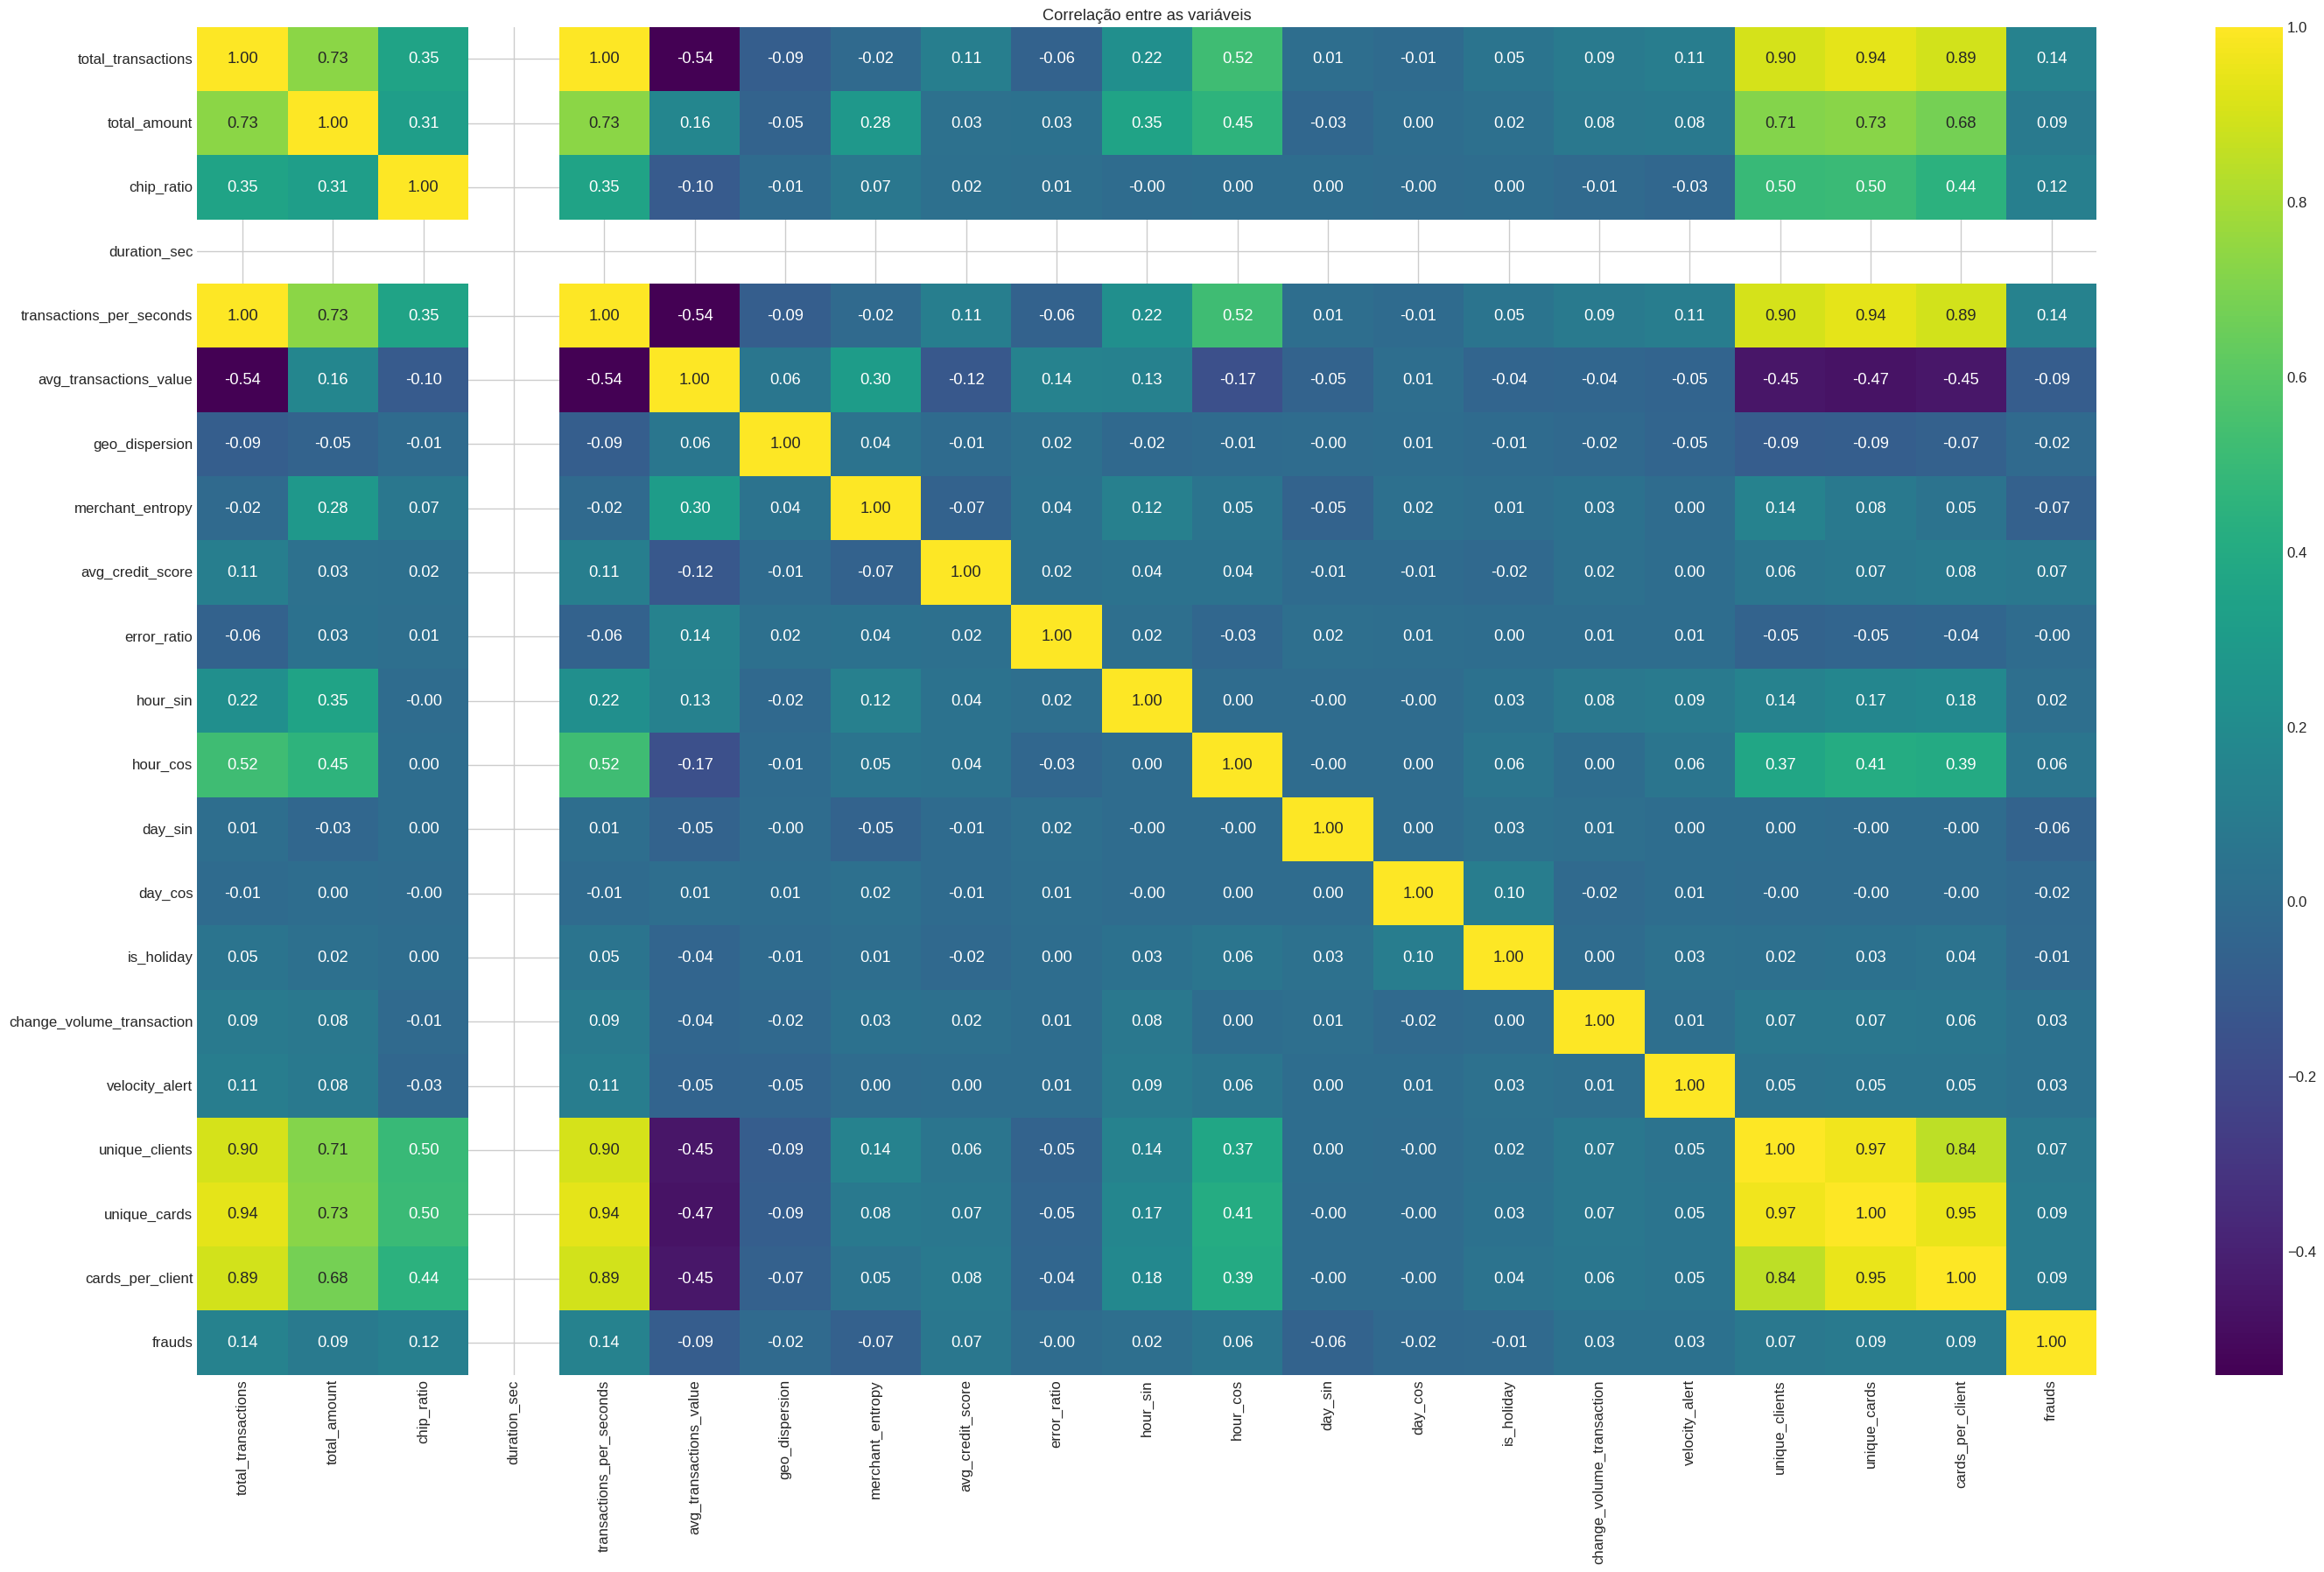

In [35]:
corr = selected_builder.df.corr(numeric_only=True)
plt.figure(figsize=(35,20))
plt.title('Correlação entre as variáveis')

sns.heatmap(corr, annot=True, cmap='viridis', fmt='.2f')

plt.show()

## Modelagem

### **Métricas de Avaliação de Modelos: LLF, AIC e BIC**

Estas métricas são usadas para avaliar e comparar modelos estatísticos, buscando um equilíbrio entre o bom ajuste aos dados e a simplicidade do modelo.

---

### **1. LLF (Log-Likelihood Function / Função de Log-Verossimilhança)**

Mede o quão bem o modelo se ajusta aos dados observados.

* **Foco:** Apenas na qualidade do ajuste.
* **Interpretação:** Quanto **maior** o valor, melhor o modelo explica os dados.
* **Limitação:** Não penaliza a complexidade. Modelos mais complexos quase sempre terão uma LLF maior.

---

### **2. AIC (Akaike Information Criterion / Critério de Informação de Akaike)**

Busca um equilíbrio entre a qualidade do ajuste (LLF) e a complexidade do modelo (número de parâmetros).

* **Fórmula:**
    $$ \text{AIC} = 2k - 2 \ln(\hat{L}) $$
    * $k$: número de parâmetros do modelo.
    * $\ln(\hat{L})$: valor da Log-Verossimilhança.
* **Foco:** Encontrar o melhor modelo para previsões.
* **Interpretação:** O modelo com o **menor** valor de AIC é preferível.

---

### **3. BIC (Bayesian Information Criterion / Critério de Informação Bayesiano)**

Similar ao AIC, mas aplica uma penalidade mais rigorosa à complexidade, especialmente para grandes volumes de dados.

* **Fórmula:**
    $$ \text{BIC} = \ln(n)k - 2 \ln(\hat{L}) $$
    * $n$: número de observações (tamanho da amostra).
    * $k$: número de parâmetros do modelo.
    * $\ln(\hat{L})$: valor da Log-Verossimilhança.
* **Foco:** Encontrar o modelo mais provável de ser o "verdadeiro" gerador dos dados.
* **Interpretação:** O modelo com o **menor** valor de BIC é preferível. Geralmente, seleciona modelos mais simples que o AIC.

---

### **Tabela Resumo**

| Métrica | Foco Principal | Interpretação |
| :--- | :--- | :--- |
| **LLF** | Qualidade do ajuste | Quanto **maior**, melhor |
| **AIC** | Equilíbrio (Ajuste vs. Complexidade) | Quanto **menor**, melhor |
| **BIC** | Equilíbrio (com maior penalidade à complexidade) | Quanto **menor**, melhor |

In [36]:
X = selected_builder.df.copy()
y = X['frauds']

In [37]:
X.describe().T

count           mean          std           min  \
total_transactions         3918.0    2162.374681   184.067293     80.000000   
total_amount               3918.0  109295.993520  8242.702358   6641.420000   
chip_ratio                 3918.0       0.346549     0.352558      0.000000   
duration_sec               3918.0   79200.000000     0.000000  79200.000000   
transactions_per_seconds   3918.0       0.027303     0.002324      0.001010   
avg_transactions_value     3918.0      50.688209     3.121235     40.017571   
geo_dispersion             3918.0      21.348138     0.300847     20.377970   
merchant_entropy           3918.0       5.515102     0.070386      3.991962   
avg_credit_score           3918.0     714.107944     1.389136    708.837862   
error_ratio                3918.0       0.015993     0.002788      0.006323   
hour_sin                   3918.0      -0.000953     0.707196     -1.000000   
hour_cos                   3918.0       0.000255     0.707197     -1.000000   
day_sin                    3918.0      -0.000111     0.707344     -0.974928   
day_cos                    3918.0      -0.000025     0.707051     -0.900969   
is_holiday                 3918.0       0.028076     0.165210      0.000000   
change_volume_transaction  3918.0       0.009845     0.447971     -0.958333   
velocity_alert             3918.0       0.006126     0.078036      0.000000   
unique_clients             3918.0     941.621491    44.058284     74.000000   
unique_cards               3918.0    1409.708014   104.462481     78.000000   
cards_per_client           3918.0       1.495187     0.048589      1.054054   
frauds                     3918.0       3.277693     5.293815      0.000000   

                                     25%           50%            75%  \
total_transactions           2034.250000  2.162000e+03    2295.750000   
total_amount               103871.902500  1.090968e+05  114692.650000   
chip_ratio                      0.000000  0.000000e+00       0.705070   
duration_sec                79200.000000  7.920000e+04   79200.000000   
transactions_per_seconds        0.025685  2.729798e-02       0.028987   
avg_transactions_value         48.437788  5.030010e+01      52.798466   
geo_dispersion                 21.150057  2.133729e+01      21.547944   
merchant_entropy                5.470431  5.510964e+00       5.558044   
avg_credit_score              713.170399  7.141312e+02     715.033008   
error_ratio                     0.014074  1.587302e-02       0.017803   
hour_sin                       -0.866025  0.000000e+00       0.500000   
hour_cos                       -0.500000 -6.123234e-17       0.774519   
day_sin                        -0.781831  0.000000e+00       0.781831   
day_cos                        -0.900969 -2.225209e-01       0.623490   
is_holiday                      0.000000  0.000000e+00       0.000000   
change_volume_transaction      -0.036720 -3.615981e-03       0.038934   
velocity_alert                  0.000000  0.000000e+00       0.000000   
unique_clients                917.000000  9.470000e+02     972.000000   
unique_cards                 1344.000000  1.419000e+03    1482.000000   
cards_per_client                1.465129  1.498418e+00       1.529588   
frauds                          0.000000  0.000000e+00       5.000000   

                                     max  
total_transactions           2616.000000  
total_amount               136957.770000  
chip_ratio                      0.734658  
duration_sec                79200.000000  
transactions_per_seconds        0.033030  
avg_transactions_value         83.017750  
geo_dispersion                 22.571104  
merchant_entropy                5.741147  
avg_credit_score              718.976524  
error_ratio                     0.027778  
hour_sin                        1.000000  
hour_cos                        1.000000  
day_sin                         0.974928  
day_cos                         1.000000  
is_holiday                      1.000

In [38]:
y.value_counts()

frauds
0.0     2154
1.0      228
2.0      160
5.0      159
3.0      152
6.0      129
4.0      127
7.0      108
9.0      100
8.0       97
10.0      85
11.0      69
12.0      67
13.0      59
14.0      45
15.0      32
17.0      27
16.0      26
19.0      13
18.0      12
20.0      11
21.0      11
25.0       9
23.0       7
22.0       7
29.0       4
26.0       4
27.0       4
28.0       3
24.0       3
30.0       2
40.0       1
51.0       1
39.0       1
36.0       1
Name: count, dtype: int64

### Modelo de Regressão de Poisson  

Um GLM para Modelagem de Dados de Contagem

A **Regressão de Poisson** é um modelo da família dos **Modelos Lineares Generalizados (GLMs)**, apropriado para variáveis dependentes representadas por **contagens**, ou seja, números inteiros não negativos que expressam a quantidade de vezes que um determinado evento ocorre dentro de um intervalo fixo de tempo ou espaço.

---

### Estrutura dos Dados

Variáveis de contagem apresentam as seguintes características:

- Assumem valores inteiros e não negativos: $0, 1, 2, \dots$.
- Representam frequências de ocorrência de um evento.
- Apresentam, sob hipótese da Poisson, **média e variância iguais**: $\mathbb{E}[Y] = \mathrm{Var}(Y) = \lambda$.

---

### Distribuição de Poisson

A variável aleatória $Y$ segue uma distribuição de Poisson quando sua probabilidade de assumir o valor $k$ é dada por:

$$
P(Y = k) = \frac{\lambda^k e^{-\lambda}}{k!}, \quad k = 0, 1, 2, \dots
$$

onde:

- $\lambda > 0$ é o parâmetro da distribuição, que representa a média e a variância;
- $e$ é a base do logaritmo natural;
- $k!$ é o fatorial de $k$.

---

### Formulação da Regressão de Poisson

A regressão de Poisson modela o valor esperado da variável dependente $Y_i$ como uma função exponencial de uma combinação linear de variáveis explicativas.

Assume-se que:

$$
Y_i \sim \text{Poisson}(\lambda_i)
$$

com:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, de forma vetorial:

$$
\log(\lambda_i) = x_i^\top \beta
$$

Assim, a média condicional esperada da variável resposta é dada por:

$$
\lambda_i = \exp(x_i^\top \beta)
$$

---

### Propriedade de Equidispersão

No modelo de Poisson, assume-se que:

$$
\mathrm{Var}(Y_i) = \mathbb{E}[Y_i] = \lambda_i
$$

Esse equilíbrio entre média e variância é conhecido como **equidispersão**. Caso essa condição não seja atendida (por exemplo, se a variância for significativamente maior que a média), o modelo torna-se inadequado e pode exigir alternativas como o modelo **binomial negativo**.

---

### Interpretação dos Coeficientes

Os coeficientes $\beta_j$ da regressão de Poisson são interpretados em termos da **razão de taxas**. O modelo log-linear define:

$$
\log(\lambda_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Portanto, exponenciando $\beta_j$:

$$
e^{\beta_j}
$$

representa o fator pelo qual a taxa esperada de ocorrência $\lambda_i$ é multiplicada a cada aumento unitário em $x_{ij}$, mantendo constantes os demais preditores.

---

### Estimação

A estimação dos parâmetros do modelo é realizada por **máxima verossimilhança**, considerando a função de verossimilhança derivada da distribuição de Poisson. A convergência do modelo depende da estrutura dos dados e da ausência de sobredispersão relevante.


#### Validação de presuposto

Os dados devem apresentar **equidispersão**, ou seja, média igual a variância.

In [39]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  3.277693  28.024475

Existe uma diferença muito grande entre a média e a variancia referente a variável alvo, indicando possível subdispersão nos dados.

#### Implementação dos modelos

##### Completo

In [40]:
formula = "frauds ~ " + ' + '.join(X.drop(columns=['frauds', 'duration_sec']).columns)
formula

'frauds ~ total_transactions + total_amount + chip_ratio + transactions_per_seconds + avg_transactions_value + geo_dispersion + merchant_entropy + avg_credit_score + error_ratio + hour_sin + hour_cos + day_sin + day_cos + is_holiday + change_volume_transaction + velocity_alert + unique_clients + unique_cards + cards_per_client'

In [41]:
modelo_poisson  = smf.glm(formula=formula, data=X, family=sm.families.Poisson(), offset=np.log(X['duration_sec'])).fit()

In [42]:
modelo_poisson.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 3918
Model:                            GLM   Df Residuals:                     3899
Model Family:                 Poisson   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15583.
Date:                Wed, 27 Aug 2025   Deviance:                       24940.
Time:                        13:22:32   Pearson chi2:                 2.98e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5196
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     6.6057      7.317      0.903      0.367      -7.735      20.946
total_transactions            0.0005      0.001      0.553      0.580      -0.001       0.002
total_amount                  0.0001    1.6e-05      8.472      0.000       0.000       0.000
chip_ratio                    1.0662      0.037     28.742      0.000       0.993       1.139
transactions_per_seconds    6.08e-09    1.1e-08      0.553      0.580   -1.55e-08    2.76e-08
avg_transactions_value       -0.2809      0.035     -8.103      0.000      -0.349      -0.213
geo_dispersion               -0.0521      0.030     -1.732      0.083      -0.111       0.007
merchant_entropy             -0.1898      0.161     -1.179      0.239      -0.505       0.126
avg_credit_score              0.0387      0.007      5.933      0.000       0.026       0.052
error_ratio                   4.2304      3.260      1.298      0.194      -2.159      10.620
hour_sin                     -0.1216      0.015     -8.286      0.000      -0.150      -0.093
hour_cos                     -0.1589      0.018     -9.033      0.000      -0.193      -0.124
day_sin                      -0.1535      0.013    -12.251      0.000      -0.178      -0.129
day_cos                      -0.0428      0.013     -3.379      0.001      -0.068      -0.018
is_holiday                   -0.1749      0.057     -3.054      0.002      -0.287      -0.063
change_volume_transaction     0.0321      0.012      2.594      0.009       0.008       0.056
velocity_alert               -0.1199      0.089     -1.342      0.180      -0.295       0.055
unique_clients               -0.0333      0.004     -7.688      0.000      -0.042      -0.025
unique_cards                  0.0088      0.003      2.875      0.004       0.003       0.015
cards_per_client            -16.9537      2.838     -5.974      0.000     -22.516     -11.392
=============================================================================================
"""

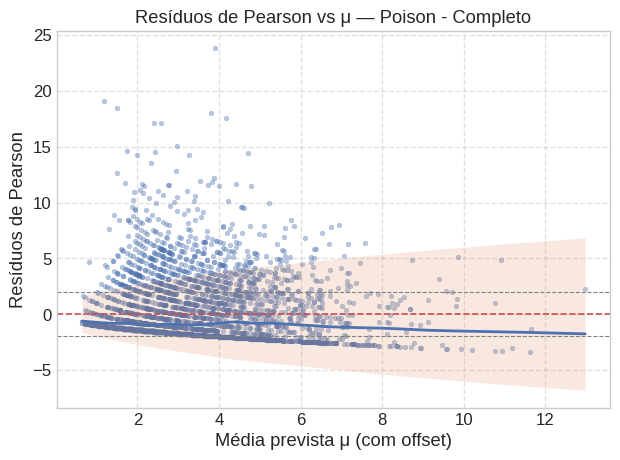

In [43]:
overdisp_plot_enhanced(modelo_poisson, 'Poison - Completo')

In [44]:
diagnosticar_dispersao_ct(modelo_poisson, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(8.12005966140313),
 'p_valor': np.float64(6.182226892510437e-16)}

O gráfico acima demonstra como o modelo tem dificuldade para prever os valores. O um padrão de funil no dados demonstra que o presuposto de equidispersão não foi atendido, e a variância dos resíduos não é constante em relação à média prevista, sendo muito maior para contagens baixas.

In [45]:
overdisp(modelo_poisson, X)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.074     
Dependent Variable:     ystar            AIC:                         35289.9346
Date:                   2025-08-27 13:22 BIC:                         35296.2080
No. Observations:       3918             Log-Likelihood:              -17644.   
Df Model:               1                F-statistic:                 312.4     
Df Residuals:           3917             Prob (F-statistic):          2.56e-67  
R-squared (uncentered): 0.074            Scale:                       477.71    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.6910         0.0957       17.6740       0.0000       1.5034       1.8786
--

O teste evidencia o ponto já validado inicialmente do presuposto. O modelo não atende a capacidade de overdispersion.

##### Stepwise

In [46]:
modelo_poisson_stepwise = stepwise(modelo_poisson, pvalue_limit=0.05)
modelo_poisson_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_transactions') + Q('total_amount') + Q('chip_ratio') + Q('transactions_per_seconds') + Q('avg_transactions_value') + Q('geo_dispersion') + Q('merchant_entropy') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos') + Q('day_sin') + Q('day_cos') + Q('is_holiday') + Q('change_volume_transaction') + Q('velocity_alert') + Q('unique_clients') + Q('unique_cards') + Q('cards_per_client')

 Family type...: 
 Poisson

 Discarding atribute "Q('transactions_per_seconds')" with p-value equal to 0.5805121514441425 

Estimating model...: 
 frauds ~ Q('total_transactions') + Q('total_amount') + Q('chip_ratio') + Q('avg_transactions_value') + Q('geo_dispersion') + Q('merchant_entropy') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos') + Q('day_sin') + Q('day_cos') + Q('is_holiday') + Q('change_volume_transaction') + Q('velocity_alert') + Q('unique_clients') + Q('unique_cards') + Q('cards_per_c

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 3918
Model:                            GLM   Df Residuals:                     3904
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15587.
Date:                Wed, 27 Aug 2025   Deviance:                       24948.
Time:                        13:22:39   Pearson chi2:                 2.99e+04
No. Iterations:                     6   Pseudo R-squ. (CS):             0.5186
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         19.4944      5.183      3.761      0.000       9.336      29.653
Q('total_amount')                  0.0001   3.48e-06     41.345      0.000       0.000       0.000
Q('chip_ratio')                    1.0607      0.037     28.794      0.000       0.988       1.133
Q('avg_transactions_value')       -0.3005      0.007    -43.020      0.000      -0.314      -0.287
Q('avg_credit_score')              0.0394      0.007      6.038      0.000       0.027       0.052
Q('hour_sin')                     -0.1245      0.015     -8.576      0.000      -0.153      -0.096
Q('hour_cos')                     -0.1607      0.017     -9.397      0.000      -0.194      -0.127
Q('day_sin')                      -0.1521      0.013    -12.164      0.000      -0.177      -0.128
Q('day_cos')                      -0.0431      0.013     -3.415      0.001      -0.068      -0.018
Q('is_holiday')                   -0.1745      0.057     -3.053      0.002      -0.287      -0.063
Q('change_volume_transaction')     0.0327      0.012      2.636      0.008       0.008       0.057
Q('unique_clients')               -0.0366      0.002    -18.263      0.000      -0.041      -0.033
Q('unique_cards')                  0.0111      0.001      7.755      0.000       0.008       0.014
Q('cards_per_client')            -19.1006      1.506    -12.686      0.000     -22.051     -16.150
==================================================================================================
"""

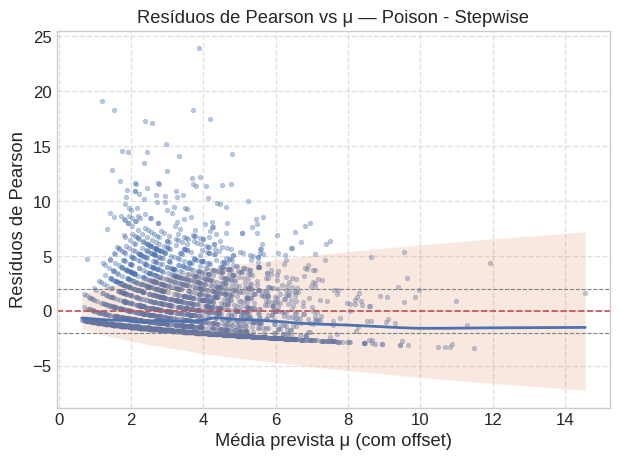

In [47]:
overdisp_plot_enhanced(modelo_poisson_stepwise, 'Poison - Stepwise')

In [48]:
diagnosticar_dispersao_ct(modelo_poisson_stepwise, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(7.898229900478789),
 'p_valor': np.float64(3.645780667324367e-15)}

O gráfico apresenta o mesmo problema relatado no modelo completo, não atendendo o critério de equidispersão.

In [49]:
overdisp(modelo_poisson_stepwise, X)

Estimating model...: 
 GLM
                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.073     
Dependent Variable:     ystar            AIC:                         35322.5617
Date:                   2025-08-27 13:22 BIC:                         35328.8350
No. Observations:       3918             Log-Likelihood:              -17660.   
Df Model:               1                F-statistic:                 309.6     
Df Residuals:           3917             Prob (F-statistic):          9.23e-67  
R-squared (uncentered): 0.073            Scale:                       481.70    
--------------------------------------------------------------------------------------
            Coef.        Std.Err.          t          P>|t|        [0.025       0.975]
--------------------------------------------------------------------------------------
lmbda       1.6905         0.0961       17.5958       0.0000       1.5021       1.8789
--

### Modelo de Regressão Binomial Negativa  

Um GLM para Dados de Contagem com Sobredispersão

A **Regressão Binomial Negativa** é uma extensão do Modelo de Poisson, indicada quando os dados de contagem apresentam **sobredispersão** — ou seja, a variância é significativamente maior que a média. Esse modelo pertence à família dos Modelos Lineares Generalizados (GLMs) e é recomendado quando a suposição de equidispersão da Poisson não é atendida.

---

### Distribuição Binomial Negativa

Na parametrização usada em modelagem de contagem, a variável aleatória $Y$ segue a distribuição:

$$
Y \sim \text{Binomial Negativa}(\mu, \theta)
$$

com média condicional $\mu$ e parâmetro de dispersão $\theta$. A variância assume a forma:

$$
\mathrm{Var}(Y) = \mu + \frac{\mu^2}{\theta}
$$

onde:

- $\mu > 0$ é a média esperada condicional de $Y$;
- $\theta > 0$ é o parâmetro de dispersão, também chamado de "tamanho" ou "alpha";
- Para $\theta \to \infty$, o modelo converge para a Poisson, reduzindo a variância a $\mu$.

---

### Estrutura do Modelo

O objetivo é expressar a média condicional $\mu_i$ da observação $i$ por meio de uma combinação linear dos preditores $x_i$, garantindo positividade com a função de ligação logaritmo:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \beta_2 x_{i2} + \dots + \beta_p x_{ip}
$$

Ou, compactamente:

$$
\log(\mu_i) = x_i^\top \beta
$$

Portanto, a média esperada é calculada por:

$$
\mu_i = \exp(x_i^\top \beta)
$$

---

### Variância Condicional

A diferença crucial em relação à Poisson está no termo adicional da variância:

$$
\mathrm{Var}(Y_i) = \mu_i + \frac{\mu_i^2}{\theta}
$$

Esse termo permite capturar a sobredispersão observada nos dados, com variância aumentando mais rapidamente do que a média.

---

### Significado dos Coeficientes

Os coeficientes $\beta_j$ mantêm a interpretação em termos de log‑média:

$$
\log(\mu_i) = \beta_0 + \sum_{j=1}^{p} \beta_j x_{ij}
$$

Exponenciando $\beta_j$, temos:

$$
e^{\beta_j}
$$

que representa o **fator multiplicativo** na média esperada $\mu_i$ para cada aumento unitário em $x_{ij}$, mantendo os demais preditores constantes.

---

### Estimação por Máxima Verossimilhança

A estimação envolve ajuste simultâneo de $\beta$ e $\theta$ por máxima verossimilhança. A presença do parâmetro extra permite flexibilidade para se adequar a diferentes níveis de dispersão nos dados.


#### Validação de presuposto

Os dados devem apresentar **sobredispersão**, ou seja, variância maior que a média.

In [50]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  3.277693  28.024475

#### Implementação dos modelos

##### Completo

In [51]:
modelo_binomial = smf.glm(formula=formula, data=X, family=sm.families.NegativeBinomial(), offset=np.log(X['duration_sec'])).fit()
modelo_binomial.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 3918
Model:                            GLM   Df Residuals:                     3899
Model Family:        NegativeBinomial   Df Model:                           18
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8730.5
Date:                Wed, 27 Aug 2025   Deviance:                       7691.4
Time:                        13:22:44   Pearson chi2:                 7.77e+03
No. Iterations:                    52   Pseudo R-squ. (CS):             0.1778
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                    22.8793     16.243      1.409      0.159      -8.957      54.716
total_transactions           -0.0014      0.002     -0.708      0.479      -0.005       0.002
total_amount                  0.0002   3.64e-05      4.939      0.000       0.000       0.000
chip_ratio                    1.2556      0.074     17.021      0.000       1.111       1.400
transactions_per_seconds  -1.764e-08   2.49e-08     -0.709      0.478   -6.64e-08    3.11e-08
avg_transactions_value       -0.3767      0.078     -4.829      0.000      -0.530      -0.224
geo_dispersion               -0.0703      0.063     -1.116      0.265      -0.194       0.053
merchant_entropy             -0.7067      0.336     -2.102      0.036      -1.366      -0.048
avg_credit_score              0.0458      0.014      3.326      0.001       0.019       0.073
error_ratio                   5.1470      6.830      0.754      0.451      -8.240      18.534
hour_sin                     -0.1197      0.031     -3.879      0.000      -0.180      -0.059
hour_cos                     -0.1647      0.036     -4.537      0.000      -0.236      -0.094
day_sin                      -0.1968      0.027     -7.386      0.000      -0.249      -0.145
day_cos                      -0.0781      0.027     -2.930      0.003      -0.130      -0.026
is_holiday                   -0.1470      0.116     -1.263      0.206      -0.375       0.081
change_volume_transaction     0.0176      0.039      0.448      0.654      -0.059       0.094
velocity_alert               -0.2960      0.234     -1.263      0.206      -0.755       0.163
unique_clients               -0.0478      0.010     -4.853      0.000      -0.067      -0.029
unique_cards                  0.0176      0.007      2.546      0.011       0.004       0.031
cards_per_client            -25.5226      6.416     -3.978      0.000     -38.098     -12.947
=============================================================================================
"""

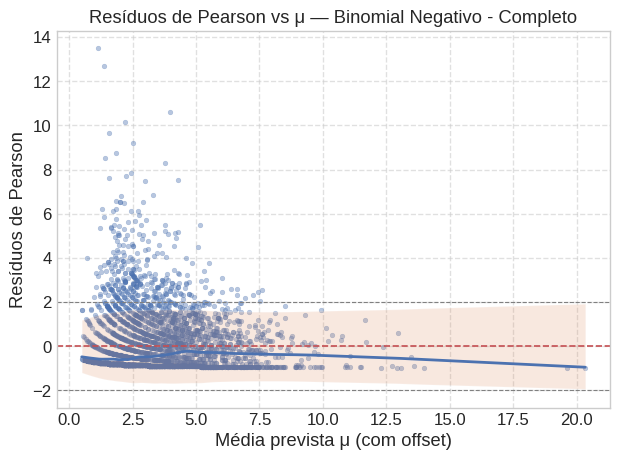

In [52]:
overdisp_plot_enhanced(modelo_binomial, 'Binomial Negativo - Completo')

In [53]:
diagnosticar_dispersao_ct(modelo_binomial, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(11.173837148008111),
 'p_valor': np.float64(1.4740404141449114e-28)}

O gráfico de dispersão de residuos demonstra que o modelo conseguiu capturar melhor a relação dos dados uma vez que o presuposto do modelo foi atendido. No entanto nota-se que o modelo teve um problema com outlier, indicando que algum comportamento não foi corretamente mapeado. A alta concentração no eixo vertical proximo a zero pode indicar que o modelo esteja tendo dificuldades para identificar quando a classificação seja realmente um zero estrutural.

##### Stepwise

In [54]:
modelo_binomial_stepwise = stepwise(modelo_binomial, pvalue_limit=0.05)
modelo_binomial_stepwise.summary()

Regression type: GLM 

Estimating model...: 
 frauds ~ Q('total_transactions') + Q('total_amount') + Q('chip_ratio') + Q('transactions_per_seconds') + Q('avg_transactions_value') + Q('geo_dispersion') + Q('merchant_entropy') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos') + Q('day_sin') + Q('day_cos') + Q('is_holiday') + Q('change_volume_transaction') + Q('velocity_alert') + Q('unique_clients') + Q('unique_cards') + Q('cards_per_client')

 Family type...: 
 Negative Binomial

 Discarding atribute "Q('change_volume_transaction')" with p-value equal to 0.6539169436867338 

Estimating model...: 
 frauds ~ Q('total_transactions') + Q('total_amount') + Q('chip_ratio') + Q('transactions_per_seconds') + Q('avg_transactions_value') + Q('geo_dispersion') + Q('merchant_entropy') + Q('avg_credit_score') + Q('error_ratio') + Q('hour_sin') + Q('hour_cos') + Q('day_sin') + Q('day_cos') + Q('is_holiday') + Q('velocity_alert') + Q('unique_clients') + Q('unique_cards') + Q('c

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 frauds   No. Observations:                 3918
Model:                            GLM   Df Residuals:                     3905
Model Family:        NegativeBinomial   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8733.3
Date:                Wed, 27 Aug 2025   Deviance:                       7697.1
Time:                        13:22:47   Pearson chi2:                 7.79e+03
No. Iterations:                    56   Pseudo R-squ. (CS):             0.1766
Covariance Type:            nonrobust                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                      24.2910     10.934      2.222      0.026       2.860      45.722
Q('total_amount')               0.0002   7.62e-06     20.022      0.000       0.000       0.000
Q('chip_ratio')                 1.2474      0.073     17.049      0.000       1.104       1.391
Q('avg_transactions_value')    -0.3180      0.016    -20.392      0.000      -0.349      -0.287
Q('merchant_entropy')          -0.7218      0.333     -2.166      0.030      -1.375      -0.069
Q('avg_credit_score')           0.0465      0.014      3.389      0.001       0.020       0.073
Q('hour_sin')                  -0.1211      0.031     -3.932      0.000      -0.181      -0.061
Q('hour_cos')                  -0.1702      0.036     -4.773      0.000      -0.240      -0.100
Q('day_sin')                   -0.1987      0.027     -7.463      0.000      -0.251      -0.147
Q('day_cos')                   -0.0810      0.026     -3.063      0.002      -0.133      -0.029
Q('unique_clients')            -0.0425      0.005     -8.830      0.000      -0.052      -0.033
Q('unique_cards')               0.0140      0.003      4.208      0.000       0.007       0.021
Q('cards_per_client')         -22.2459      3.465     -6.420      0.000     -29.037     -15.455
===============================================================================================
"""

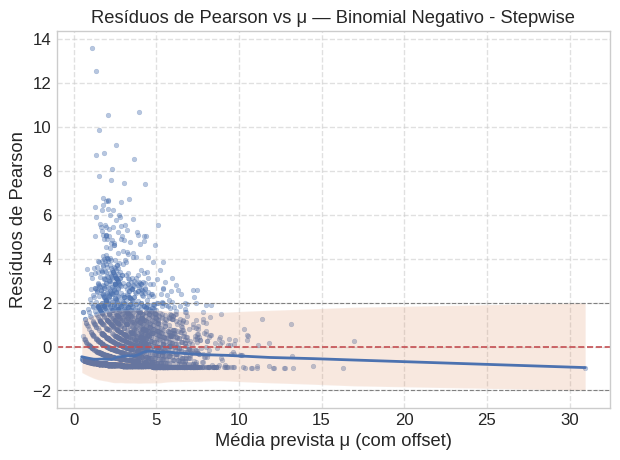

In [55]:
overdisp_plot_enhanced(modelo_binomial_stepwise, 'Binomial Negativo - Stepwise')

In [56]:
diagnosticar_dispersao_ct(modelo_binomial_stepwise, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(14.756544067743743),
 'p_valor': np.float64(5.315837121668149e-48)}

O modelo stepwise apresenta o mesmo comportamento em relação ao modelo completo.

### Modelo Zero-Inflated Poisson (ZIP)  

Modelagem de Dados de Contagem com Excesso de Zeros

O **Modelo Zero-Inflated Poisson (ZIP)** é uma extensão do modelo de regressão de Poisson, utilizado quando os dados de contagem apresentam uma **frequência excessiva de zeros**, superior àquela esperada pela distribuição de Poisson. Esse tipo de modelo permite separar o processo gerador de zeros do processo de contagem positivo, proporcionando uma abordagem mais flexível para lidar com esse tipo de estrutura nos dados.

---

### Estrutura do ZIP

O modelo ZIP assume que os dados são gerados por **dois processos distintos**:

1. Um processo binário (discreto), que determina se a observação pertence à **parte estrutural de zeros** (com probabilidade $\pi_i$);
2. Um processo de contagem, que segue uma **distribuição de Poisson** com parâmetro $\lambda_i$, para as observações que **não pertencem** à parte estrutural de zeros (com probabilidade $1 - \pi_i$).

A distribuição de probabilidade para $Y_i$ no modelo ZIP é definida como:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot e^{-\lambda_i}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \frac{\lambda_i^k e^{-\lambda_i}}{k!}, \quad \text{para } k = 1, 2, 3, \dots
$$

---

### Componentes do Modelo

O ZIP envolve duas submodelagens:

#### 1. Modelo para contagem (Poisson)

A média esperada da parte de contagem é modelada com função de ligação logarítmica:

$$
\log(\lambda_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\lambda_i = \exp(x_i^\top \beta)
$$

#### 2. Modelo logístico para inflação de zeros

A probabilidade $\pi_i$ de uma observação pertencer à parte inflacionada de zeros é modelada via regressão logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

onde:

- $x_i$ é o vetor de preditores da parte Poisson (contagem);
- $z_i$ é o vetor de preditores da parte binária (zero inflacionado), que pode coincidir ou não com $x_i$;
- $\beta$ e $\gamma$ são os vetores de coeficientes de cada parte do modelo.

---

### Interpretação dos Coeficientes

#### Parte de contagem (Poisson):

Os coeficientes $\beta_j$ representam o **efeito logarítmico** sobre a taxa de contagem, tal como na regressão de Poisson. A razão de taxas é dada por:

$$
e^{\beta_j}
$$

e indica o multiplicador da média esperada de eventos para uma unidade adicional em $x_{ij}$.

#### Parte de inflação de zeros (logística):

Os coeficientes $\gamma_j$ representam o **efeito log-odds** sobre a probabilidade de que a observação pertença à parte estrutural de zeros. A exponenciação dos coeficientes fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros é feita por **máxima verossimilhança**, utilizando uma função composta que combina as verossimilhanças das partes Poisson e logística. O processo é iterativo e requer inicialização adequada dos parâmetros.

---

### Utilização

O modelo ZIP é adequado para situações em que:

- A variável de contagem apresenta um **excesso de zeros** não compatível com a distribuição de Poisson;
- Há **dois mecanismos distintos** para geração de zeros: um processo estrutural e outro aleatório (via Poisson);
- Deseja-se identificar **fatores associados à presença estrutural de zeros**, além da contagem em si.

---

### Considerações

- A escolha entre o modelo de Poisson, Binomial Negativa e ZIP deve ser guiada por testes de sobredispersão e verificação do excesso de zeros nos dados.
- O modelo ZIP permite maior flexibilidade e interpretação, porém requer cuidado na separação adequada dos preditores entre as duas partes do modelo.

#### Validação de presuposto

Os dados devem apresentar **equidispersão**, ou seja, média igual a variância.

In [57]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  3.277693  28.024475

Existe uma diferença muito grande entre a média e a variancia referente a variável alvo, indicando possível subdispersão nos dados.

##### Completo

In [58]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy()
X1 = sm.add_constant(X1)

In [59]:
modelo_zip = sm.ZeroInflatedPoisson(y, X1, exog_infl=X1, offset=np.log(X['duration_sec'])).fit(disp=False) # , method='lbfgs', cov_type='HC1'
modelo_zip.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                  frauds   No. Observations:                 3918
Model:             ZeroInflatedPoisson   Df Residuals:                     3899
Method:                            MLE   Df Model:                           18
Date:                 Wed, 27 Aug 2025   Pseudo R-squ.:                  -5478.
Time:                         13:22:55   Log-Likelihood:            -5.1864e+07
converged:                       False   LL-Null:                       -9466.4
Covariance Type:             nonrobust   LLR p-value:                     1.000
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
inflate_const                         0.1000        nan        nan        nan         nan         nan
inflate_total_transactions            0.1000        nan        nan        nan         nan         nan
inflate_total_amount                  0.1000        nan        nan        nan         nan         nan
inflate_chip_ratio                    0.1000        nan        nan        nan         nan         nan
inflate_transactions_per_seconds      0.1000        nan        nan        nan         nan         nan
inflate_avg_transactions_value        0.1000        nan        nan        nan         nan         nan
inflate_geo_dispersion                0.1000        nan        nan        nan         nan         nan
inflate_merchant_entropy              0.1000        nan        nan        nan         nan         nan
inflate_avg_credit_score              0.1000        nan        nan        nan         nan         nan
inflate_error_ratio                   0.1000        nan        nan        nan         nan         nan
inflate_hour_sin                      0.1000        nan        nan        nan         nan         nan
inflate_hour_cos                      0.1000        nan        nan        nan         nan         nan
inflate_day_sin                       0.1000        nan        nan        nan         nan         nan
inflate_day_cos                       0.1000        nan        nan        nan         nan         nan
inflate_is_holiday                    0.1000        nan        nan        nan         nan         nan
inflate_change_volume_transaction     0.1000        nan        nan        nan         nan         nan
inflate_velocity_alert                0.1000        nan        nan        nan         nan         nan
inflate_unique_clients                0.1000        nan        nan        nan         nan         nan
inflate_unique_cards                  0.1000        nan        nan        nan         nan         nan
inflate_cards_per_client              0.1000        nan        nan        nan         nan         nan
const                               -10.4324        nan        nan        nan         nan         nan
total_transactions                    0.0003        nan        nan        nan         nan         nan
total_amount                         -0.0365        nan        nan        nan         nan         nan
chip_ratio                            0.0011        nan        nan        nan         nan         nan
transactions_per_seconds              0.0010        nan        nan        nan         nan         nan
avg_transactions_value                0.0010        nan        nan        nan         nan         nan
geo_dispersion                        0.0010        nan        nan        nan         nan         nan
merchant_entropy                      0.0010        nan        nan        nan         nan         nan
avg_credit_score                      0.0008        nan        nan    

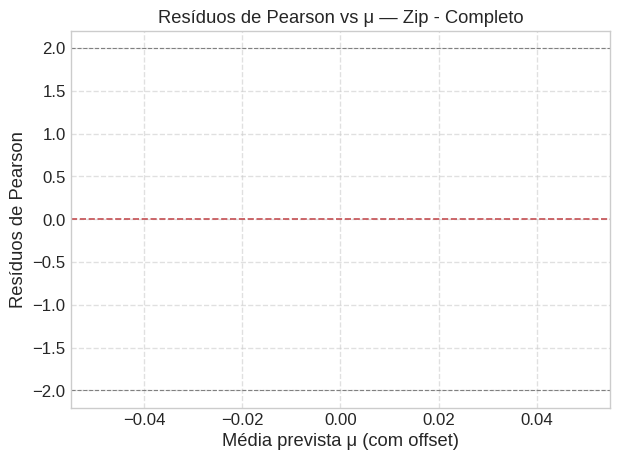

In [60]:
overdisp_plot_enhanced(modelo_zip, 'Zip - Completo')

In [61]:
diagnosticar_dispersao_ct(modelo_zip, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: nan
Resultado (α = 0.05): Falha em rejeitar a hipótese nula.
Conclusão: O pressuposto de dispersão do modelo é considerado adequado.
-------------------------------------------------------------


{'estatistica_t': np.float64(nan), 'p_valor': np.float64(nan)}

Igual ao modelo Poisson, o modelo ZIP apresenta problemas de sobredispersão, quando a média é menor que a variância. O modelo tem diculdades para modelar os componentes de contagem e zeros estruturais uma vez que o presuposto do modelo Poisson não foi atendido e todos as features foram incluídas em ambos componentes.

In [62]:
vuong_test(modelo_poisson, modelo_zip)

         Current function value: 86012532208273445121627663216050438244663296.000000
         Iterations: 35
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: nan
p-value: nan

==================Result======================== 

H0: Indicates no inflation of zeros at 95% confidence level


Conforme teste de Vuong, é possível confirmar que os dados estão com inflação de zeros, sendo assim, o modelo ZIP acaba sendo indicado para esse problema em questão da inflação de zeros.

##### Stepwise

In [63]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy()

In [67]:
step_wise = StepwiseZeroInflated(
    alpha=0.05,
    model_type='ZIP',
    selection_criterion='BIC',
    verbose=False,
    convergence_strictness='low',
    shuffle_features=True,
    shuffle_random_state=45,
    feature_groups=[['hour_sin', 'hour_cos'], ['day_sin', 'day_cos']]
)
random_selector_zip = RandomFeatureSelector(step_wise, max_features=0.75, random_state=45, feature_groups=[['hour_sin', 'hour_cos'], ['day_sin', 'day_cos']])
random_selector_zip.fit(X1, y, np.log(X['duration_sec']))

RandomFeatureSelector(estimator=StepwiseZeroInflated(convergence_strictness='low',
                                                     feature_groups=[['hour_sin',
                                                                      'hour_cos'],
                                                                     ['day_sin',
                                                                      'day_cos']],
                                                     selection_criterion='BIC',
                                                     shuffle_features=True,
                                                     shuffle_random_state=45,
                                                     verbose=False),
                      feature_groups=[['hour_sin', 'hour_cos'],
                                      ['day_sin', 'day_cos']],
                      max_features=0.75, random_state=45)

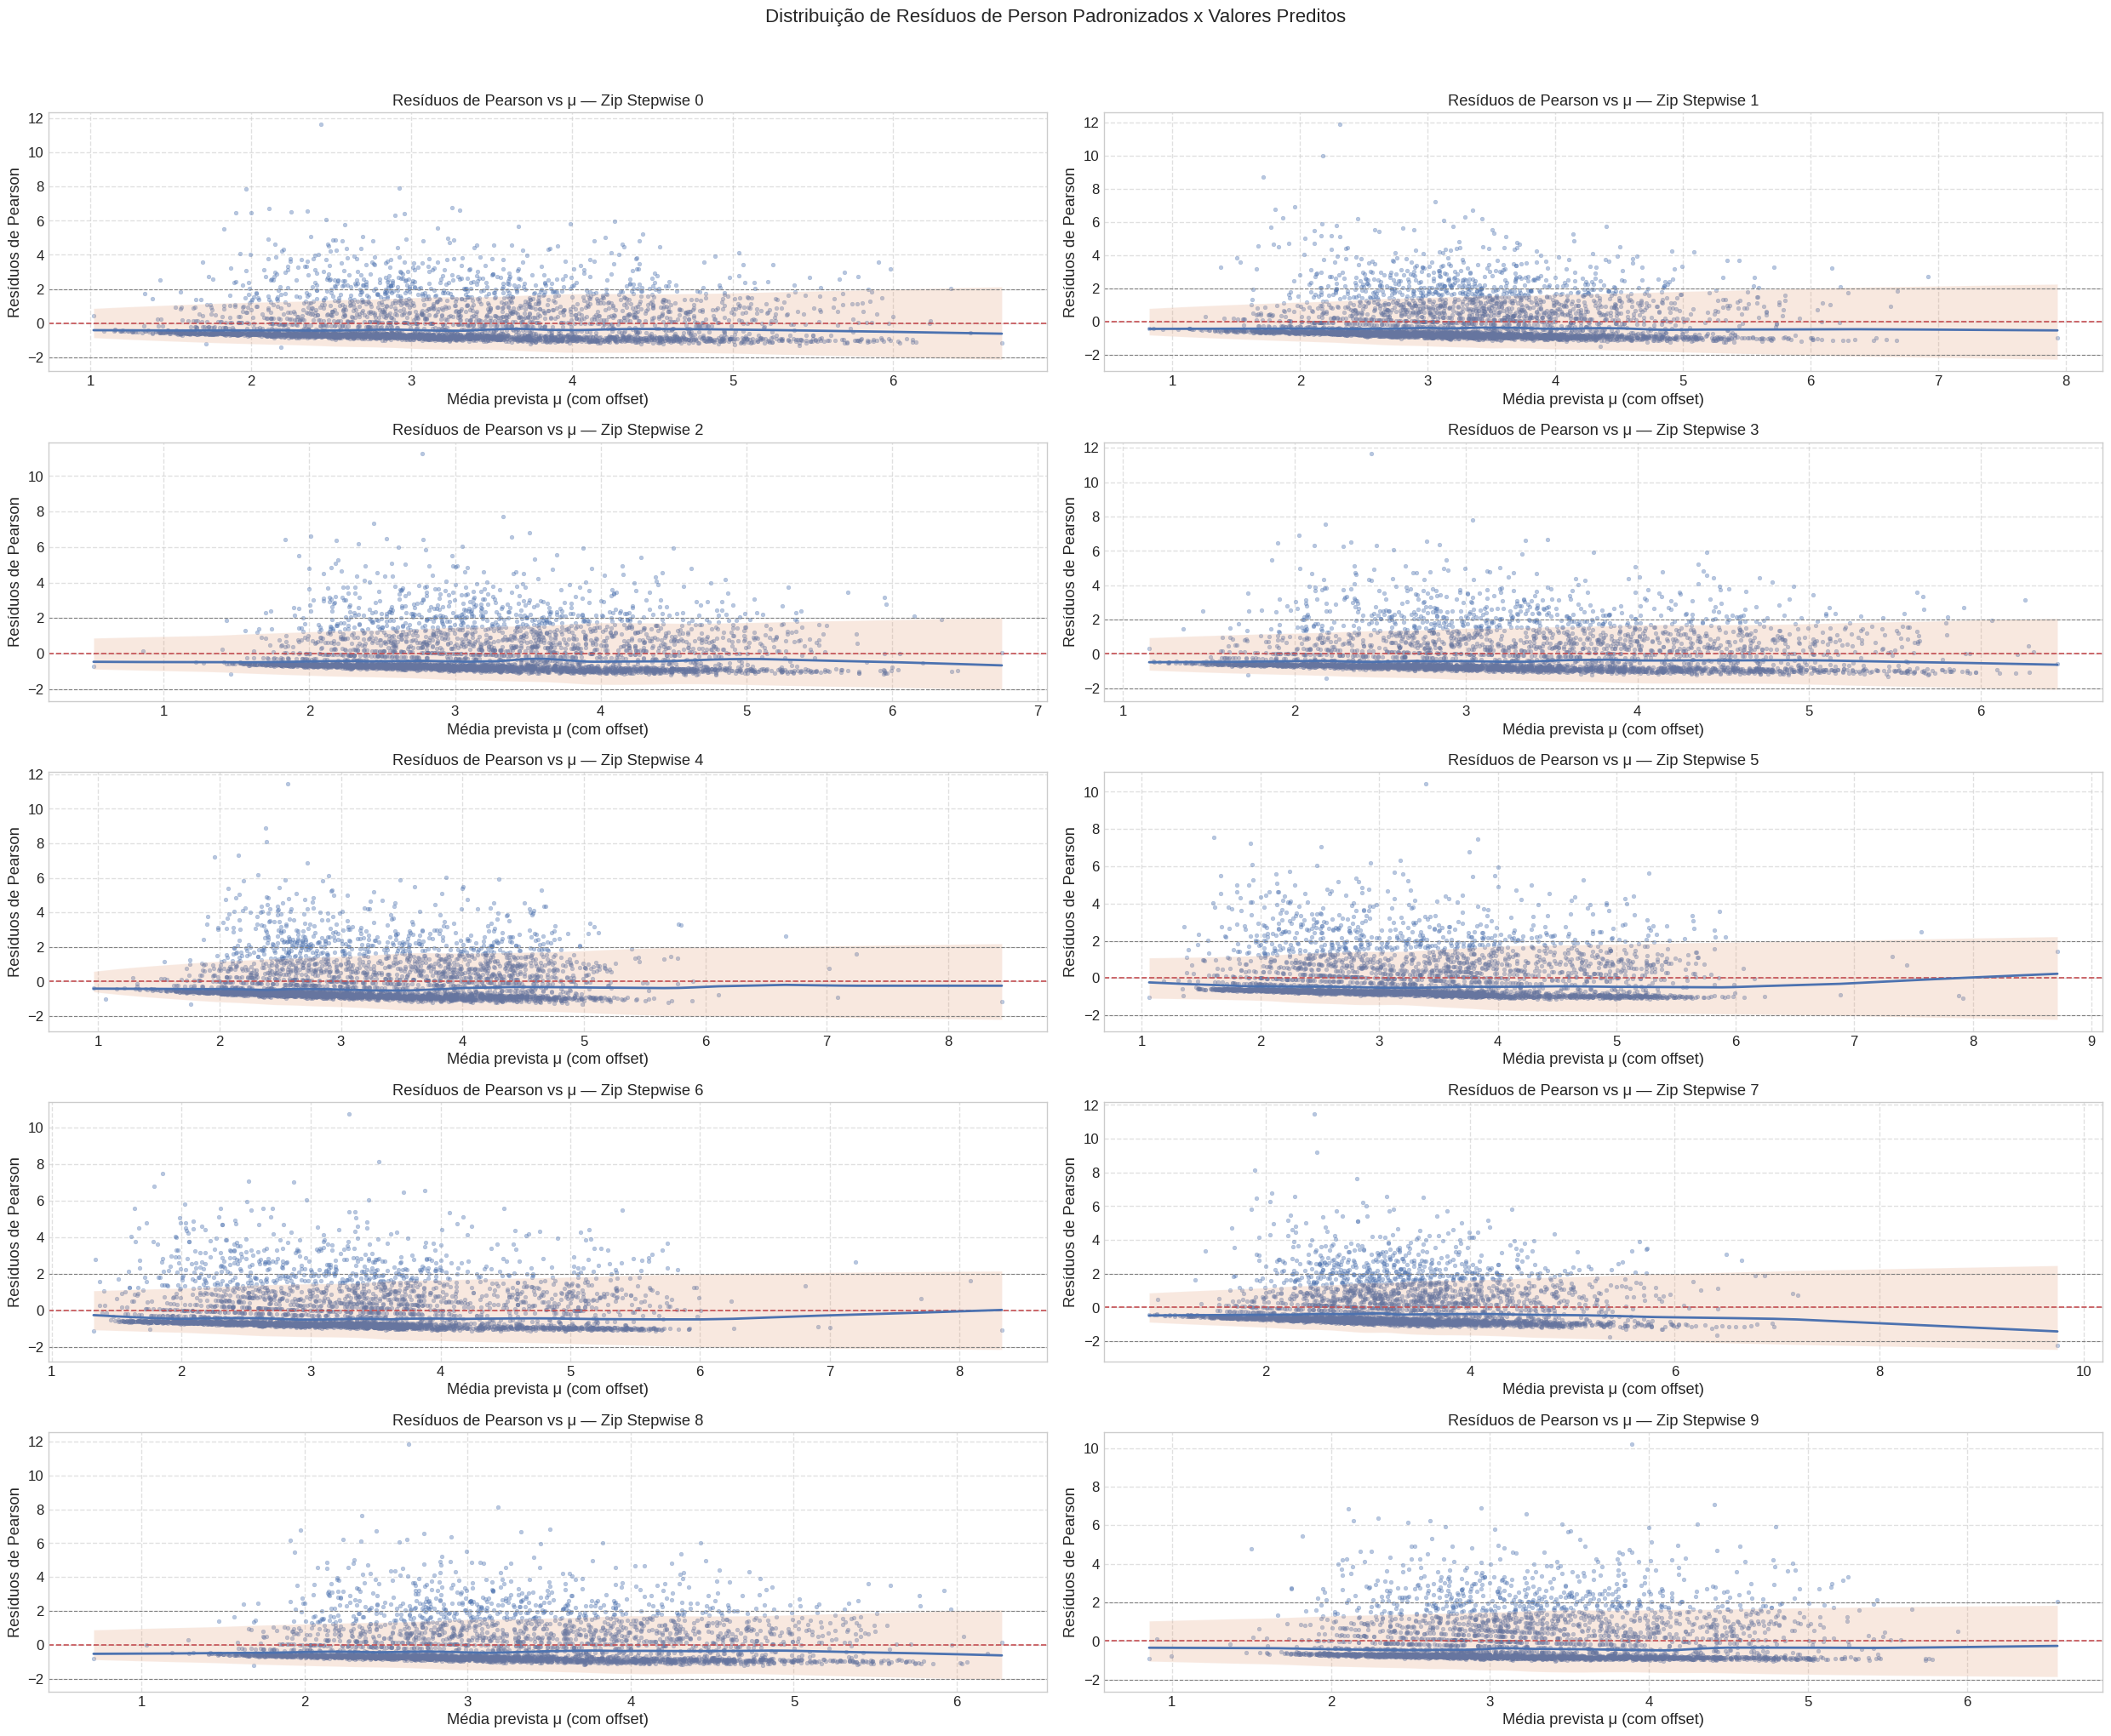

In [68]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(map(lambda x: x.final_model_, random_selector_zip.models)):
    plt.subplot(5, 2, i+1)
    overdisp_plot_enhanced(model, f'Zip Stepwise {i}')

plt.tight_layout()
plt.show()

In [69]:
df_trained_zip = build_count_models_report(list(enumerate(map(lambda x: x.final_model_, random_selector_zip.models))), window=selected_builder.window, criterion='BIC')
df_trained_zip

window  model_name          LLF           BIC           AIC  Converged  \
0  1320m           0 -9086.495501  18272.271041  18196.991002       True   
1  1320m           3 -9092.050856  18275.108414  18206.101711       True   
2  1320m           2 -9109.174551  18292.809131  18236.349101       True   
3  1320m           4 -9112.195477  18298.850984  18242.390954       True   
4  1320m           8 -9123.097848  18312.382389  18262.195696       True   
5  1320m           1 -9117.062985  18341.679345  18260.125969       True   
6  1320m           7 -9113.349269  18342.525250  18254.698538       True   
7  1320m           5 -9151.722467  18361.358290  18317.444934       True   
8  1320m           6 -9146.639916  18367.739862  18311.279833       True   
9  1320m           9 -9166.729811  18391.372977  18347.459621       True   

   RMSE_Pearson  Outliers  Pct_resid_gt_2  Pct_resid_gt_3  Dispersion  \
0      1.280441       343        8.754467        3.828484    1.642043   
1      1.281457       344        8.779990        3.905054    1.644652   
2      1.279541       348        8.882083        3.828484    1.639318   
3      1.286355       349        8.907606        3.777437    1.656400   
4      1.284810       348        8.882083        3.828484    1.652424   
5      1.286763       334        8.524758        3.675345    1.659146   
6      1.280077       339        8.652374        3.675345    1.641949   
7      1.289328       344        8.779990        3.854007    1.664066   
8      1.286418       342        8.728943        3.854007    1.657409   
9      1.272599       344        8.779990        3.700868    1.621164   

   df_resid  PseudoR2  __preferred__   Best  
0    3912.0  0.040131              1   True  
1    3912.0  0.039544              1  False  
2    3913.0  0.037735              1  False  
3    3914.0  0.037416              1  False  
4    3914.0  0.036264              1  False  
5    3910.0  0.036902              1  False  
6    3910.0  0.037294              1  False  
7    3914.0  0.033240              1  False  
8    3912.0  0.033777              1  False  
9    3914.0  0.031655              1  False

In [70]:
best_model_index_zip = df_trained_zip.loc[0, 'model_name']
best_model_index_zip

np.int64(0)

In [71]:
modelo_zip_stepwise = random_selector_zip.models[best_model_index_zip].final_model_
modelo_zip_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                       y   No. Observations:                 3918
Model:             ZeroInflatedPoisson   Df Residuals:                     3912
Method:                            MLE   Df Model:                            5
Date:                 Wed, 27 Aug 2025   Pseudo R-squ.:                 0.04013
Time:                         13:54:35   Log-Likelihood:                -9086.5
converged:                        True   LL-Null:                       -9466.4
Covariance Type:             nonrobust   LLR p-value:                5.791e-162
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
inflate_const                     33.9780     17.497      1.942      0.052      -0.315      68.271
inflate_chip_ratio                -1.1759      0.108    -10.890      0.000      -1.387      -0.964
inflate_cards_per_client           6.5396      0.883      7.405      0.000       4.809       8.271
inflate_avg_transactions_value     0.0616      0.014      4.422      0.000       0.034       0.089
inflate_merchant_entropy           1.9344      0.622      3.109      0.002       0.715       3.154
inflate_avg_credit_score          -0.0797      0.024     -3.326      0.001      -0.127      -0.033
const                             -7.8487      0.861     -9.112      0.000      -9.537      -6.160
transactions_per_seconds         151.2314      8.872     17.047      0.000     133.843     168.620
cards_per_client                  -2.6794      0.392     -6.838      0.000      -3.447      -1.911
avg_transactions_value             0.0234      0.004      6.137      0.000       0.016       0.031
merchant_entropy                  -0.5367      0.157     -3.422      0.001      -0.844      -0.229
error_ratio                       10.4362      3.305      3.158      0.002       3.958      16.914
==================================================================================================
"""

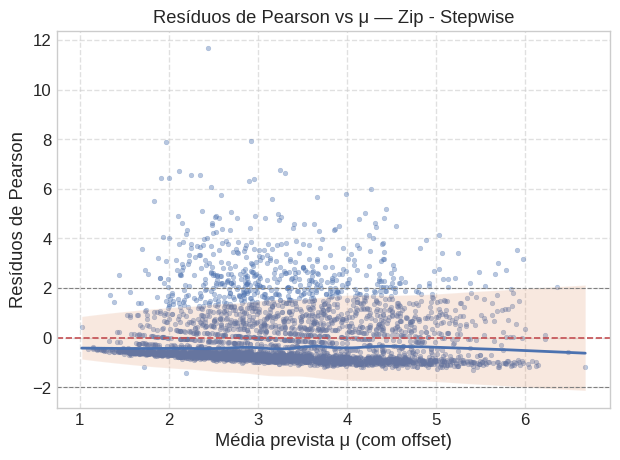

In [72]:
overdisp_plot_enhanced(modelo_zip_stepwise, 'Zip - Stepwise')

In [73]:
diagnosticar_dispersao_ct(modelo_zip_stepwise, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0000
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(5.182051238665922),
 'p_valor': np.float64(2.305252225501023e-07)}

In [74]:
vuong_test(modelo_poisson_stepwise, modelo_zip_stepwise)

         Current function value: 7182050771977926108312414937726757904580608.000000
         Iterations: 35
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: nan
p-value: nan

==================Result======================== 

H0: Indicates no inflation of zeros at 95% confidence level


O modelo apresentou uma melhora significativa em relação ao modelo zip completo uma vez que agora os residuos estão bem mais espelhados em torno da linha vermelha (y=0). No entanto ainda é perceptivo uma dispersão maior ao longo que os valores preditos aumentam, indicando ainda sobredispersão.

Conforme teste de Vuong, é possível confirmar que os dados estão com inflação de zeros, sendo assim, o modelo ZIP acaba sendo indicado para esse problema em questão da inflação de zeros.

### Modelo Zero-Inflated Negative Binomial (ZINB)  
Modelagem de Contagem com Sobredispersão e Excesso de Zeros

O **Modelo Zero-Inflated Negative Binomial (ZINB)** é uma extensão do modelo Zero-Inflated Poisson (ZIP), indicado quando os dados de contagem apresentam simultaneamente:

- Um **excesso de zeros** não compatível com a distribuição de Poisson ou Binomial Negativa;
- Uma **sobredispersão** (variância maior que a média) nas contagens positivas.

Esse modelo permite que a variável resposta $Y_i$ seja gerada por dois processos distintos:

1. Um processo binário que determina a ocorrência de **zeros estruturais** com probabilidade $\pi_i$;
2. Um processo de **contagem sob a distribuição Binomial Negativa** com média $\mu_i$ e parâmetro de dispersão $\theta$, para as demais observações.

---

### Estrutura do Modelo

A função de probabilidade do modelo ZINB é definida da seguinte forma:

$$
P(Y_i = 0) = \pi_i + (1 - \pi_i) \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}
$$

$$
P(Y_i = k) = (1 - \pi_i) \cdot \binom{k + \theta - 1}{k} \cdot \left( \frac{\mu_i}{\mu_i + \theta} \right)^k \cdot \left( \frac{\theta}{\mu_i + \theta} \right)^{\theta}, \quad \text{para } k = 1, 2, 3, \dots
$$

onde:

- $\mu_i > 0$ é a média condicional do componente Binomial Negativo;
- $\theta > 0$ é o parâmetro de dispersão;
- $\pi_i$ é a probabilidade de a observação pertencer à **parte inflacionada de zeros**.

---

### Componentes do Modelo

O modelo é composto por duas partes principais:

#### 1. Parte de contagem (Binomial Negativa)

A média da distribuição é modelada com função de ligação logarítmica:

$$
\log(\mu_i) = \beta_0 + \beta_1 x_{i1} + \dots + \beta_p x_{ip}
$$

ou

$$
\mu_i = \exp(x_i^\top \beta)
$$

#### 2. Parte de inflação de zeros (Logística)

A probabilidade $\pi_i$ é modelada com uma função logística:

$$
\text{logit}(\pi_i) = \gamma_0 + \gamma_1 z_{i1} + \dots + \gamma_q z_{iq}
$$

ou

$$
\pi_i = \frac{\exp(z_i^\top \gamma)}{1 + \exp(z_i^\top \gamma)}
$$

---

### Variância

A variância condicional da parte de contagem segue a distribuição Binomial Negativa:

$$
\mathrm{Var}(Y_i \mid Y_i > 0) = \mu_i + \frac{\mu_i^2}{\theta}
$$

O termo adicional $\frac{\mu_i^2}{\theta}$ permite capturar sobredispersão, ajustando o modelo para casos em que a variabilidade excede a esperada por uma Poisson.

---

### Interpretação dos Coeficientes

#### Parte de Contagem (Binomial Negativa)

- Os coeficientes $\beta_j$ são interpretados como efeitos logarítmicos sobre a média $\mu_i$.
- A razão de taxas $e^{\beta_j}$ indica o **fator multiplicativo** sobre a contagem média de eventos para uma variação unitária em $x_{ij}$.

#### Parte de Zeros (Logística)

- Os coeficientes $\gamma_j$ representam o efeito **log-odds** sobre a probabilidade de a observação pertencer ao componente de zeros estruturais.
- O termo $e^{\gamma_j}$ fornece a **razão de chances** associada a cada preditor $z_{ij}$.

---

### Estimação

A estimação dos parâmetros $\beta$, $\gamma$ e $\theta$ é feita por **máxima verossimilhança**, com otimização conjunta das duas partes do modelo. A presença do parâmetro de dispersão $\theta$ requer métodos numéricos robustos para convergência adequada.

---

### Utilização

O modelo ZINB é apropriado quando:

- A variável resposta apresenta **muitos zeros** e **sobredispersão** simultaneamente;
- Há **dois mecanismos distintos** de geração de zeros: um estrutural (determinístico) e outro probabilístico (contagem);
- É necessário identificar fatores que influenciam tanto a **presença de zeros estruturais** quanto o **nível da contagem**.

---

### Considerações Finais

O modelo ZINB é uma alternativa robusta ao ZIP e à Binomial Negativa padrão. Ele oferece maior capacidade de ajuste e interpretação quando a estrutura dos dados de contagem é complexa, com variações acentuadas e presença de dois regimes distintos (zero e contagem positiva).


#### Validação de presuposto

Os dados devem apresentar **sobredispersão**, ou seja, variância é maior que a média.

In [75]:
pd.DataFrame({'Média':[y.mean()],'Variância':[y.var()]})

Média  Variância
0  3.277693  28.024475

##### Completo

In [76]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy(deep=True)
X1 = sm.add_constant(X1)

In [77]:
modelo_zinb = ZeroInflatedNegativeBinomialP(y, X1, exog_infl=X1, offset=np.log(X['duration_sec'])).fit(disp=False) # , method='lbfgs', cov_type='HC1'
modelo_zinb.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            frauds   No. Observations:                 3918
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     3899
Method:                                      MLE   Df Model:                           18
Date:                           Wed, 27 Aug 2025   Pseudo R-squ.:                     nan
Time:                                   13:55:06   Log-Likelihood:                    nan
converged:                                 False   LL-Null:                       -7814.1
Covariance Type:                       nonrobust   LLR p-value:                       nan
=====================================================================================================
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
inflate_const                        -0.0006        nan        nan        nan         nan         nan
inflate_total_transactions           -1.3562        nan        nan        nan         nan         nan
inflate_total_amount                -67.1388        nan        nan        nan         nan         nan
inflate_chip_ratio                   -0.0003        nan        nan        nan         nan         nan
inflate_transactions_per_seconds  -1.712e-05        nan        nan        nan         nan         nan
inflate_avg_transactions_value       -0.0309        nan        nan        nan         nan         nan
inflate_geo_dispersion               -0.0133        nan        nan        nan         nan         nan
inflate_merchant_entropy             -0.0034        nan        nan        nan         nan         nan
inflate_avg_credit_score             -0.4446        nan        nan        nan         nan         nan
inflate_error_ratio               -9.848e-06        nan        nan        nan         nan         nan
inflate_hour_sin                   4.576e-05        nan        nan        nan         nan         nan
inflate_hour_cos                   2.781e-05        nan        nan        nan         nan         nan
inflate_day_sin                   -1.624e-05        nan        nan        nan         nan         nan
inflate_day_cos                    1.511e-05        nan        nan        nan         nan         nan
inflate_is_holiday                -1.472e-05        nan        nan        nan         nan         nan
inflate_change_volume_transaction -1.448e-05        nan        nan        nan         nan         nan
inflate_velocity_alert            -4.394e-06        nan        nan        nan         nan         nan
inflate_unique_clients               -0.5863        nan        nan        nan         nan         nan
inflate_unique_cards                 -0.8784        nan        nan        nan         nan         nan
inflate_cards_per_client             -0.0009        nan        nan        nan         nan         nan
const                               -42.8350        nan        nan        nan         nan         nan
total_transactions                 8505.6365        nan        nan        nan         nan         nan
total_amount                       1031.6994        nan        nan        nan         nan         nan
chip_ratio                            0.0054        nan        nan        nan         nan         nan
transactions_per_seconds           -6.72e+08        nan        nan        nan         nan         nan
avg_transactions_value                0.4643        nan        nan        nan         nan         nan
geo_dispersion                        0.2016        nan        nan        nan         nan         nan
merchant_entropy                      0.0499        nan        nan        nan     

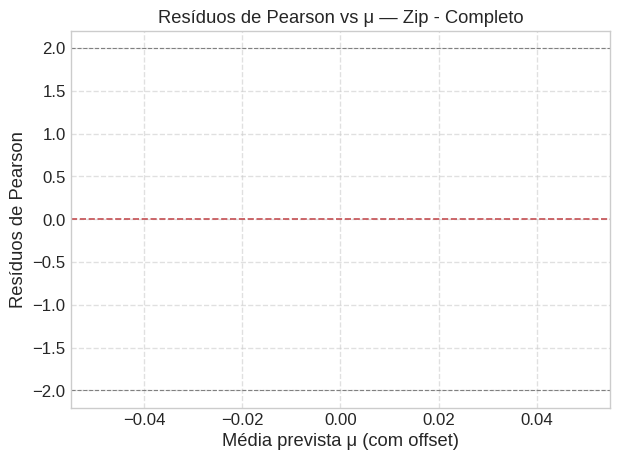

In [78]:
overdisp_plot_enhanced(modelo_zinb, 'Zip - Completo')

In [79]:
diagnosticar_dispersao_ct(modelo_zinb, y)

Ocorreu um erro ao executar o teste: exog contains inf or nans


{'estatistica_t': nan, 'p_valor': nan}

O gráfico mostra que o modelo prevê quase sempre valores próximos de zero, mas quando ocorrem contagens positivas ele não consegue explicar bem, gerando erros muito grandes.
Isso significa que o modelo está superestimando zeros e subestimando casos com eventos reais.
Os resíduos deveriam se espalhar de forma equilibrada em torno de zero, mas aqui aparecem concentrados e com cauda longa para cima, sinal claro de mau ajuste.

In [80]:
vuong_test(modelo_binomial, modelo_zinb)

         Current function value: 76.936842
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 14
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: nan
p-value: nan

==================Result======================== 

H0: Indicates no inflation of zeros at 95% confidence level


##### Stepwise

In [81]:
X1 = X.drop(columns=['frauds', 'duration_sec']).copy()

In [82]:
step_wise = StepwiseZeroInflated(
    alpha=0.05,
    model_type='ZINB',
    selection_criterion='LLF',
#     cov_type='HC1',
    verbose=False,
#    method='lbfgs',
    convergence_strictness='low',
    shuffle_features=True,
    shuffle_random_state=40,
    feature_groups=[['hour_sin', 'hour_cos'], ['day_sin', 'day_cos']]
)
random_selector_bneg = RandomFeatureSelector(step_wise, max_features=0.75, random_state=40, feature_groups=[['hour_sin', 'hour_cos'], ['day_sin', 'day_cos']])
random_selector_bneg.fit(X1, y, np.log(X['duration_sec']))

RandomFeatureSelector(estimator=StepwiseZeroInflated(convergence_strictness='low',
                                                     feature_groups=[['hour_sin',
                                                                      'hour_cos'],
                                                                     ['day_sin',
                                                                      'day_cos']],
                                                     model_type='ZINB',
                                                     selection_criterion='LLF',
                                                     shuffle_features=True,
                                                     shuffle_random_state=40,
                                                     verbose=False),
                      feature_groups=[['hour_sin', 'hour_cos'],
                                      ['day_sin', 'day_cos']],
                      max_features=0.75, random_state=40)

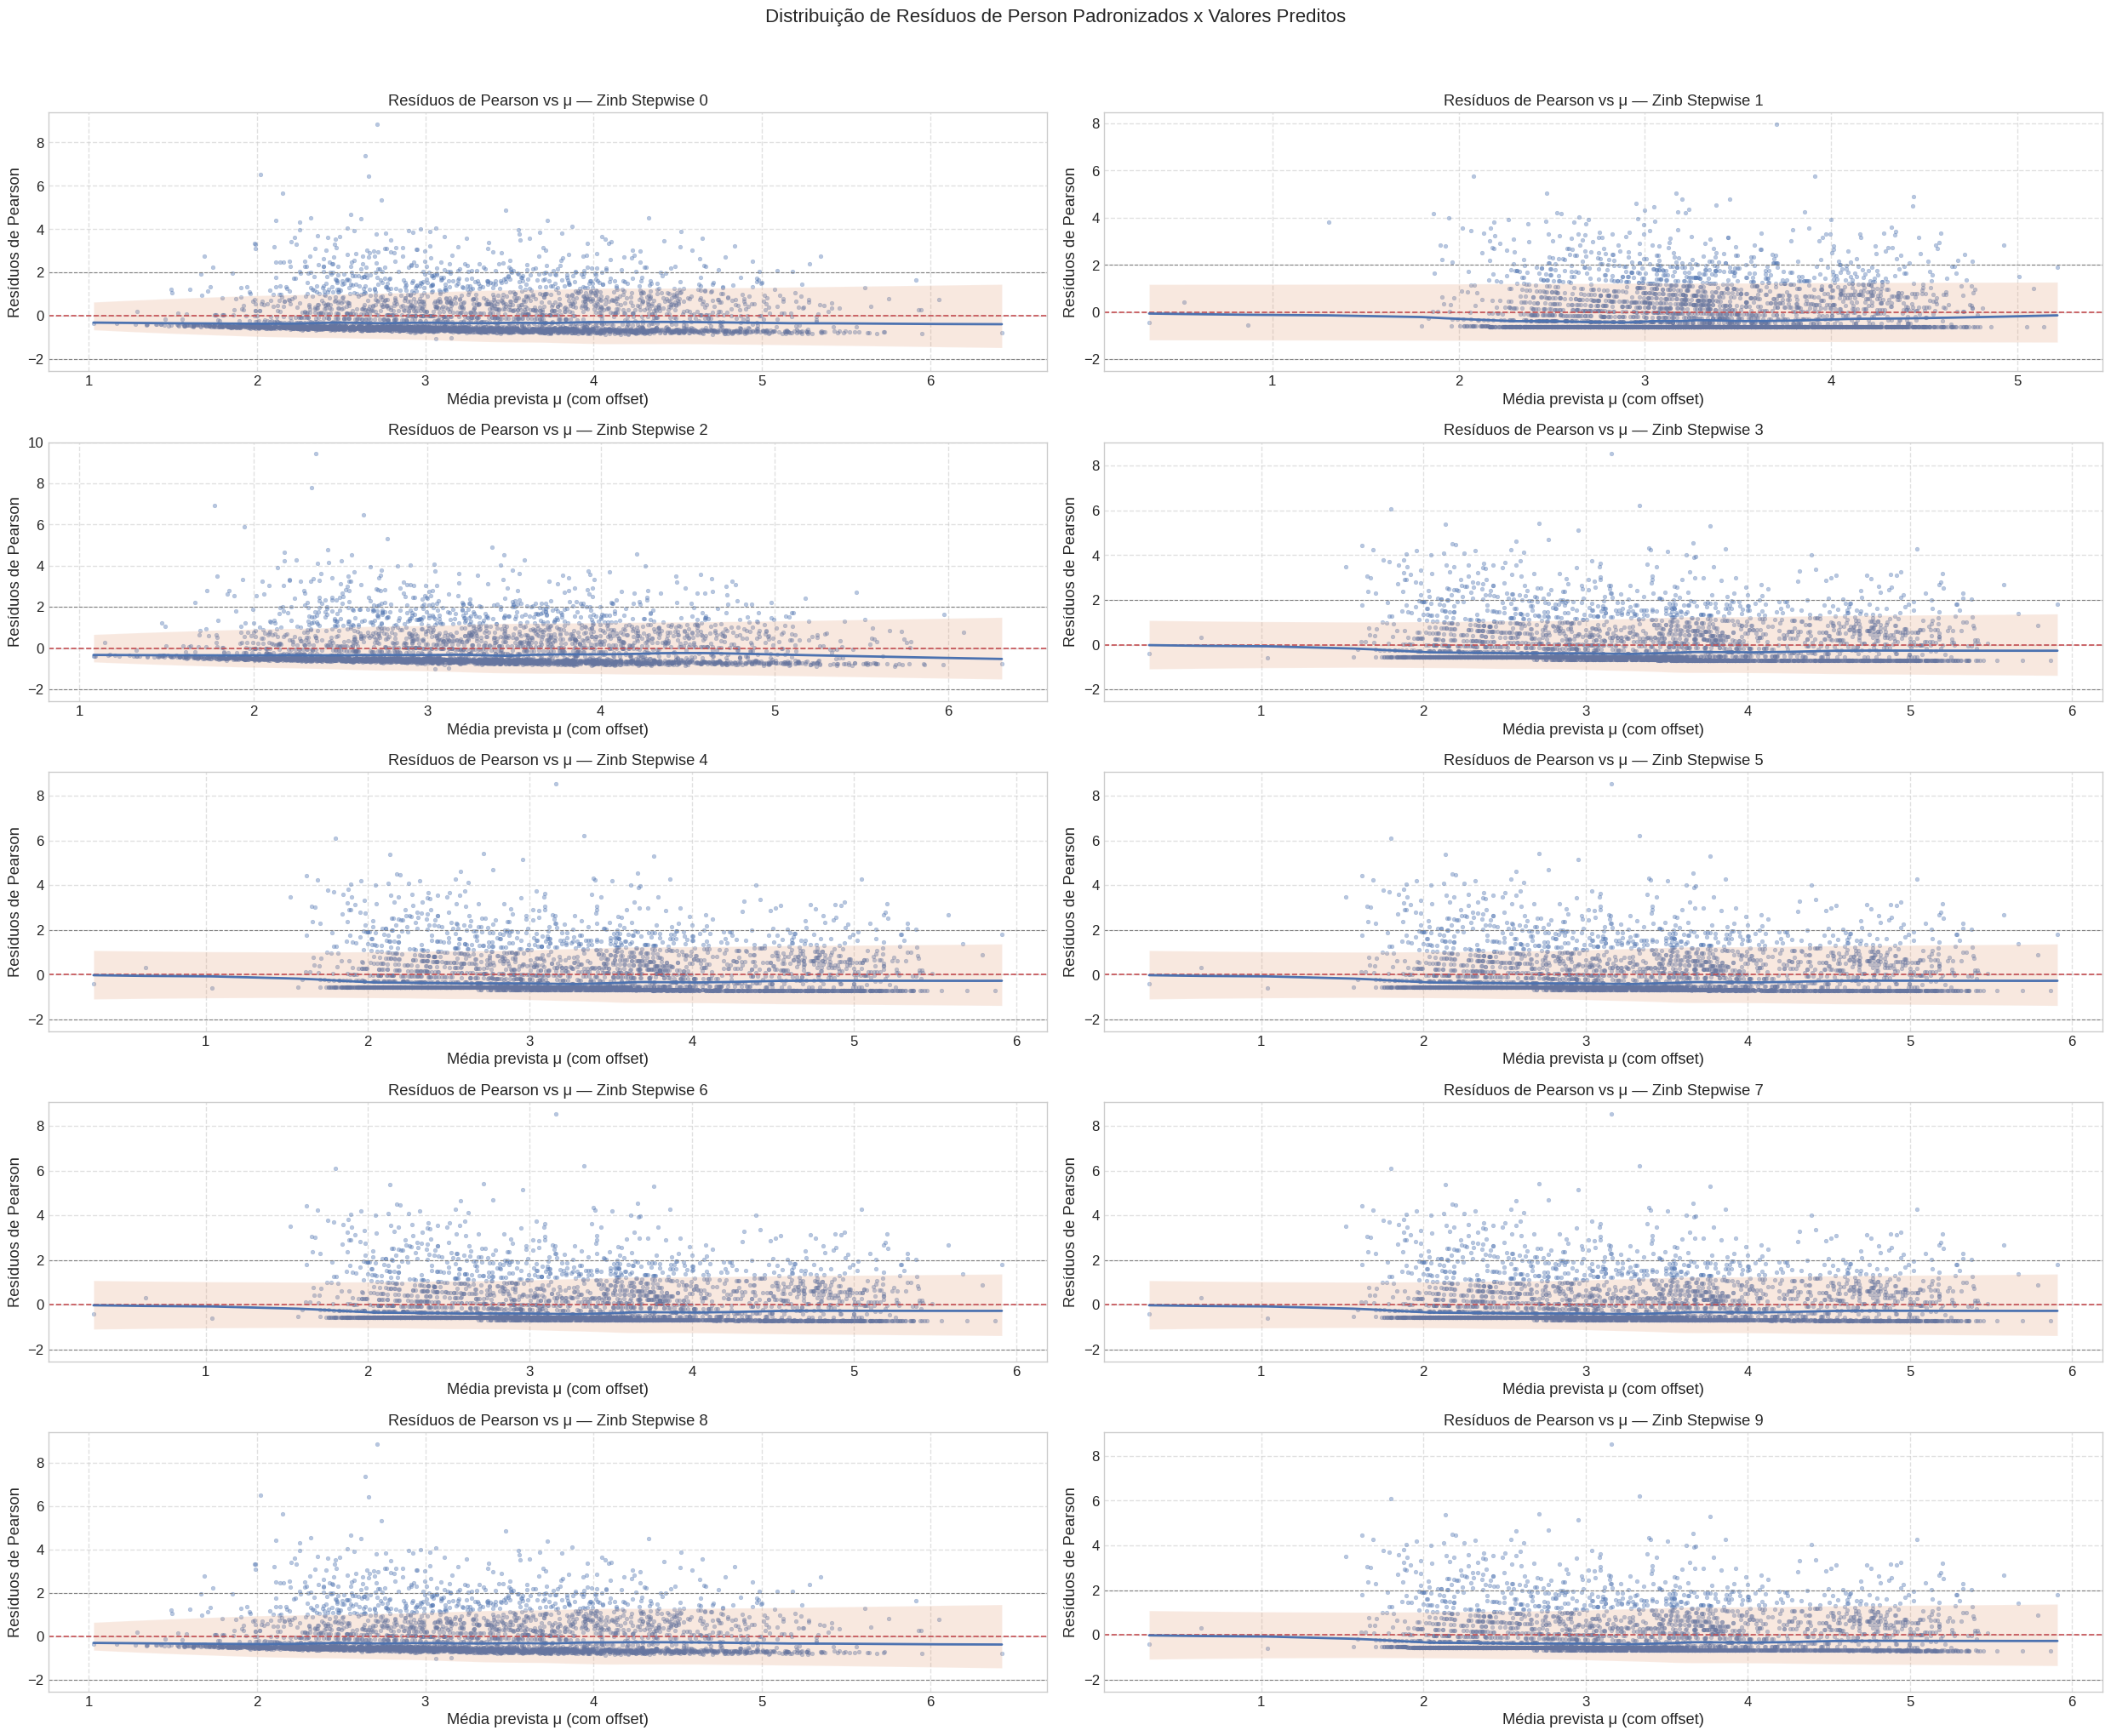

In [83]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(map(lambda x: x.final_model_, random_selector_bneg.models)):
    plt.subplot(5, 2, i + 1)
    overdisp_plot_enhanced(model, f'Zinb Stepwise {i}')

plt.tight_layout()
plt.show()

In [84]:
df_trained_zinb = build_count_models_report(list(enumerate(map(lambda x: x.final_model_, random_selector_bneg.models))), window=selected_builder.window, criterion='BIC')
df_trained_zinb

window  model_name          LLF           BIC           AIC  Converged  \
0  1320m           2 -7683.435136  15466.150310  15390.870271       True   
1  1320m           0 -7693.449409  15477.905521  15408.898819       True   
2  1320m           8 -7693.449409  15477.905521  15408.898819       True   
3  1320m           3 -7730.258101  15501.882885  15470.516202       True   
4  1320m           4 -7730.258101  15501.882885  15470.516202       True   
5  1320m           5 -7730.258101  15501.882885  15470.516202       True   
6  1320m           6 -7730.258101  15501.882885  15470.516202       True   
7  1320m           7 -7730.258101  15501.882885  15470.516202       True   
8  1320m           9 -7730.258101  15501.882885  15470.516202       True   
9  1320m           1 -7764.684252  15562.461850  15537.368504       True   

   RMSE_Pearson  Outliers  Pct_resid_gt_2  Pct_resid_gt_3  Dispersion  \
0      0.984632       212        5.410924        1.939765    0.970739   
1      0.980584       209        5.334354        1.914242    0.962773   
2      0.980584       209        5.334354        1.914242    0.962773   
3      0.994544       214        5.461970        2.016335    0.989623   
4      0.994544       214        5.461970        2.016335    0.989623   
5      0.994544       214        5.461970        2.016335    0.989623   
6      0.994544       214        5.461970        2.016335    0.989623   
7      0.994544       214        5.461970        2.016335    0.989623   
8      0.994544       214        5.461970        2.016335    0.989623   
9      0.986044       210        5.359877        1.990812    0.972779   

   df_resid  PseudoR2  __preferred__   Best  
0    3913.0  0.016718              1   True  
1    3913.0  0.015437              1  False  
2    3913.0  0.015437              1  False  
3    3916.0  0.010726              1  False  
4    3916.0  0.010726              1  False  
5    3916.0  0.010726              1  False  
6    3916.0  0.010726              1  False  
7    3916.0  0.010726              1  False  
8    3916.0  0.010726              1  False  
9    3916.0  0.006321              1  False

In [85]:
best_model_index_zinb = df_trained_zinb.loc[0, 'model_name']
best_model_index_zinb

np.int64(2)

In [86]:
modelo_zinb_stepwise = random_selector_bneg.models[best_model_index_zinb].final_model_
modelo_zinb_stepwise.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3918
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     3913
Method:                                      MLE   Df Model:                            4
Date:                           Wed, 27 Aug 2025   Pseudo R-squ.:                 0.01672
Time:                                   14:01:31   Log-Likelihood:                -7683.4
converged:                                  True   LL-Null:                       -7814.1
Covariance Type:                       nonrobust   LLR p-value:                 2.418e-55
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
inflate_const                     28.9023     18.866      1.532      0.126      -8.074      65.878
inflate_chip_ratio                -1.2790      0.117    -10.959      0.000      -1.508      -1.050
inflate_merchant_entropy           2.2936      0.636      3.607      0.000       1.047       3.540
inflate_cards_per_client           7.5455      0.953      7.915      0.000       5.677       9.414
inflate_avg_credit_score          -0.0779      0.026     -3.007      0.003      -0.129      -0.027
inflate_avg_transactions_value     0.0647      0.015      4.425      0.000       0.036       0.093
const                            -34.2024     11.100     -3.081      0.002     -55.959     -12.446
hour_sin                           0.0842      0.030      2.836      0.005       0.026       0.142
hour_cos                           0.1523      0.032      4.705      0.000       0.089       0.216
cards_per_client                   1.8865      0.422      4.470      0.000       1.059       2.714
avg_credit_score                   0.0308      0.016      1.982      0.047       0.000       0.061
alpha                              0.6025      0.036     16.706      0.000       0.532       0.673
==================================================================================================
"""

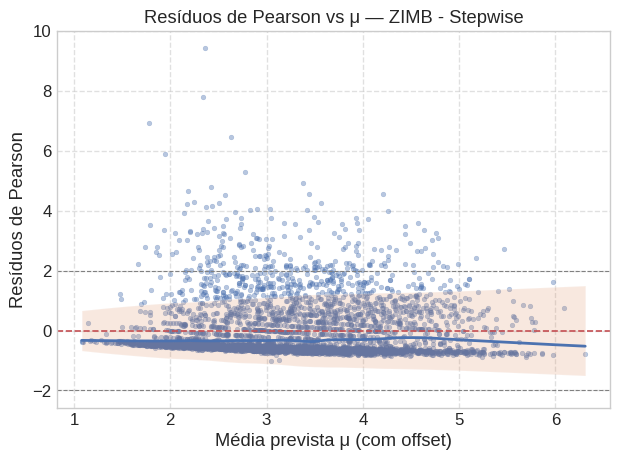

In [87]:
overdisp_plot_enhanced(modelo_zinb_stepwise, 'ZIMB - Stepwise')

In [88]:
diagnosticar_dispersao_ct(modelo_zinb_stepwise, y)

--- Diagnóstico de Dispersão (Teste de Cameron & Trivedi) ---
P-valor do teste: 0.0002
Resultado (α = 0.05): Hipótese nula rejeitada.
Conclusão: Há evidência de má especificação da dispersão (ex: sobredispersão não capturada).
-------------------------------------------------------------


{'estatistica_t': np.float64(3.723000455213337),
 'p_valor': np.float64(0.00019963733449170637)}

O modelo stepwise apresenta previsões mais altas e consistentes, evitando o excesso de zeros visto no modelo anterior.
Os resíduos estão mais próximos de zero e com menor amplitude, sinal de um ajuste mais estável.
Ainda assim, surgem faixas verticais de pontos, indicando previsões pouco flexíveis e repetitivas.
Existem alguns resíduos acima de 5, mostrando que erros relevantes ainda ocorrem.

In [89]:
vuong_test(modelo_binomial_stepwise, modelo_zinb_stepwise)

         Current function value: 74.879417
         Iterations: 0
         Function evaluations: 15
         Gradient evaluations: 14
Vuong Non-Nested Hypothesis Test-Statistic (Raw):
Vuong z-statistic: -571.081
p-value: 0.000

==================Result======================== 

H1: Indicates inflation of zeros at 95% confidence level


### Comparação dos modelos com base em seu Log-Likelihood Function (LLF)

## Análise do melhor modelo

In [90]:
titles = [
    'Poisson Completo',
    'Poisson StepWise',
    'Binomial Completo',
    'Binomial Stepwise',
    'ZIP Completo',
    'ZIP Stepwise',
    #'ZINB Completo',
    'ZINB Stepwise'
]
models = [
    modelo_poisson,
    modelo_poisson_stepwise,
    modelo_binomial,
    modelo_binomial_stepwise,
    modelo_zip,
    modelo_zip_stepwise,
    #modelo_zinb,
    modelo_zinb_stepwise
]

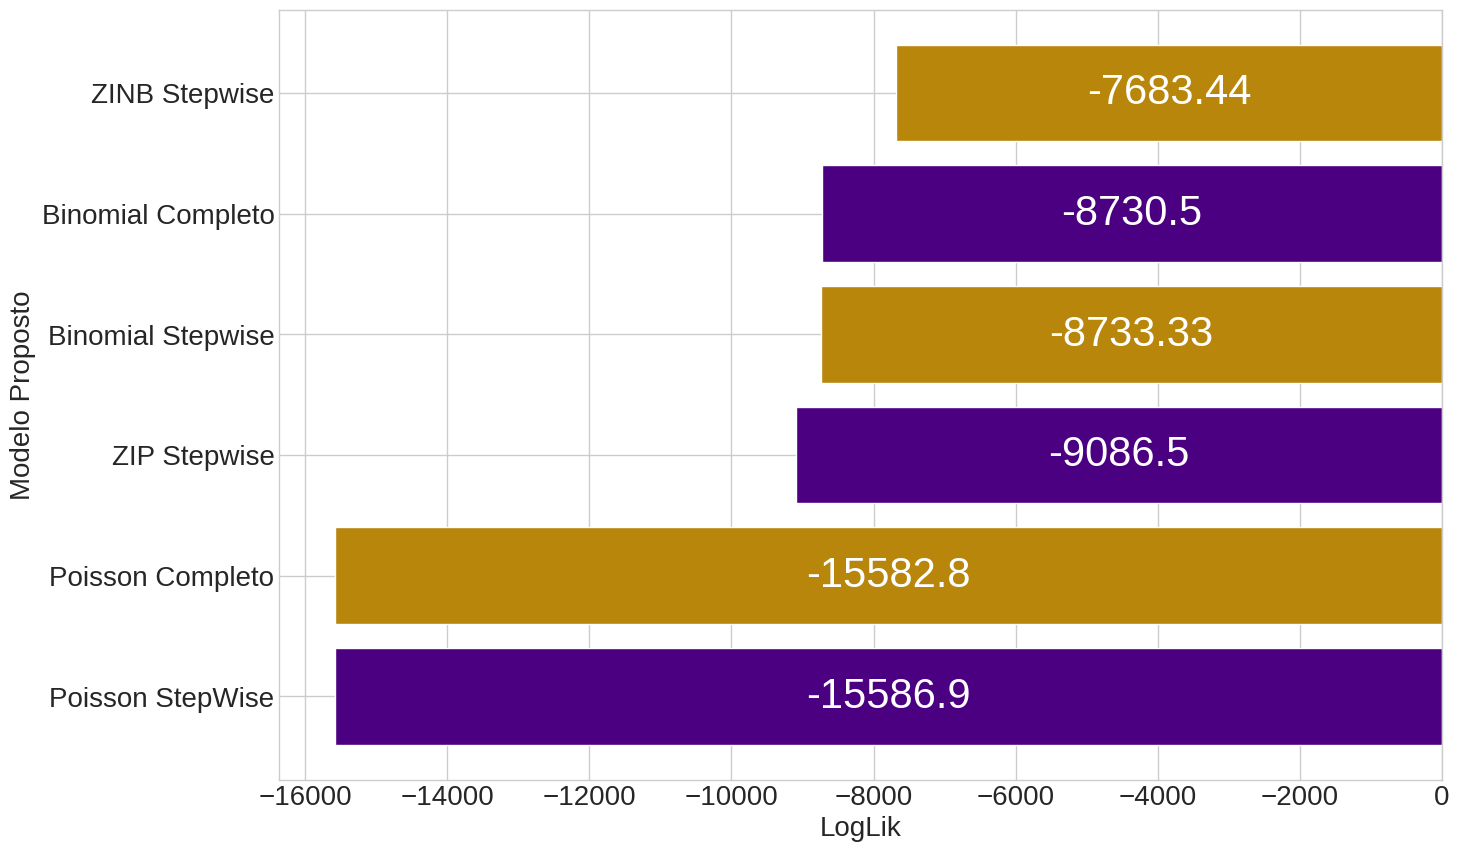

In [91]:
def print_compare_models():
  selected_models = []
  selected_names = []

  for model, name in zip(models, titles):
    if model.converged:
      selected_models.append(model)
      selected_names.append(name)

  compare_models({
    'modelo':selected_names,
    'loglik':[model.llf for model in selected_models]
  })

print_compare_models()

Analisando diretamente a métrica do LLF podemos ver claramente que o modelo ZINB obeteve um melhor resultado, sugerindo que esse possa ser o melho modelo, no entanto será necessário validar outros aspectos a fim de garantir que esse modelo realmente possa ser utilizado.

### Dispersão dos residuos

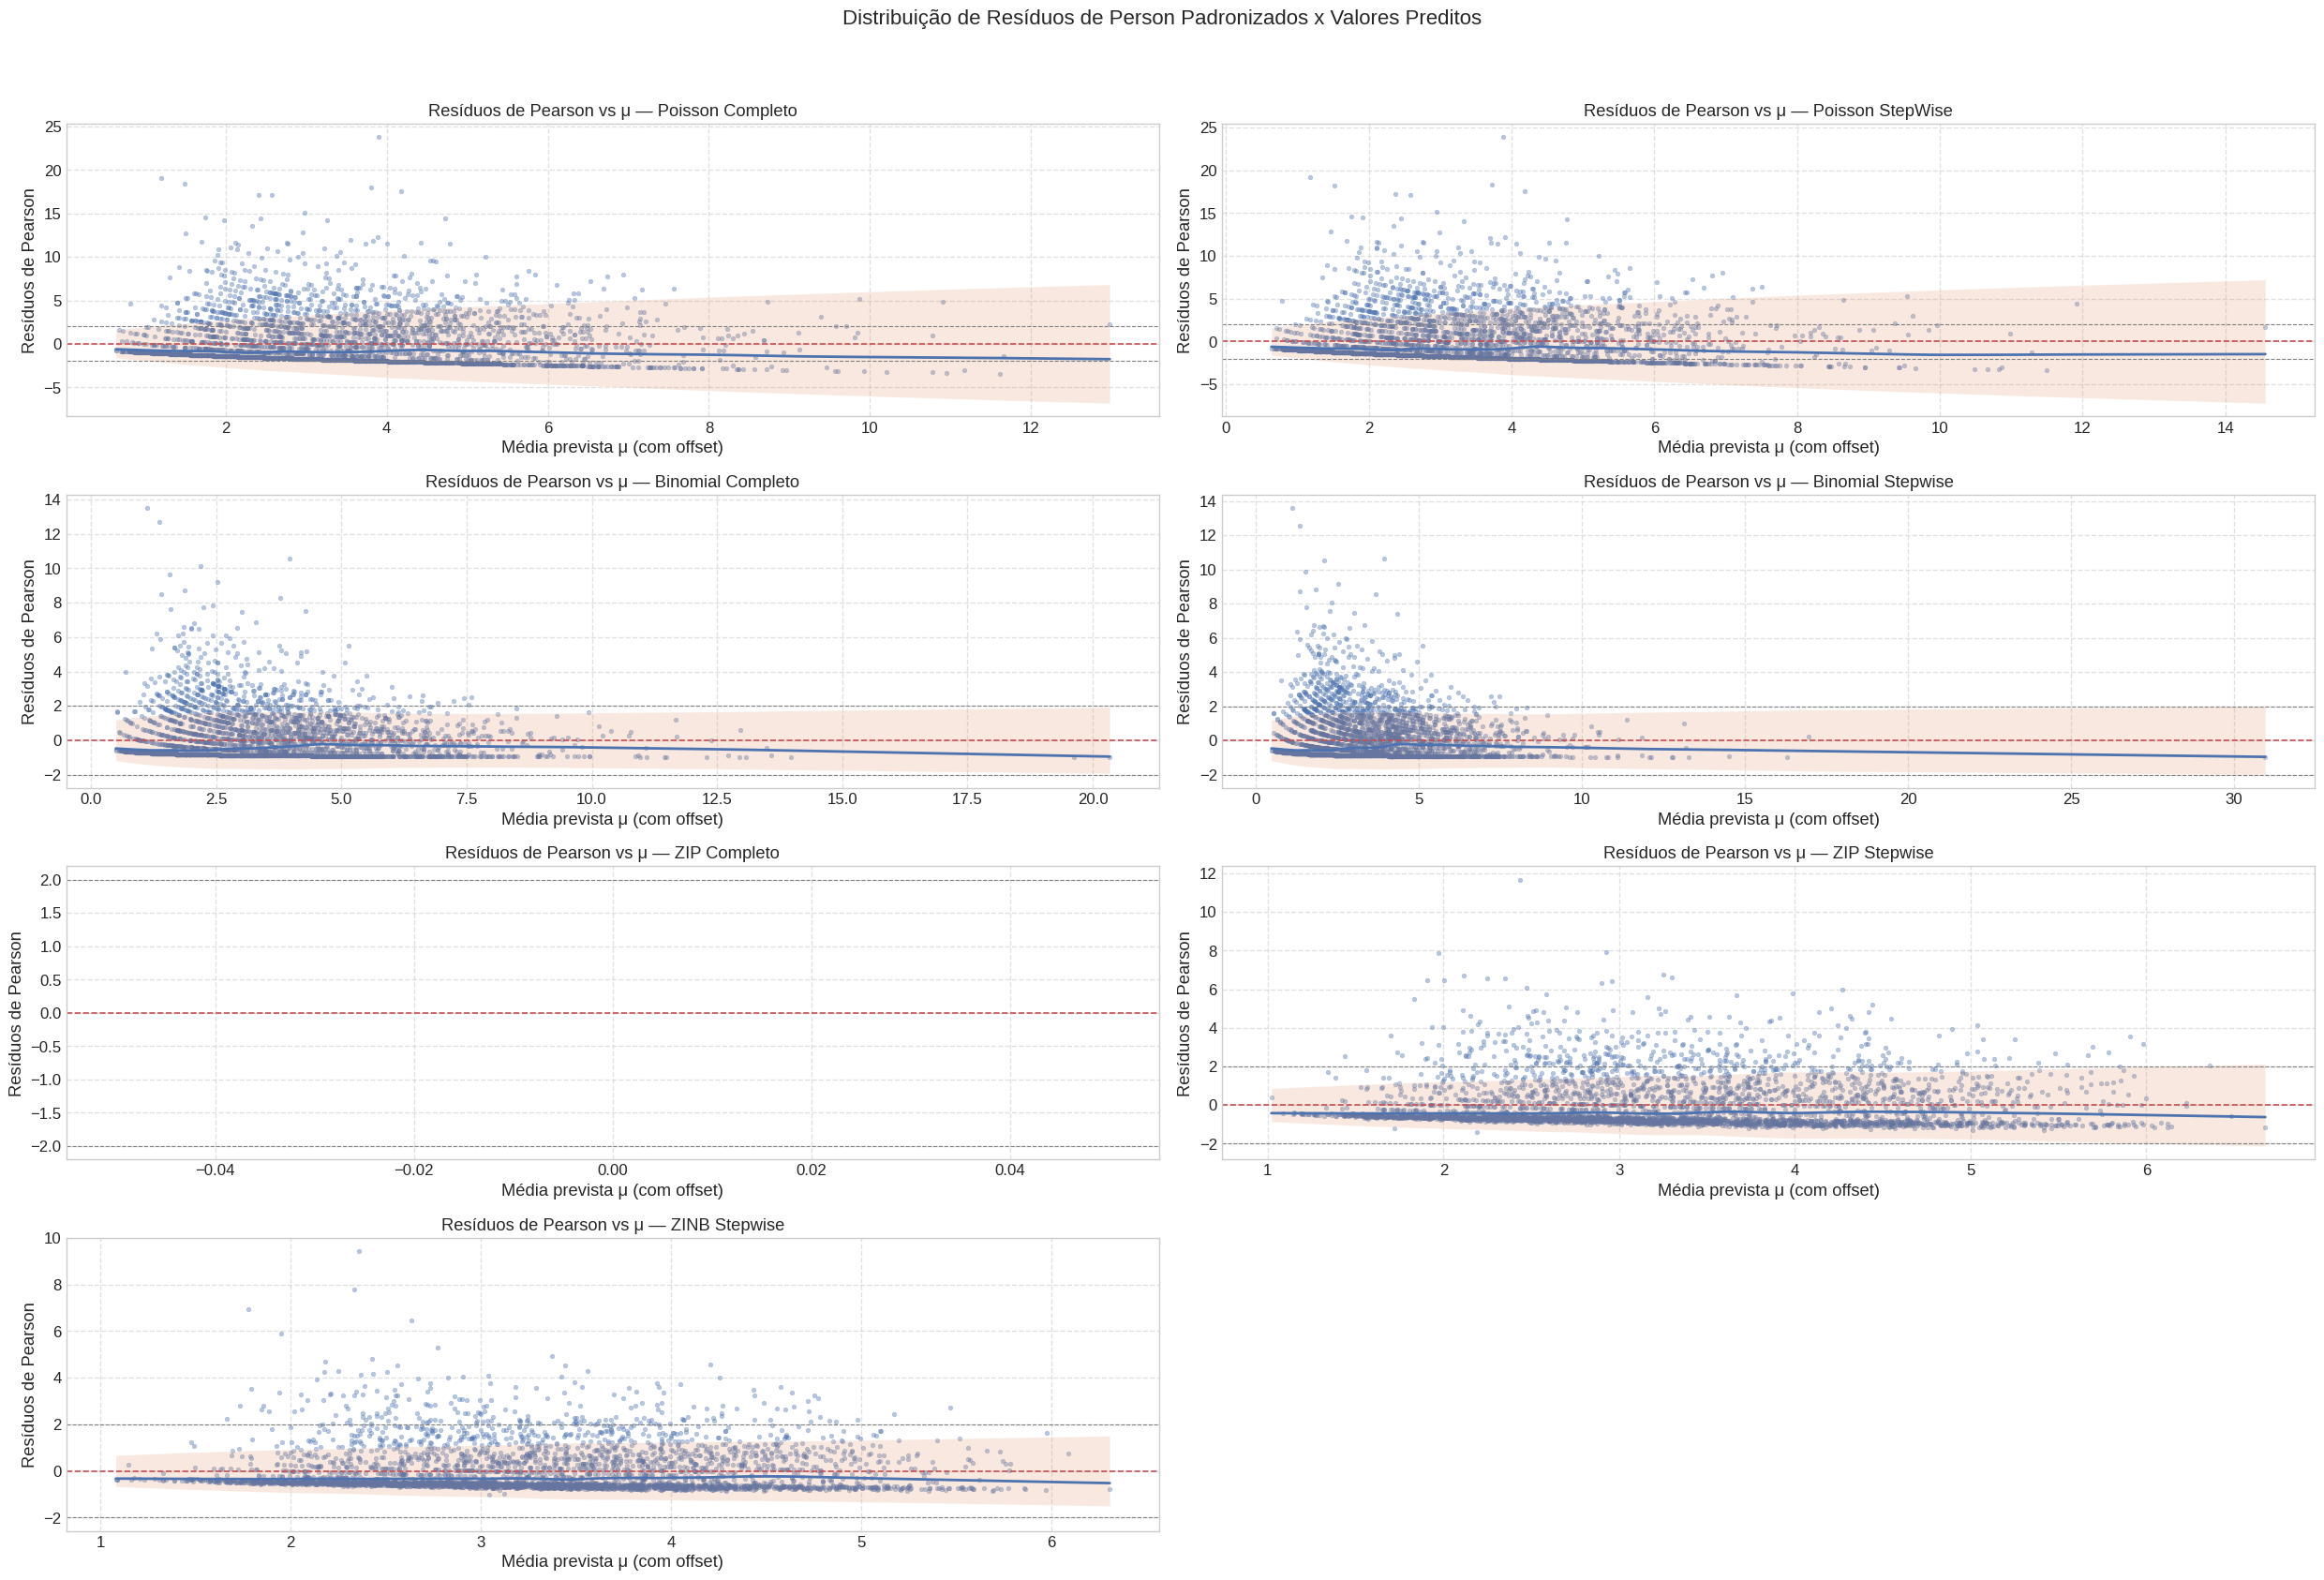

In [92]:
plt.figure(figsize=(25, 20))

# Define o título com uma posição mais alta usando y
plt.suptitle('Distribuição de Resíduos de Person Padronizados x Valores Preditos', fontsize=16, y=1.02)

# Ajusta espaço entre os subplots e o título
plt.subplots_adjust(top=0.92)

for i, model in enumerate(models):
    plt.subplot(5, 2, i + 1)
    overdisp_plot_enhanced(model, titles[i])

plt.tight_layout()
plt.show()

Com base nos residuos de cada modelos em relação ao valor predito, podemos observar que o modelo ZINB Stepwise apresenta uma melhor distribuição dos residuos não apresentando um padrão fixo nos dados, sua dispersão é a menor em relação aos outros modelos e com poucos pontos extremos.

### Análise das métricas dos modelos

In [96]:
df_metrics = build_count_models_report(list(zip(titles, models)), window=selected_builder.window, criterion='LLF').query('Converged == True')
df_metrics

window         model_name           LLF           BIC           AIC  \
0  1320m      ZINB Stepwise  -7683.435136  15466.150310  15390.870271   
1  1320m  Binomial Completo  -8730.497012 -24566.307594  17498.994024   
2  1320m  Binomial Stepwise  -8733.334208 -24610.273222  17492.668416   
3  1320m       ZIP Stepwise  -9086.495501  18272.271041  18196.991002   
4  1320m   Poisson Completo -15582.834703  -7317.985753  31203.669406   
5  1320m   Poisson StepWise -15586.942140  -7351.137563  31201.884279   

   Converged  RMSE_Pearson  Outliers  Pct_resid_gt_2  Pct_resid_gt_3  \
0       True      0.984632     212.0        5.410924        1.939765   
1       True      1.407882     337.0        8.601327        4.160286   
2       True      1.410184     331.0        8.448188        4.236856   
3       True      1.280441     343.0        8.754467        3.828484   
4       True      2.759416    1176.0       30.015314       13.578356   
5       True      2.761622    1174.0       29.964267       13.425217   

   Dispersion  df_resid  PseudoR2  __preferred__   Best  
0    0.970739    3913.0  0.016718              1   True  
1    1.991791    3899.0  0.177780              1  False  
2    1.995239    3905.0  0.176589              1  False  
3    1.642043    3912.0  0.040131              1  False  
4    7.651481    3899.0  0.519632              0  False  
5    7.653906    3904.0  0.518624              0  False

Percebemos que o modelo com maior LLF não convergiu durante o treinamento, o que invalida sua escolha uma vez que os pesos obtidos não refletem a correta relação dos dados com o modelo escohido.

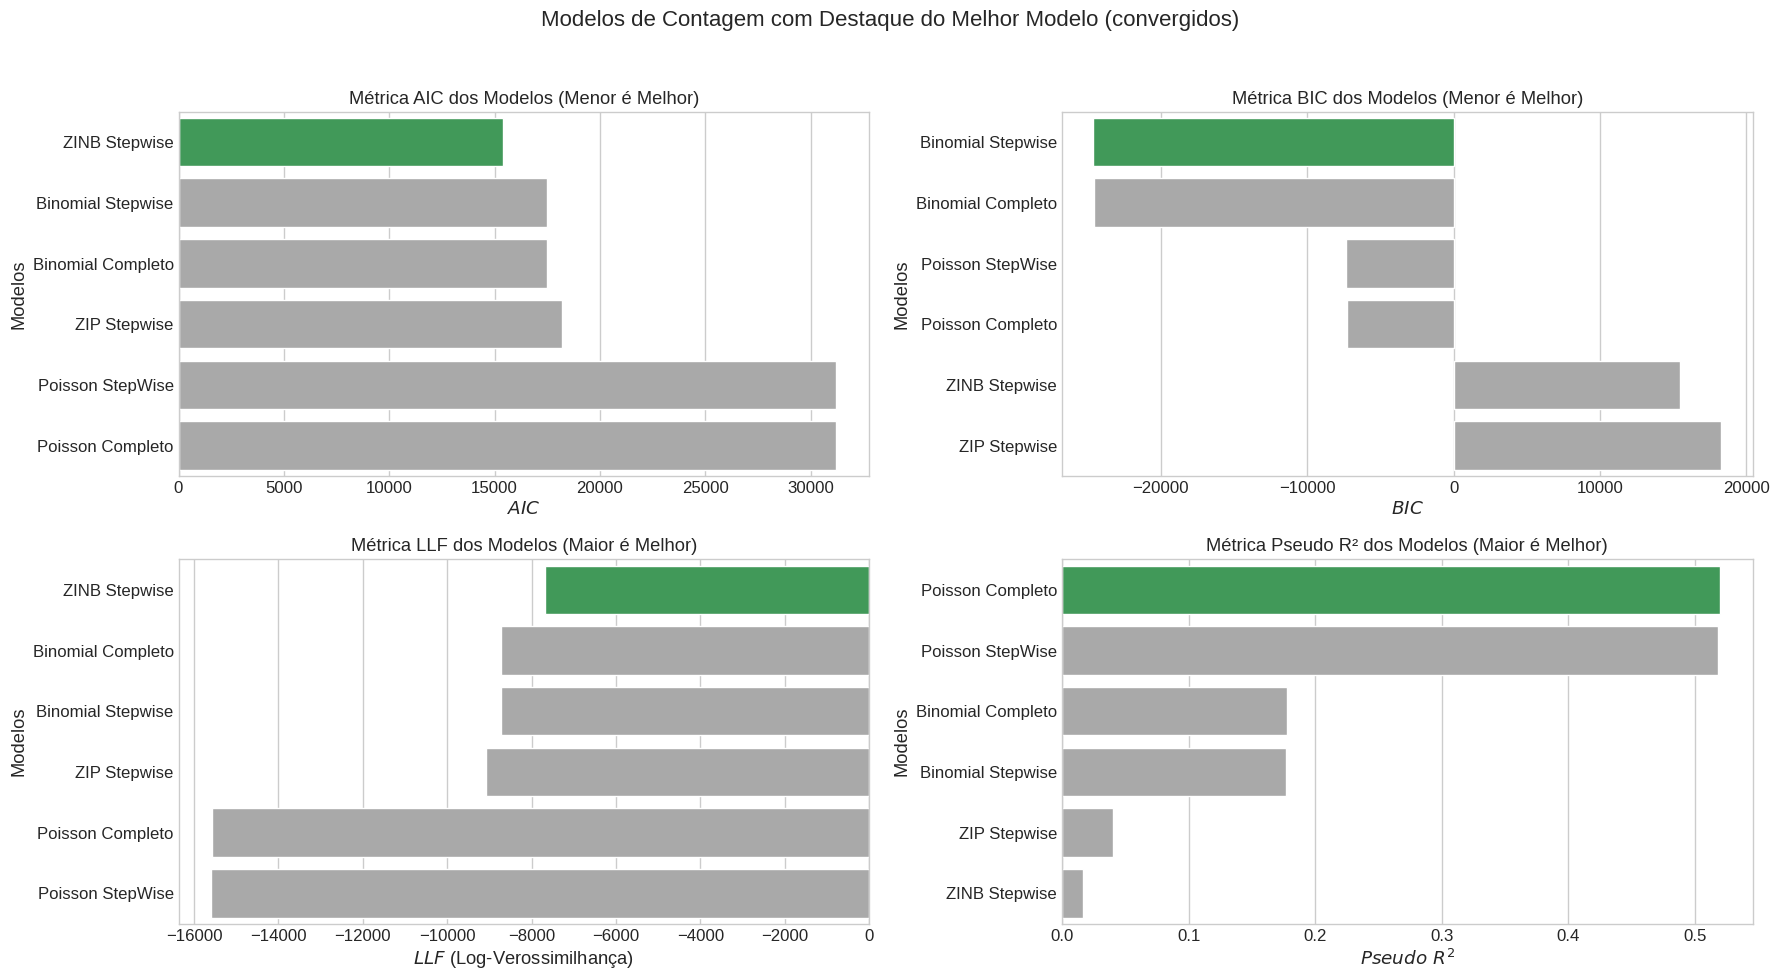

In [97]:
plt.figure(figsize=(18, 10))
plt.suptitle('Modelos de Contagem com Destaque do Melhor Modelo (convergidos)', fontsize=16)

# Cor de destaque para o melhor modelo e cor padrão para os outros
highlight_color = '#32a852' # Verde
default_color = '#a9a9a9'   # Cinza

# --- Subplot 1: AIC ---
plt.subplot(2, 2, 1)
plt.title('Métrica AIC dos Modelos (Menor é Melhor)')
# Ordena os valores para o gráfico
df_sorted = df_metrics.sort_values(by='AIC', ascending=True)
# Encontra o nome do melhor modelo (menor AIC)
best_model_aic = df_metrics.loc[df_metrics['AIC'].idxmin()]['model_name']
# Cria a paleta de cores: destaca o melhor modelo
palette_aic = [highlight_color if title == best_model_aic else default_color for title in df_sorted['model_name']]
# Plota o gráfico com a paleta de cores
sns.barplot(data=df_sorted, y='model_name', x='AIC', palette=palette_aic)
plt.xlabel('$AIC$')
plt.ylabel('Modelos')

# --- Subplot 2: BIC ---
plt.subplot(2, 2, 2)
plt.title('Métrica BIC dos Modelos (Menor é Melhor)')
df_sorted = df_metrics.sort_values(by='BIC', ascending=True)
best_model_bic = df_metrics.loc[df_metrics['BIC'].idxmin()]['model_name']
palette_bic = [highlight_color if title == best_model_bic else default_color for title in df_sorted['model_name']]
sns.barplot(data=df_sorted, y='model_name', x='BIC', palette=palette_bic)
plt.xlabel('$BIC$')
plt.ylabel('Modelos')

# --- Subplot 3: LLF ---
plt.subplot(2, 2, 3)
plt.title('Métrica LLF dos Modelos (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='LLF', ascending=False)
best_model_llf = df_metrics.loc[df_metrics['LLF'].idxmax()]['model_name']
palette_llf = [highlight_color if title == best_model_llf else default_color for title in df_sorted['model_name']]
sns.barplot(data=df_sorted, y='model_name', x='LLF', palette=palette_llf)
plt.xlabel('$LLF$ (Log-Verossimilhança)')
plt.ylabel('Modelos')

# --- Subplot 4: Pseudo R² ---
plt.subplot(2, 2, 4)
plt.title('Métrica Pseudo R² dos Modelos (Maior é Melhor)')
df_sorted = df_metrics.sort_values(by='PseudoR2', ascending=False)
best_model_r2 = df_metrics.loc[df_metrics['PseudoR2'].idxmax()]['model_name']
palette_r2 = [highlight_color if title == best_model_r2 else default_color for title in df_sorted['model_name']]
sns.barplot(data=df_sorted, y='model_name', x='PseudoR2', palette=palette_r2)
plt.xlabel('$Pseudo \ R^2$')
plt.ylabel('Modelos')

plt.tight_layout(rect=[0, 0, 1, 0.96]) # Ajusta o layout para não sobrepor o super-título
plt.show()

Podemos perceber que o modelo ZINB Stepwise se demonstra melhor em duas métricas, LLF e AIC, sendo assim a melhor escolha.

#### Seleção do melhor modelo

In [98]:
best_model = df_metrics.loc[0, 'model_name']
best_model

'ZINB Stepwise'

In [99]:
indice = titles.index(best_model)
best_model = models[indice]
best_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                      Results: ZeroInflatedNegativeBinomialP
==================================================================================
Model:                ZeroInflatedNegativeBinomialP  Pseudo R-squared:  0.017     
Dependent Variable:   y                              AIC:               15390.8703
Date:                 2025-08-27 14:03               BIC:               15466.1503
No. Observations:     3918                           Log-Likelihood:    -7683.4   
Df Model:             4                              LL-Null:           -7814.1   
Df Residuals:         3913                           LLR p-value:       2.4180e-55
Converged:            1.0000                         Scale:             1.0000    
Method:               MLE                                                         
----------------------------------------------------------------------------------
                                Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
----------------------------------------------------------------------------------
inflate_const                   28.9023  18.8656   1.5320 0.1255  -8.0735  65.8781
inflate_chip_ratio              -1.2790   0.1167 -10.9594 0.0000  -1.5078  -1.0503
inflate_merchant_entropy         2.2936   0.6359   3.6067 0.0003   1.0472   3.5400
inflate_cards_per_client         7.5455   0.9533   7.9151 0.0000   5.6771   9.4140
inflate_avg_credit_score        -0.0779   0.0259  -3.0073 0.0026  -0.1286  -0.0271
inflate_avg_transactions_value   0.0647   0.0146   4.4251 0.0000   0.0360   0.0933
const                          -34.2024  11.1004  -3.0812 0.0021 -55.9587 -12.4461
hour_sin                         0.0842   0.0297   2.8357 0.0046   0.0260   0.1424
hour_cos                         0.1523   0.0324   4.7052 0.0000   0.0889   0.2157
cards_per_client                 1.8865   0.4220   4.4704 0.0000   1.0594   2.7136
avg_credit_score                 0.0308   0.0155   1.9819 0.0475   0.0003   0.0613
alpha                            0.6025   0.0361  16.7064 0.0000   0.5318   0.6732
==================================================================================

"""

#### Tabela de features

In [100]:
df_exog_inf = pd.DataFrame()
if hasattr(best_model.model, 'exog_infl'):
  df_exog_inf = best_model.model.exog_infl
  feature_exog_inf = [column for column in best_model.model.exog_names if ('inflate_' in column)]
  df_exog_inf = pd.DataFrame(df_exog_inf, columns=feature_exog_inf)

In [101]:
df_exog = best_model.model.exog
features_exog = [column for column in best_model.model.exog_names if not ('inflate_' in column or 'alpha' in column)]
df_exog = pd.DataFrame(df_exog, columns=features_exog)

In [102]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3918
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     3913
Method:                                      MLE   Df Model:                            4
Date:                           Wed, 27 Aug 2025   Pseudo R-squ.:                 0.01672
Time:                                   14:03:12   Log-Likelihood:                -7683.4
converged:                                  True   LL-Null:                       -7814.1
Covariance Type:                       nonrobust   LLR p-value:                 2.418e-55
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
inflate_const                     28.9023     18.866      1.532      0.126      -8.074      65.878
inflate_chip_ratio                -1.2790      0.117    -10.959      0.000      -1.508      -1.050
inflate_merchant_entropy           2.2936      0.636      3.607      0.000       1.047       3.540
inflate_cards_per_client           7.5455      0.953      7.915      0.000       5.677       9.414
inflate_avg_credit_score          -0.0779      0.026     -3.007      0.003      -0.129      -0.027
inflate_avg_transactions_value     0.0647      0.015      4.425      0.000       0.036       0.093
const                            -34.2024     11.100     -3.081      0.002     -55.959     -12.446
hour_sin                           0.0842      0.030      2.836      0.005       0.026       0.142
hour_cos                           0.1523      0.032      4.705      0.000       0.089       0.216
cards_per_client                   1.8865      0.422      4.470      0.000       1.059       2.714
avg_credit_score                   0.0308      0.016      1.982      0.047       0.000       0.061
alpha                              0.6025      0.036     16.706      0.000       0.532       0.673
==================================================================================================
"""

In [103]:
df_features = pd.concat([df_exog, df_exog_inf], axis=1)
df_features['residuos'] = best_model.resid_pearson.values if hasattr(best_model.resid_pearson, 'values') else best_model.resid_pearson
df_features['fitted'] = best_model.fittedvalues.values
df_features['target'] = y.values
df_features

const  hour_sin      hour_cos  cards_per_client  avg_credit_score  \
0       1.0  0.000000  1.000000e+00          1.428405        714.264224   
1       1.0 -0.500000  8.660254e-01          1.358788        712.390203   
2       1.0 -0.866025  5.000000e-01          1.393904        716.460520   
3       1.0 -1.000000 -1.836970e-16          1.380298        714.252577   
4       1.0 -0.866025 -5.000000e-01          1.387173        710.826652   
...     ...       ...           ...               ...               ...   
3913    1.0 -0.500000  8.660254e-01          1.535961        714.482333   
3914    1.0 -0.866025  5.000000e-01          1.484310        715.647646   
3915    1.0 -1.000000 -1.836970e-16          1.466377        710.873933   
3916    1.0 -0.866025 -5.000000e-01          1.511868        711.750891   
3917    1.0 -0.500000 -8.660254e-01          1.235690        713.174686   

      inflate_const  inflate_chip_ratio  inflate_merchant_entropy  \
0               1.0            0.000000                  5.347912   
1               1.0            0.000000                  5.446203   
2               1.0            0.000000                  5.430923   
3               1.0            0.000000                  5.396481   
4               1.0            0.000000                  5.427792   
...             ...                 ...                       ...   
3913            1.0            0.702427                  5.548957   
3914            1.0            0.676652                  5.438515   
3915            1.0            0.696133                  5.646137   
3916            1.0            0.696078                  5.609006   
3917            1.0            0.702929                  5.215418   

      inflate_cards_per_client  inflate_avg_credit_score  \
0                     1.428405                714.264224   
1                     1.358788                712.390203   
2                     1.393904                716.460520   
3                     1.380298                714.252577   
4                     1.387173                710.826652   
...                        ...                       ...   
3913                  1.535961                714.482333   
3914                  1.484310                715.647646   
3915                  1.466377                710.873933   
3916                  1.511868                711.750891   
3917                  1.235690                713.174686   

      inflate_avg_transactions_value  residuos     fitted  target  
0                          44.794614 -0.802164 -13.641770     0.0  
1                          52.304533 -0.498120 -13.688909     1.0  
2                          48.366516 -0.795714 -14.112216     0.0  
3                          47.736021 -0.564703 -15.018389     1.0  
4                          50.111663  0.158004 -16.017899     3.0  
...                              ...       ...        ...     ...  
3913                       45.443806 -0.722365 -12.514947     0.0  
3914                       57.133291 -0.703919 -13.366762     0.0  
3915                       52.579252 -0.606007 -14.105796     0.0  
3916                       48.708217 -0.621146 -15.148976     0.0  
3917                       55.646642 -0.982232 -18.651419     0.0  

[3918 rows x 14 columns]

#### Análises de resíduos padronizados

##### Histograma

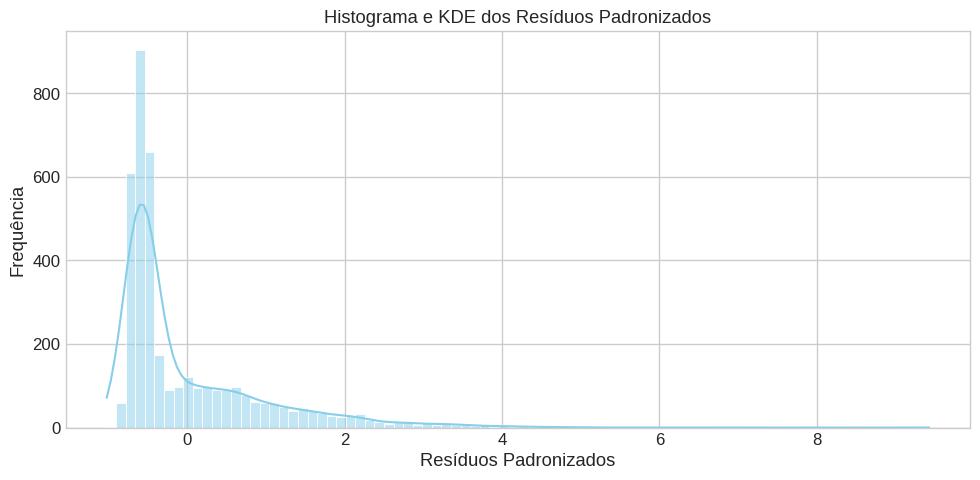

In [104]:
plt.figure(figsize=(10, 5))
sns.histplot(df_features["residuos"], kde=True, color='skyblue')
plt.title("Histograma e KDE dos Resíduos Padronizados")
plt.xlabel("Resíduos Padronizados")
plt.ylabel("Frequência")
plt.tight_layout()
plt.show()

##### Análise dos residuos com um quantis teóricos

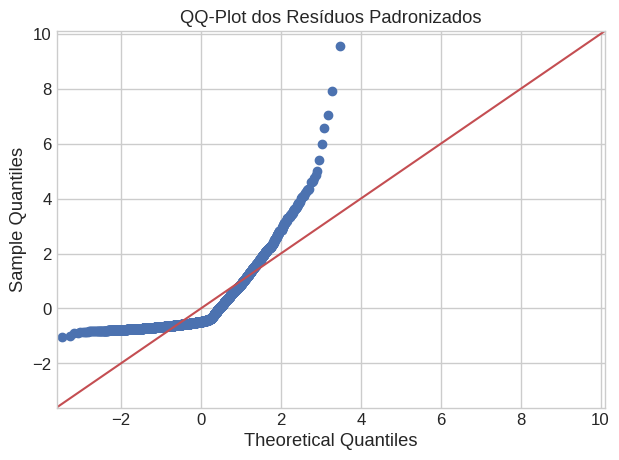

In [105]:
sm.qqplot(df_features["residuos"], line='45', fit=True)
plt.title("QQ-Plot dos Resíduos Padronizados")
plt.tight_layout()
plt.show()

##### Testes de normalidades de resíduos

In [106]:
# Shapiro-Wilk
shapiro_stat, shapiro_p = stats.shapiro(df_features["residuos"])
print(f"[Shapiro-Wilk] Estatística: {shapiro_stat:.4f} | p-valor: {shapiro_p:.4f}")

alpha = 0.05
if shapiro_p > alpha:
    print("Não rejeitamos H₀: os resíduos seguem uma distribuição normal (dentro do nível de 5%).")
else:
    print("Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.")

[Shapiro-Wilk] Estatística: 0.7300 | p-valor: 0.0000
Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.


In [107]:
# D’Agostino and Pearson's test
dagostino_stat, dagostino_p = stats.normaltest(df_features["residuos"])
print(f"[D’Agostino] Estatística: {dagostino_stat:.4f} | p-valor: {dagostino_p:.4f}")

alpha = 0.05  # nível de significância
if dagostino_p > alpha:
    print("Não rejeitamos H₀: os resíduos seguem uma distribuição normal (dentro do nível de 5%).")
else:
    print("Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.")

[D’Agostino] Estatística: 1892.3969 | p-valor: 0.0000
Rejeitamos H₀: os resíduos NÃO seguem uma distribuição normal.


##### Teste de validação de homocedasticidade

In [108]:
X = sm.add_constant(df_features["fitted"])
model_bp = sm.OLS(df_features["residuos"], X).fit()
bp_test = het_breuschpagan(model_bp.resid, X)
bp_labels = ['LM Stat', 'LM p-val', 'F Stat', 'F p-val']

print("\n[Breusch-Pagan]")
for label, val in zip(bp_labels, bp_test):
    print(f"{label}: {val:.4f}")

# Define o nível de significância (alpha)
alpha = 0.05
p_valor_lm = bp_test[1] # p-valor da estatística LM é o mais comum

print(f"\n--- Validação da Hipótese (Nível de Significância α = {alpha}) ---")
print("H₀ (Hipótese Nula): O modelo é homocedástico (variância dos erros é constante).")
print("Hₐ (Hipótese Alternativa): O modelo é heterocedástico (variância dos erros não é constante).")

if p_valor_lm < alpha:
    print(f"\nResultado: O p-valor ({p_valor_lm:.4f}) é MENOR que {alpha}.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: A validação indica que o modelo APRESENTA HETEROCEDASTICIDADE.")
else:
    print(f"\nResultado: O p-valor ({p_valor_lm:.4f}) é MAIOR ou IGUAL a {alpha}.")
    print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: A validação indica que o modelo é HOMOCEDÁSTICO.")



[Breusch-Pagan]
LM Stat: 2.6931
LM p-val: 0.1008
F Stat: 2.6936
F p-val: 0.1008

--- Validação da Hipótese (Nível de Significância α = 0.05) ---
H₀ (Hipótese Nula): O modelo é homocedástico (variância dos erros é constante).
Hₐ (Hipótese Alternativa): O modelo é heterocedástico (variância dos erros não é constante).

Resultado: O p-valor (0.1008) é MAIOR ou IGUAL a 0.05.
Decisão: Não Rejeitamos a Hipótese Nula (H₀).
Conclusão: A validação indica que o modelo é HOMOCEDÁSTICO.


##### Teste de autocorrelação de resíduos

In [109]:
# Teste de Autocorrelação (Durbin-Watson)
dw_stat = durbin_watson(df_features["residuos"])

print(f"\n--- Resultado do Teste de Durbin-Watson ---")
print(f"Estatística d: {dw_stat:.4f}")

# --- VALIDAÇÃO AUTOMÁTICA DAS HIPÓTESES ---
print(f"\n--- Validação da Hipótese (Regra de Bolso 1.5 - 2.5) ---")
print("H₀ (Hipótese Nula): Não há autocorrelação entre os resíduos.")
print("Hₐ (Hipótese Alternativa): Existe autocorrelação entre os resíduos.")

if dw_stat < 1.5:
    print(f"\nResultado: A estatística ({dw_stat:.4f}) é MENOR que 1.5.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste indica a presença de AUTOCORRELAÇÃO POSITIVA.")

elif dw_stat > 2.5:
    print(f"\nResultado: A estatística ({dw_stat:.4f}) é MAIOR que 2.5.")
    print("Decisão: Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste indica a presença de AUTOCORRELAÇÃO NEGATIVA.")

else: # A estatística está entre 1.5 e 2.5
    print(f"\nResultado: A estatística ({dw_stat:.4f}) está dentro da faixa segura [1.5, 2.5].")
    print("Decisão: Não Rejeitamos a Hipótese Nula (H₀).")
    print("Conclusão: O teste NÃO indica a presença de autocorrelação de primeira ordem.")



--- Resultado do Teste de Durbin-Watson ---
Estatística d: 1.3934

--- Validação da Hipótese (Regra de Bolso 1.5 - 2.5) ---
H₀ (Hipótese Nula): Não há autocorrelação entre os resíduos.
Hₐ (Hipótese Alternativa): Existe autocorrelação entre os resíduos.

Resultado: A estatística (1.3934) é MENOR que 1.5.
Decisão: Rejeitamos a Hipótese Nula (H₀).
Conclusão: O teste indica a presença de AUTOCORRELAÇÃO POSITIVA.


In [110]:
validar_autocorrelacao_ljung_box(best_model.resid_pearson)


--- Resultados do Teste de Ljung-Box ---
        lb_stat  lb_pvalue
20  6281.902819        0.0

--- Validação da Hipótese (Nível de Significância α = 0.05) ---
H₀ (Hipótese Nula): Os resíduos são independentes e não correlacionados (ruído branco).
Hₐ (Hipótese Alternativa): Os resíduos não são independentes; existe autocorrelação.

Resultado: O p-valor (0.0000) é MENOR que 0.05.
Decisão: Rejeitamos a Hipótese Nula (H₀).
Conclusão: O teste indica a presença de AUTOCORRELAÇÃO nos resíduos.


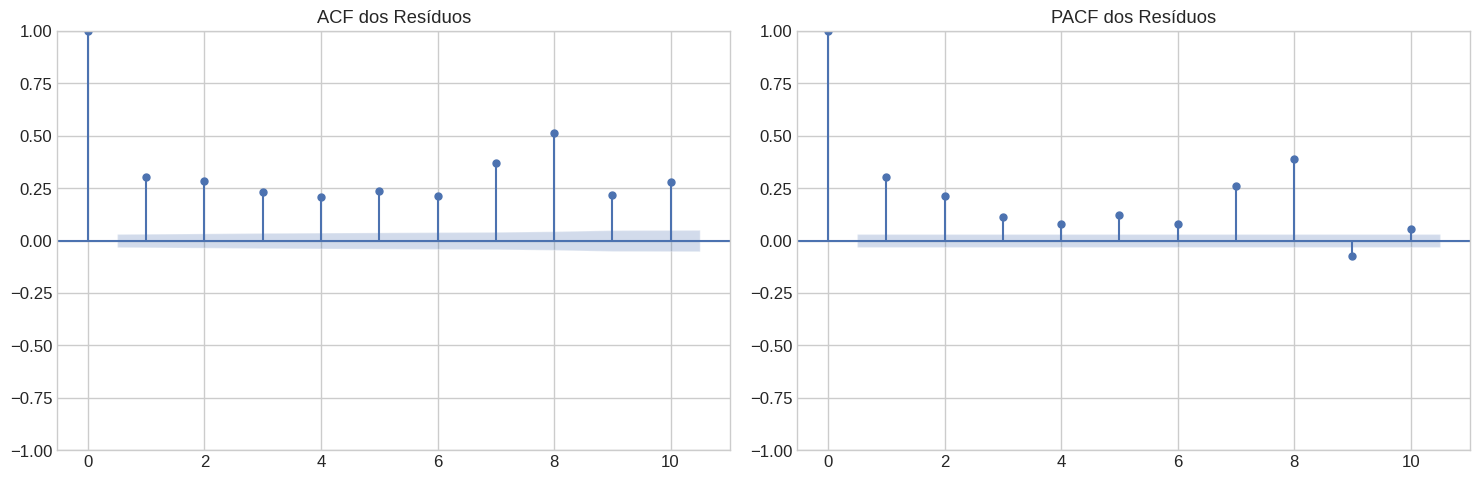

In [111]:
plot_acf_pacf(best_model.resid_pearson, 10)

## Inferência Estatistica

In [112]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 3918
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                     3913
Method:                                      MLE   Df Model:                            4
Date:                           Wed, 27 Aug 2025   Pseudo R-squ.:                 0.01672
Time:                                   14:03:49   Log-Likelihood:                -7683.4
converged:                                  True   LL-Null:                       -7814.1
Covariance Type:                       nonrobust   LLR p-value:                 2.418e-55
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
inflate_const                     28.9023     18.866      1.532      0.126      -8.074      65.878
inflate_chip_ratio                -1.2790      0.117    -10.959      0.000      -1.508      -1.050
inflate_merchant_entropy           2.2936      0.636      3.607      0.000       1.047       3.540
inflate_cards_per_client           7.5455      0.953      7.915      0.000       5.677       9.414
inflate_avg_credit_score          -0.0779      0.026     -3.007      0.003      -0.129      -0.027
inflate_avg_transactions_value     0.0647      0.015      4.425      0.000       0.036       0.093
const                            -34.2024     11.100     -3.081      0.002     -55.959     -12.446
hour_sin                           0.0842      0.030      2.836      0.005       0.026       0.142
hour_cos                           0.1523      0.032      4.705      0.000       0.089       0.216
cards_per_client                   1.8865      0.422      4.470      0.000       1.059       2.714
avg_credit_score                   0.0308      0.016      1.982      0.047       0.000       0.061
alpha                              0.6025      0.036     16.706      0.000       0.532       0.673
==================================================================================================
"""

In [113]:
params = best_model.params
conf = best_model.conf_int()
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'IRR/Odds Ratio']
conf = np.exp(conf)
conf

2.5%         97.5%  IRR/Odds Ratio
inflate_const                   3.116795e-04  4.078429e+28    3.565337e+12
inflate_chip_ratio              2.213995e-01  3.498321e-01    2.783032e-01
inflate_merchant_entropy        2.849606e+00  3.446585e+01    9.910303e+00
inflate_cards_per_client        2.920949e+02  1.225890e+04    1.892290e+03
inflate_avg_credit_score        8.793156e-01  9.732471e-01    9.250899e-01
inflate_avg_transactions_value  1.036678e+00  1.097791e+00    1.066797e+00
const                           4.982290e-25  3.933221e-06    1.399873e-15
hour_sin                        1.026343e+00  1.153025e+00    1.087841e+00
hour_cos                        1.092928e+00  1.240781e+00    1.164510e+00
cards_per_client                2.884616e+00  1.508281e+01    6.596068e+00
avg_credit_score                1.000341e+00  1.063198e+00    1.031290e+00
alpha                           1.702030e+00  1.960484e+00    1.826691e+00

In [114]:
# Calculando a estatística Qui-quadrado de Pearson
chi2_stat = np.sum(best_model.resid_pearson**2)
dof = best_model.df_resid # Graus de liberdade (observações - número de parâmetros)
p_value_gof = stats.chi2.sf(chi2_stat, dof)

print("\n--- Diagnóstico do Modelo ---")
print(f"Estatística Qui-quadrado de Pearson: {chi2_stat:.2f}")
print(f"Graus de Liberdade: {dof}")
print(f"P-valor do Teste de Goodness-of-Fit: {p_value_gof:.4f}")

if p_value_gof > 0.05:
    print("Conclusão: Não há evidência para rejeitar a hipótese nula. O modelo parece se ajustar bem aos dados (p > 0.05).")
else:
    print("Conclusão: O p-valor é baixo (p <= 0.05), o que sugere um possível mau ajuste do modelo.")



--- Diagnóstico do Modelo ---
Estatística Qui-quadrado de Pearson: 3798.50
Graus de Liberdade: 3913.0
P-valor do Teste de Goodness-of-Fit: 0.9031
Conclusão: Não há evidência para rejeitar a hipótese nula. O modelo parece se ajustar bem aos dados (p > 0.05).
